# Here I have experimented with the various hyperparameters and manually tiuned the learning rate to try to find a good learning procedure
## At the end what worked was training the model on a small dataset and then on the large dataset
## As it turned out the data is not sufficient and takes far too long to train locally, and I don't have the resources to train on the full dataset
### It also turned out the model provided by Du et al. didn't work for me - maybe I should have tried fine-tuning it
### However, I didn't because the model had a basically the performance of a randomly initialised model on the dataset, perhaps because it was trained for 15 Å pockets and mine are 10 Å 
### It was a very good idea to produce stratified datasets to account for the class imbalance

In [1]:
import pandas as pd
from rdkit import Chem
import os
import numpy as np

from tqdm import tqdm
from rdkit.Chem.Draw import IPythonConsole

In [2]:
from torch.utils.data import DataLoader

In [3]:
import torch.nn as nn
import time

In [4]:
from DeepCoSI_GraphGenerate import graphs_from_pdb_pocket, collate_fn, GraphDatasetGenerateSingleThread

In [5]:
af_human_proteome_df = pd.read_csv('af_human_proteome.csv',)

In [6]:
keys = [f'{row[0]}_{row[1]}' for i,row in af_human_proteome_df.iterrows()]
labels = af_human_proteome_df['positive'].values
cys_chain_and_idx = [(row[3], int(row[1])) for i,row in af_human_proteome_df.iterrows()]
pdb_pockets = ['cysteine_environments_10a_pdb/' + key + '.pdb' for key in keys]

In [10]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, accuracy_score

In [11]:
train_dataset = GraphDatasetGenerateSingleThread(keys=keys[:3500], labels=labels[:3500],cyss=cys_chain_and_idx[:3500],
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='training',
                                       path_marker='/')

Loading previously saved dgl graphs and corresponding data...


As expected, many of the graphs cannot be opened because they do not exist, because they had a disulfide bridge

In [12]:
validation_dataset = GraphDatasetGenerateSingleThread(keys=keys[3500:4500], labels=labels[3500:4500],cyss=cys_chain_and_idx[3500:4500],
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='validation',
                                       path_marker='/')

Loading previously saved dgl graphs and corresponding data...


In [13]:
testing_dataset = GraphDatasetGenerateSingleThread(keys=keys[4500:5280], labels=labels[4500:5280],cyss=cys_chain_and_idx[4500:5280],
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='testing',
                                       path_marker='/')

Loading previously saved dgl graphs and corresponding data...


In [12]:
len(train_dataset)

2703

In [13]:
len(validation_dataset)

756

In [14]:
len(testing_dataset)

601

In [15]:
np.array(train_dataset.labels).sum()

294

In [16]:
(2703-294) / 294

8.193877551020408

In [17]:
np.array(validation_dataset.labels).sum()

76

In [18]:
(756-76)/76

8.947368421052632

Hence, need to weigh the loss function by a number around 8 to balance the classes

In [13]:
from DeepCoSI_ModelWithLogits import DeepCoSIPredictor

In [19]:
def run_a_train_epoch(model, loss_fn, train_dataloader, optimizer):
    # training model for one epoch
    model.train()
    for i_batch, batch in enumerate(train_dataloader):
        model.zero_grad()
        bg1, bg2, _, Ys, _ = batch
        #bg1, bg2, Ys = bg1, bg2, Ys
        outputs = model(bg1,bg2)
        loss = loss_fn(outputs, Ys)
        loss.backward()
        optimizer.step()


def run_a_eval_epoch(model, validation_dataloader):
    true = []
    pred = []
    key = []
    model.eval()
    with torch.no_grad():
        for i_batch, batch in enumerate(validation_dataloader):
            # DeepCoSI_Model.zero_grad()
            bg1, bg2, _, Ys, keys = batch
            outputs = model(bg1,bg2)
            true.append(Ys.data.cpu().numpy())
            pred.append(outputs.data.cpu().numpy())
            key.append(keys)
    return true, pred, key

In [46]:
DeepCoSI_Model = DeepCoSIPredictor(node_feat_size=94, edge_feat_size=20, num_layers=3,
                                     graph_feat_size=256,
                                     d_FC_layer=256, n_FC_layer=2, dropout=0.)

In [47]:
optimizer = torch.optim.Adam(DeepCoSI_Model.parameters(), lr=0.00002, weight_decay=0.)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10.))

In [56]:
DeepCoSI_Model.load_state_dict(torch.load('../whole_amino_acids_balanced_cysteine_dataset/small_balanced_set_larged_batches_not_logits.pth'))

<All keys matched successfully>

In [57]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=512, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(testing_dataset, batch_size=512, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)

In [60]:
train_aucs, valid_aucs, test_aucs = [],[],[]
train_accuracies, valid_accuracies, test_accuracies = [],[],[]
train_losses, valid_losses, test_losses = [],[],[]
train_precisions, valid_precisions, test_precisions = [],[],[]
train_recalls, valid_recalls, test_recalls = [],[],[]
train_thresholds, valid_thresholds,test_thresholds = [],[],[]
train_auprcs, valid_auprcs, test_auprcs = [],[],[]
train_num_positive, valid_num_positive, test_num_positive = [],[],[]

for epoch in tqdm(range(10)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)
    test_aucs.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_thresholds.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    valid_thresholds.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_thresholds.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs.append(test_auprc)
    
    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    test_losses.append(test_loss.item())
    
    train_num_positive.append(np.array(train_pred_bin).sum())
    valid_num_positive.append(np.array(valid_pred_bin).sum())
    test_num_positive.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), valid_loss.item(), train_accuracy, valid_accuracy, train_auc, valid_auc, train_auprc, valid_auprc, train_num_positive[-1], valid_num_positive[-1],end - st))

 10%|█         | 1/10 [03:38<32:43, 218.22s/it]

epoch:0 	 train_loss:2.5563 	 valid_loss:1.9583 	 train_accuracy:0.5044 	 valid_accuracy:0.5176 	 train_auc:0.4802 	 valid_auc:0.5663 	 train_auprc:0.1130 	 valid_auprc:0.1151 	 train_num_positive:987.0000 	 valid_num_positive:253.0000 	 time:218.219 s


 20%|██        | 2/10 [07:25<29:46, 223.35s/it]

epoch:1 	 train_loss:1.9925 	 valid_loss:1.7537 	 train_accuracy:0.5332 	 valid_accuracy:0.5723 	 train_auc:0.4832 	 valid_auc:0.5954 	 train_auprc:0.1122 	 valid_auprc:0.1497 	 train_num_positive:927.0000 	 valid_num_positive:231.0000 	 time:226.927 s


 30%|███       | 3/10 [10:58<25:31, 218.80s/it]

epoch:2 	 train_loss:1.6925 	 valid_loss:1.2382 	 train_accuracy:0.5674 	 valid_accuracy:0.5664 	 train_auc:0.4692 	 valid_auc:0.5988 	 train_auprc:0.1149 	 valid_auprc:0.1417 	 train_num_positive:829.0000 	 valid_num_positive:230.0000 	 time:213.373 s


 40%|████      | 4/10 [14:33<21:43, 217.28s/it]

epoch:3 	 train_loss:1.5021 	 valid_loss:1.0889 	 train_accuracy:0.6133 	 valid_accuracy:0.6348 	 train_auc:0.4888 	 valid_auc:0.5952 	 train_auprc:0.1172 	 valid_auprc:0.1249 	 train_num_positive:729.0000 	 valid_num_positive:187.0000 	 time:214.958 s


 50%|█████     | 5/10 [18:10<18:06, 217.33s/it]

epoch:4 	 train_loss:1.3868 	 valid_loss:1.3194 	 train_accuracy:0.6108 	 valid_accuracy:0.6055 	 train_auc:0.5232 	 valid_auc:0.4964 	 train_auprc:0.1254 	 valid_auprc:0.1072 	 train_num_positive:771.0000 	 valid_num_positive:191.0000 	 time:217.391 s


 60%|██████    | 6/10 [21:47<14:28, 217.17s/it]

epoch:5 	 train_loss:1.4445 	 valid_loss:1.2837 	 train_accuracy:0.6206 	 valid_accuracy:0.6328 	 train_auc:0.4988 	 valid_auc:0.5413 	 train_auprc:0.1092 	 valid_auprc:0.1298 	 train_num_positive:723.0000 	 valid_num_positive:176.0000 	 time:216.855 s


 70%|███████   | 7/10 [25:22<10:49, 216.39s/it]

epoch:6 	 train_loss:1.2906 	 valid_loss:1.2807 	 train_accuracy:0.6367 	 valid_accuracy:0.6270 	 train_auc:0.5404 	 valid_auc:0.4881 	 train_auprc:0.1292 	 valid_auprc:0.1171 	 train_num_positive:714.0000 	 valid_num_positive:169.0000 	 time:214.769 s


 80%|████████  | 8/10 [28:55<07:10, 215.31s/it]

epoch:7 	 train_loss:1.2216 	 valid_loss:1.1194 	 train_accuracy:0.6245 	 valid_accuracy:0.6230 	 train_auc:0.5188 	 valid_auc:0.4955 	 train_auprc:0.1221 	 valid_auprc:0.1036 	 train_num_positive:721.0000 	 valid_num_positive:174.0000 	 time:213.006 s


 90%|█████████ | 9/10 [32:35<03:36, 216.80s/it]

epoch:8 	 train_loss:1.0904 	 valid_loss:0.9520 	 train_accuracy:0.6260 	 valid_accuracy:0.6523 	 train_auc:0.5288 	 valid_auc:0.5547 	 train_auprc:0.1224 	 valid_auprc:0.1186 	 train_num_positive:723.0000 	 valid_num_positive:165.0000 	 time:220.068 s


100%|██████████| 10/10 [36:16<00:00, 217.60s/it]

epoch:9 	 train_loss:1.0391 	 valid_loss:0.9926 	 train_accuracy:0.6025 	 valid_accuracy:0.6211 	 train_auc:0.5760 	 valid_auc:0.5274 	 train_auprc:0.1513 	 valid_auprc:0.1330 	 train_num_positive:819.0000 	 valid_num_positive:184.0000 	 time:220.365 s


In [15]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sn

<AxesSubplot:>

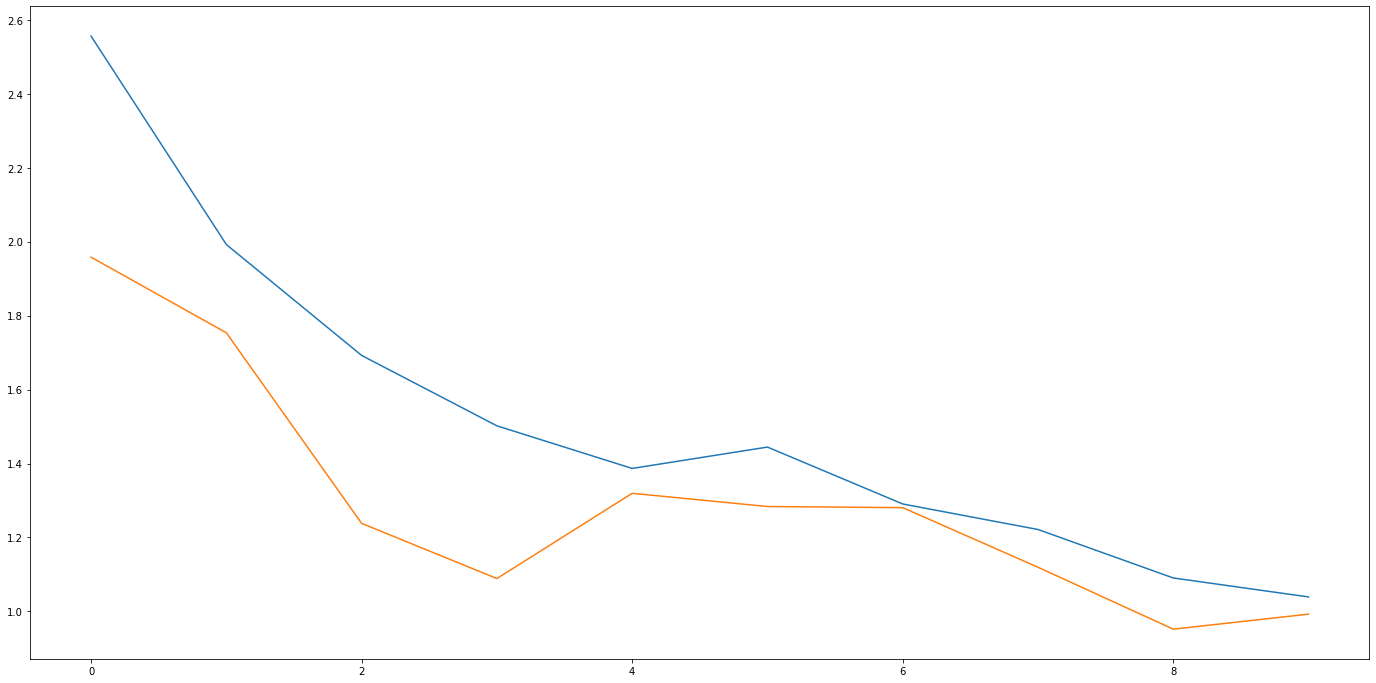

In [69]:
fig = figure(figsize=(24,12))
ax1 = plt.subplot(1,1,1)
sn.lineplot(x=range(len(train_losses)),y=train_losses, ax=ax1)
sn.lineplot(x=range(len(valid_losses)),y=valid_losses, ax=ax1)

The validation may be lower than the training because of data leakage

The validation might be easier data or we might have limited capabilities during training (dropout, regularization)

In [15]:
import torch

In [12]:
from DeepCoSI_Model import DeepCoSIPredictor

In [27]:
DeepCoSI_Model = DeepCoSIPredictor(node_feat_size=94, edge_feat_size=20, num_layers=3,
                                     graph_feat_size=256,
                                     d_FC_layer=200, n_FC_layer=2, dropout=0.)

In [28]:
DeepCoSI_Model.load_state_dict(torch.load('../../DeepCoSI/codes/DeepCoSI_model.pth', map_location=torch.device('cpu'))['model_state_dict'])

<All keys matched successfully>

In [35]:
import pickle

In [47]:
mol = Chem.MolFromPDBFile(f'cysteine_environments_10a_pdb/{keys[2900]}.pdb')

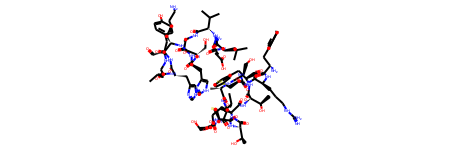

In [50]:
mol

In [29]:
optimizer = torch.optim.Adam(DeepCoSI_Model.parameters(), lr=0.0001, weight_decay=0.)
#loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(8.))
loss_fn = nn.BCELoss()

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=512, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(testing_dataset, batch_size=512, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)

In [31]:
train_aucs, valid_aucs, test_aucs = [],[],[]
train_accuracies, valid_accuracies, test_accuracies = [],[],[]
train_losses, valid_losses, test_losses = [],[],[]
train_precisions, valid_precisions, test_precisions = [],[],[]
train_recalls, valid_recalls, test_recalls = [],[],[]
train_thresholds, valid_thresholds,test_thresholds = [],[],[]
train_auprcs, valid_auprcs, test_auprcs = [],[],[]
train_num_positive, valid_num_positive, test_num_positive = [],[],[]

for epoch in tqdm(range(10)):
    st = time.time()
    # train
    #run_a_train_epoch(DeepCoSI_Model, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.5:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.5:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)
    test_aucs.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_thresholds.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    valid_thresholds.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_thresholds.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs.append(test_auprc)
    
    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    test_losses.append(test_loss.item())
    
    train_num_positive.append(np.array(train_pred_bin).sum())
    valid_num_positive.append(np.array(valid_pred_bin).sum())
    test_num_positive.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), valid_loss.item(), train_accuracy, valid_accuracy, train_auc, valid_auc, train_auprc, valid_auprc, train_num_positive[-1], valid_num_positive[-1],end - st))

 10%|█         | 1/10 [01:18<11:42, 78.03s/it]

epoch:0 	 train_loss:4.5530 	 valid_loss:4.9791 	 train_accuracy:0.8918 	 valid_accuracy:0.8848 	 train_auc:0.4044 	 valid_auc:0.3879 	 train_auprc:0.0845 	 valid_auprc:0.1058 	 train_num_positive:0.0000 	 valid_num_positive:0.0000 	 time:78.025 s


 10%|█         | 1/10 [01:55<17:19, 115.52s/it]


KeyboardInterrupt: 

In [14]:
from DeepCoSI_ModelWithLogits import DeepCoSIPredictorWithLogits

In [38]:
DeepCoSI_Model_logits = DeepCoSIPredictorWithLogits(node_feat_size=94, edge_feat_size=20, num_layers=3,
                                     graph_feat_size=256,
                                     d_FC_layer=256, n_FC_layer=2, dropout=0.)

In [39]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits.parameters(), lr=0.0001, weight_decay=0.)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(8.))

In [40]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=512, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(testing_dataset, batch_size=512, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)

In [41]:
train_aucs, valid_aucs, test_aucs = [],[],[]
train_accuracies, valid_accuracies, test_accuracies = [],[],[]
train_losses, valid_losses, test_losses = [],[],[]
train_precisions, valid_precisions, test_precisions = [],[],[]
train_recalls, valid_recalls, test_recalls = [],[],[]
train_thresholds, valid_thresholds,test_thresholds = [],[],[]
train_auprcs, valid_auprcs, test_auprcs = [],[],[]
train_num_positive, valid_num_positive, test_num_positive = [],[],[]

for epoch in tqdm(range(10)):
    st = time.time()
    # train
    #run_a_train_epoch(DeepCoSI_Model, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)
    test_aucs.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_thresholds.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    valid_thresholds.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_thresholds.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs.append(test_auprc)
    
    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    test_losses.append(test_loss.item())
    
    train_num_positive.append(np.array(train_pred_bin).sum())
    valid_num_positive.append(np.array(valid_pred_bin).sum())
    test_num_positive.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), valid_loss.item(), train_accuracy, valid_accuracy, train_auc, valid_auc, train_auprc, valid_auprc, train_num_positive[-1], valid_num_positive[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, test_loss.item(), test_accuracy, test_auc, test_auprc, test_num_positive[-1], end - st))

 10%|█         | 1/10 [01:18<11:46, 78.46s/it]

epoch:0 	 train_loss:1.2091 	 valid_loss:1.1998 	 train_accuracy:0.8616 	 valid_accuracy:0.3281 	 train_auc:0.5958 	 valid_auc:0.6288 	 train_auprc:0.1428 	 valid_auprc:0.1393 	 train_num_positive:110.0000 	 valid_num_positive:385.0000 	 time:78.459 s
epoch:0 	 test_loss:1.1580 	 test_accuracy:0.3047 	 test_auc:0.6017 	 test_auprc:0.1230 	 test_num_positive:391.0000 	 time:78.459 s


 20%|██        | 2/10 [02:36<10:25, 78.25s/it]

epoch:1 	 train_loss:1.2096 	 valid_loss:1.1894 	 train_accuracy:0.8612 	 valid_accuracy:0.3262 	 train_auc:0.5996 	 valid_auc:0.6098 	 train_auprc:0.1456 	 valid_auprc:0.1280 	 train_num_positive:112.0000 	 valid_num_positive:386.0000 	 time:78.099 s
epoch:1 	 test_loss:1.1406 	 test_accuracy:0.3047 	 test_auc:0.6023 	 test_auprc:0.1317 	 test_num_positive:387.0000 	 time:78.099 s


 20%|██        | 2/10 [03:19<13:18, 99.80s/it]


KeyboardInterrupt: 

In [51]:
baby_dataset = GraphDatasetGenerateSingleThread(keys=keys[:100], labels=labels[:100],cyss=cys_chain_and_idx[:100],
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='baby',
                                       path_marker='/')

Generating graphs ...


100%|██████████| 100/100 [00:00<00:00, 1233.23it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P51790_161.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P14616_191.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P05106_554.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P51693_128.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8N2G4_101.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IW52_242.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P35555_256.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P22607_119.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9BYR8_26.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HCJ2_375.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y219_633.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NGE9_97.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O60284_729.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75095_58

In [54]:
np.array(baby_dataset.labels).sum()

5

In [55]:
70/5

14.0

In [56]:
baby_dataloader = DataLoader(baby_dataset, batch_size=16, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)

In [60]:
DeepCoSI_Model_logits = DeepCoSIPredictorWithLogits(node_feat_size=94, edge_feat_size=20, num_layers=3,
                                     graph_feat_size=256,
                                     d_FC_layer=256, n_FC_layer=2, dropout=0.)

In [61]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits.parameters(), lr=0.0001, weight_decay=0.)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10.))

In [63]:
baby_aucs = []
baby_accuracies = []
baby_losses = []
baby_precisions = []
baby_recalls = []
baby_thresholds = [] 
baby_auprcs = [] 
baby_num_positive = []

for epoch in tqdm(range(50)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits, loss_fn, baby_dataloader, optimizer)
    baby_true, baby_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, baby_dataloader)

    baby_true = np.concatenate(np.array(baby_true), 0)
    baby_pred = np.concatenate(np.array(baby_pred), 0)
    
    baby_loss = loss_fn(torch.tensor(baby_pred, dtype=torch.float),
                         torch.tensor(baby_true, dtype=torch.float))
    
    baby_pred_bin = []
    for x in baby_pred[:,0]:
        if x >= 0.:
            baby_pred_bin.append([1.])
        else:
            baby_pred_bin.append([0.])     
    
    baby_auc = roc_auc_score(baby_true, baby_pred)
    baby_aucs.append(baby_auc)
    
    baby_accuracy = accuracy_score(baby_true, baby_pred_bin)
    baby_accuracies.append(baby_accuracy)
                           
    baby_precision, baby_recall, baby_threshold = precision_recall_curve(baby_true, baby_pred)
    baby_precisions.append(baby_precision)
    baby_recalls.append(baby_recall)
    baby_thresholds.append(baby_threshold)
    baby_auprc = auc(baby_recall, baby_precision)
    baby_auprcs.append(baby_auprc)

    baby_losses.append(baby_loss.item())
    
    baby_num_positive.append(np.array(baby_pred_bin).sum())
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, baby_loss.item(), baby_loss.item(), baby_accuracy, baby_accuracy, baby_auc, baby_auc, baby_auprc, baby_auprc, baby_num_positive[-1], baby_num_positive[-1],end - st))
    

  2%|▏         | 1/50 [00:04<03:45,  4.59s/it]

epoch:0 	 train_loss:2.0607 	 valid_loss:2.0607 	 train_accuracy:0.8906 	 valid_accuracy:0.8906 	 train_auc:0.2847 	 valid_auc:0.2847 	 train_auprc:0.0511 	 valid_auprc:0.0511 	 train_num_positive:2.0000 	 valid_num_positive:2.0000 	 time:4.594 s


  4%|▍         | 2/50 [00:09<03:39,  4.58s/it]

epoch:1 	 train_loss:1.8848 	 valid_loss:1.8848 	 train_accuracy:0.8438 	 valid_accuracy:0.8438 	 train_auc:0.1458 	 valid_auc:0.1458 	 train_auprc:0.0360 	 valid_auprc:0.0360 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.574 s


  6%|▌         | 3/50 [00:13<03:38,  4.65s/it]

epoch:2 	 train_loss:1.7244 	 valid_loss:1.7244 	 train_accuracy:0.5469 	 valid_accuracy:0.5469 	 train_auc:0.1625 	 valid_auc:0.1625 	 train_auprc:0.0358 	 valid_auprc:0.0358 	 train_num_positive:25.0000 	 valid_num_positive:25.0000 	 time:4.738 s


  8%|▊         | 4/50 [00:18<03:33,  4.64s/it]

epoch:3 	 train_loss:2.0691 	 valid_loss:2.0691 	 train_accuracy:0.6562 	 valid_accuracy:0.6562 	 train_auc:0.1083 	 valid_auc:0.1083 	 train_auprc:0.0344 	 valid_auprc:0.0344 	 train_num_positive:18.0000 	 valid_num_positive:18.0000 	 time:4.623 s


 10%|█         | 5/50 [00:23<03:28,  4.64s/it]

epoch:4 	 train_loss:1.8323 	 valid_loss:1.8323 	 train_accuracy:0.7812 	 valid_accuracy:0.7812 	 train_auc:0.3750 	 valid_auc:0.3750 	 train_auprc:0.0467 	 valid_auprc:0.0467 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.638 s


 12%|█▏        | 6/50 [00:27<03:23,  4.63s/it]

epoch:5 	 train_loss:1.8683 	 valid_loss:1.8683 	 train_accuracy:0.8438 	 valid_accuracy:0.8438 	 train_auc:0.4750 	 valid_auc:0.4750 	 train_auprc:0.0636 	 valid_auprc:0.0636 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.598 s


 14%|█▍        | 7/50 [00:32<03:19,  4.63s/it]

epoch:6 	 train_loss:1.4124 	 valid_loss:1.4124 	 train_accuracy:0.8594 	 valid_accuracy:0.8594 	 train_auc:0.4317 	 valid_auc:0.4317 	 train_auprc:0.3578 	 valid_auprc:0.3578 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.645 s


 16%|█▌        | 8/50 [00:36<03:13,  4.61s/it]

epoch:7 	 train_loss:3.1869 	 valid_loss:3.1869 	 train_accuracy:0.8281 	 valid_accuracy:0.8281 	 train_auc:0.2949 	 valid_auc:0.2949 	 train_auprc:0.0512 	 valid_auprc:0.0512 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.567 s


 18%|█▊        | 9/50 [00:41<03:09,  4.63s/it]

epoch:8 	 train_loss:1.6980 	 valid_loss:1.6980 	 train_accuracy:0.7500 	 valid_accuracy:0.7500 	 train_auc:0.5417 	 valid_auc:0.5417 	 train_auprc:0.0622 	 valid_auprc:0.0622 	 train_num_positive:12.0000 	 valid_num_positive:12.0000 	 time:4.658 s


 20%|██        | 10/50 [00:46<03:04,  4.61s/it]

epoch:9 	 train_loss:1.4155 	 valid_loss:1.4155 	 train_accuracy:0.6719 	 valid_accuracy:0.6719 	 train_auc:0.6250 	 valid_auc:0.6250 	 train_auprc:0.0810 	 valid_auprc:0.0810 	 train_num_positive:19.0000 	 valid_num_positive:19.0000 	 time:4.563 s


 22%|██▏       | 11/50 [00:50<02:59,  4.61s/it]

epoch:10 	 train_loss:1.1485 	 valid_loss:1.1485 	 train_accuracy:0.6406 	 valid_accuracy:0.6406 	 train_auc:0.6292 	 valid_auc:0.6292 	 train_auprc:0.0756 	 valid_auprc:0.0756 	 train_num_positive:23.0000 	 valid_num_positive:23.0000 	 time:4.621 s


 24%|██▍       | 12/50 [00:55<02:54,  4.60s/it]

epoch:11 	 train_loss:0.9023 	 valid_loss:0.9023 	 train_accuracy:0.5469 	 valid_accuracy:0.5469 	 train_auc:0.8881 	 valid_auc:0.8881 	 train_auprc:0.2889 	 valid_auprc:0.2889 	 train_num_positive:34.0000 	 valid_num_positive:34.0000 	 time:4.569 s


 26%|██▌       | 13/50 [01:00<02:51,  4.64s/it]

epoch:12 	 train_loss:0.7616 	 valid_loss:0.7616 	 train_accuracy:0.6562 	 valid_accuracy:0.6562 	 train_auc:0.9667 	 valid_auc:0.9667 	 train_auprc:0.7113 	 valid_auprc:0.7113 	 train_num_positive:26.0000 	 valid_num_positive:26.0000 	 time:4.726 s


 28%|██▊       | 14/50 [01:04<02:45,  4.60s/it]

epoch:13 	 train_loss:0.7357 	 valid_loss:0.7357 	 train_accuracy:0.6719 	 valid_accuracy:0.6719 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:25.0000 	 valid_num_positive:25.0000 	 time:4.506 s


 30%|███       | 15/50 [01:09<02:41,  4.63s/it]

epoch:14 	 train_loss:0.7251 	 valid_loss:0.7251 	 train_accuracy:0.5938 	 valid_accuracy:0.5938 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:30.0000 	 valid_num_positive:30.0000 	 time:4.695 s


 32%|███▏      | 16/50 [01:14<02:37,  4.65s/it]

epoch:15 	 train_loss:0.6882 	 valid_loss:0.6882 	 train_accuracy:0.7031 	 valid_accuracy:0.7031 	 train_auc:0.9966 	 valid_auc:0.9966 	 train_auprc:0.9633 	 valid_auprc:0.9633 	 train_num_positive:24.0000 	 valid_num_positive:24.0000 	 time:4.690 s


 34%|███▍      | 17/50 [01:18<02:32,  4.63s/it]

epoch:16 	 train_loss:0.6006 	 valid_loss:0.6006 	 train_accuracy:0.8125 	 valid_accuracy:0.8125 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:16.0000 	 valid_num_positive:16.0000 	 time:4.577 s


 36%|███▌      | 18/50 [01:23<02:27,  4.61s/it]

epoch:17 	 train_loss:0.5494 	 valid_loss:0.5494 	 train_accuracy:0.8125 	 valid_accuracy:0.8125 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:14.0000 	 valid_num_positive:14.0000 	 time:4.560 s


 38%|███▊      | 19/50 [01:27<02:23,  4.64s/it]

epoch:18 	 train_loss:0.5413 	 valid_loss:0.5413 	 train_accuracy:0.8281 	 valid_accuracy:0.8281 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:16.0000 	 valid_num_positive:16.0000 	 time:4.725 s


 40%|████      | 20/50 [01:32<02:20,  4.68s/it]

epoch:19 	 train_loss:0.5575 	 valid_loss:0.5575 	 train_accuracy:0.8125 	 valid_accuracy:0.8125 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:17.0000 	 valid_num_positive:17.0000 	 time:4.779 s


 42%|████▏     | 21/50 [01:37<02:15,  4.66s/it]

epoch:20 	 train_loss:0.5485 	 valid_loss:0.5485 	 train_accuracy:0.8750 	 valid_accuracy:0.8750 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:11.0000 	 valid_num_positive:11.0000 	 time:4.601 s


 44%|████▍     | 22/50 [01:41<02:09,  4.64s/it]

epoch:21 	 train_loss:0.5561 	 valid_loss:0.5561 	 train_accuracy:0.8125 	 valid_accuracy:0.8125 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:16.0000 	 valid_num_positive:16.0000 	 time:4.582 s


 46%|████▌     | 23/50 [01:46<02:04,  4.61s/it]

epoch:22 	 train_loss:0.5429 	 valid_loss:0.5429 	 train_accuracy:0.8125 	 valid_accuracy:0.8125 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:16.0000 	 valid_num_positive:16.0000 	 time:4.540 s


 48%|████▊     | 24/50 [01:51<02:00,  4.65s/it]

epoch:23 	 train_loss:0.5867 	 valid_loss:0.5867 	 train_accuracy:0.7656 	 valid_accuracy:0.7656 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:19.0000 	 valid_num_positive:19.0000 	 time:4.754 s


 50%|█████     | 25/50 [01:55<01:57,  4.69s/it]

epoch:24 	 train_loss:0.5456 	 valid_loss:0.5456 	 train_accuracy:0.8906 	 valid_accuracy:0.8906 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:11.0000 	 valid_num_positive:11.0000 	 time:4.780 s


 52%|█████▏    | 26/50 [02:00<01:51,  4.64s/it]

epoch:25 	 train_loss:0.5034 	 valid_loss:0.5034 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.532 s


 54%|█████▍    | 27/50 [02:05<01:47,  4.67s/it]

epoch:26 	 train_loss:0.4971 	 valid_loss:0.4971 	 train_accuracy:0.9062 	 valid_accuracy:0.9062 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.720 s


 56%|█████▌    | 28/50 [02:09<01:41,  4.62s/it]

epoch:27 	 train_loss:0.5394 	 valid_loss:0.5394 	 train_accuracy:0.8438 	 valid_accuracy:0.8438 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:15.0000 	 valid_num_positive:15.0000 	 time:4.515 s


 58%|█████▊    | 29/50 [02:14<01:37,  4.65s/it]

epoch:28 	 train_loss:0.5153 	 valid_loss:0.5153 	 train_accuracy:0.9062 	 valid_accuracy:0.9062 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:11.0000 	 valid_num_positive:11.0000 	 time:4.712 s


 60%|██████    | 30/50 [02:19<01:32,  4.64s/it]

epoch:29 	 train_loss:0.5368 	 valid_loss:0.5368 	 train_accuracy:0.8906 	 valid_accuracy:0.8906 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:12.0000 	 valid_num_positive:12.0000 	 time:4.625 s


 62%|██████▏   | 31/50 [02:23<01:27,  4.59s/it]

epoch:30 	 train_loss:0.4614 	 valid_loss:0.4614 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.460 s


 64%|██████▍   | 32/50 [02:28<01:23,  4.65s/it]

epoch:31 	 train_loss:0.6356 	 valid_loss:0.6356 	 train_accuracy:0.6562 	 valid_accuracy:0.6562 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:27.0000 	 valid_num_positive:27.0000 	 time:4.804 s


 66%|██████▌   | 33/50 [02:32<01:19,  4.66s/it]

epoch:32 	 train_loss:0.5214 	 valid_loss:0.5214 	 train_accuracy:0.8750 	 valid_accuracy:0.8750 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:12.0000 	 valid_num_positive:12.0000 	 time:4.686 s


 68%|██████▊   | 34/50 [02:37<01:13,  4.62s/it]

epoch:33 	 train_loss:0.4227 	 valid_loss:0.4227 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.529 s


 70%|███████   | 35/50 [02:42<01:09,  4.61s/it]

epoch:34 	 train_loss:0.3921 	 valid_loss:0.3921 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.588 s


 72%|███████▏  | 36/50 [02:46<01:05,  4.65s/it]

epoch:35 	 train_loss:0.4667 	 valid_loss:0.4667 	 train_accuracy:0.9062 	 valid_accuracy:0.9062 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:11.0000 	 valid_num_positive:11.0000 	 time:4.747 s


 74%|███████▍  | 37/50 [02:51<01:01,  4.71s/it]

epoch:36 	 train_loss:0.5080 	 valid_loss:0.5080 	 train_accuracy:0.8906 	 valid_accuracy:0.8906 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:11.0000 	 valid_num_positive:11.0000 	 time:4.834 s


 76%|███████▌  | 38/50 [02:56<00:56,  4.67s/it]

epoch:37 	 train_loss:0.5178 	 valid_loss:0.5178 	 train_accuracy:0.8594 	 valid_accuracy:0.8594 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:14.0000 	 valid_num_positive:14.0000 	 time:4.583 s


 78%|███████▊  | 39/50 [03:00<00:51,  4.65s/it]

epoch:38 	 train_loss:0.5179 	 valid_loss:0.5179 	 train_accuracy:0.8125 	 valid_accuracy:0.8125 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:17.0000 	 valid_num_positive:17.0000 	 time:4.603 s


 80%|████████  | 40/50 [03:05<00:46,  4.60s/it]

epoch:39 	 train_loss:0.5667 	 valid_loss:0.5667 	 train_accuracy:0.7656 	 valid_accuracy:0.7656 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:20.0000 	 valid_num_positive:20.0000 	 time:4.495 s


 82%|████████▏ | 41/50 [03:10<00:41,  4.63s/it]

epoch:40 	 train_loss:0.5450 	 valid_loss:0.5450 	 train_accuracy:0.8125 	 valid_accuracy:0.8125 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:16.0000 	 valid_num_positive:16.0000 	 time:4.676 s


 84%|████████▍ | 42/50 [03:14<00:37,  4.69s/it]

epoch:41 	 train_loss:0.4563 	 valid_loss:0.4563 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.827 s


 86%|████████▌ | 43/50 [03:19<00:32,  4.70s/it]

epoch:42 	 train_loss:0.3799 	 valid_loss:0.3799 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.740 s


 88%|████████▊ | 44/50 [03:24<00:28,  4.71s/it]

epoch:43 	 train_loss:0.3902 	 valid_loss:0.3902 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.725 s


 90%|█████████ | 45/50 [03:28<00:23,  4.67s/it]

epoch:44 	 train_loss:0.3625 	 valid_loss:0.3625 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.590 s


 92%|█████████▏| 46/50 [03:33<00:18,  4.71s/it]

epoch:45 	 train_loss:0.3967 	 valid_loss:0.3967 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.787 s


 94%|█████████▍| 47/50 [03:38<00:14,  4.73s/it]

epoch:46 	 train_loss:0.4734 	 valid_loss:0.4734 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.773 s


 96%|█████████▌| 48/50 [03:43<00:09,  4.72s/it]

epoch:47 	 train_loss:0.5877 	 valid_loss:0.5877 	 train_accuracy:0.6562 	 valid_accuracy:0.6562 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:27.0000 	 valid_num_positive:27.0000 	 time:4.701 s


 98%|█████████▊| 49/50 [03:47<00:04,  4.73s/it]

epoch:48 	 train_loss:0.5047 	 valid_loss:0.5047 	 train_accuracy:0.8125 	 valid_accuracy:0.8125 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:17.0000 	 valid_num_positive:17.0000 	 time:4.741 s


100%|██████████| 50/50 [03:52<00:00,  4.65s/it]

epoch:49 	 train_loss:0.4355 	 valid_loss:0.4355 	 train_accuracy:0.8906 	 valid_accuracy:0.8906 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:12.0000 	 valid_num_positive:12.0000 	 time:4.535 s


In [67]:
for epoch in tqdm(range(200)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits, loss_fn, baby_dataloader, optimizer)
    baby_true, baby_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, baby_dataloader)

    baby_true = np.concatenate(np.array(baby_true), 0)
    baby_pred = np.concatenate(np.array(baby_pred), 0)
    
    baby_loss = loss_fn(torch.tensor(baby_pred, dtype=torch.float),
                         torch.tensor(baby_true, dtype=torch.float))
    
    baby_pred_bin = []
    for x in baby_pred[:,0]:
        if x >= 0.:
            baby_pred_bin.append([1.])
        else:
            baby_pred_bin.append([0.])     
    
    baby_auc = roc_auc_score(baby_true, baby_pred)
    baby_aucs.append(baby_auc)
    
    baby_accuracy = accuracy_score(baby_true, baby_pred_bin)
    baby_accuracies.append(baby_accuracy)
                           
    baby_precision, baby_recall, baby_threshold = precision_recall_curve(baby_true, baby_pred)
    baby_precisions.append(baby_precision)
    baby_recalls.append(baby_recall)
    baby_thresholds.append(baby_threshold)
    baby_auprc = auc(baby_recall, baby_precision)
    baby_auprcs.append(baby_auprc)

    baby_losses.append(baby_loss.item())
    
    baby_num_positive.append(np.array(baby_pred_bin).sum())
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, baby_loss.item(), baby_loss.item(), baby_accuracy, baby_accuracy, baby_auc, baby_auc, baby_auprc, baby_auprc, baby_num_positive[-1], baby_num_positive[-1],end - st))

  0%|          | 1/200 [00:04<15:38,  4.72s/it]

epoch:0 	 train_loss:0.3832 	 valid_loss:0.3832 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.716 s


  1%|          | 2/200 [00:09<15:35,  4.73s/it]

epoch:1 	 train_loss:0.4327 	 valid_loss:0.4327 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.733 s


  2%|▏         | 3/200 [00:14<15:21,  4.68s/it]

epoch:2 	 train_loss:0.4413 	 valid_loss:0.4413 	 train_accuracy:0.8594 	 valid_accuracy:0.8594 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:12.0000 	 valid_num_positive:12.0000 	 time:4.622 s


  2%|▏         | 4/200 [00:18<15:17,  4.68s/it]

epoch:3 	 train_loss:0.4587 	 valid_loss:0.4587 	 train_accuracy:0.8594 	 valid_accuracy:0.8594 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:14.0000 	 valid_num_positive:14.0000 	 time:4.690 s


  2%|▎         | 5/200 [00:23<15:12,  4.68s/it]

epoch:4 	 train_loss:0.3628 	 valid_loss:0.3628 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.665 s


  3%|▎         | 6/200 [00:28<15:01,  4.65s/it]

epoch:5 	 train_loss:0.3135 	 valid_loss:0.3135 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.594 s


  4%|▎         | 7/200 [00:32<14:53,  4.63s/it]

epoch:6 	 train_loss:0.4203 	 valid_loss:0.4203 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.584 s


  4%|▍         | 8/200 [00:37<14:51,  4.64s/it]

epoch:7 	 train_loss:0.4389 	 valid_loss:0.4389 	 train_accuracy:0.9062 	 valid_accuracy:0.9062 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.673 s


  4%|▍         | 9/200 [00:42<14:53,  4.68s/it]

epoch:8 	 train_loss:0.3320 	 valid_loss:0.3320 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.758 s


  5%|▌         | 10/200 [00:46<14:33,  4.59s/it]

epoch:9 	 train_loss:0.3224 	 valid_loss:0.3224 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.406 s


  6%|▌         | 11/200 [00:51<14:34,  4.62s/it]

epoch:10 	 train_loss:0.3270 	 valid_loss:0.3270 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.692 s


  6%|▌         | 12/200 [00:55<14:29,  4.62s/it]

epoch:11 	 train_loss:0.2774 	 valid_loss:0.2774 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.617 s


  6%|▋         | 13/200 [01:00<14:27,  4.64s/it]

epoch:12 	 train_loss:0.2876 	 valid_loss:0.2876 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.678 s


  7%|▋         | 14/200 [01:04<14:14,  4.59s/it]

epoch:13 	 train_loss:0.3592 	 valid_loss:0.3592 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.491 s


  8%|▊         | 15/200 [01:09<14:19,  4.65s/it]

epoch:14 	 train_loss:0.2900 	 valid_loss:0.2900 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.770 s


  8%|▊         | 16/200 [01:14<14:19,  4.67s/it]

epoch:15 	 train_loss:0.2797 	 valid_loss:0.2797 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.722 s


  8%|▊         | 17/200 [01:19<14:12,  4.66s/it]

epoch:16 	 train_loss:0.3980 	 valid_loss:0.3980 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.637 s


  9%|▉         | 18/200 [01:23<14:02,  4.63s/it]

epoch:17 	 train_loss:0.4983 	 valid_loss:0.4983 	 train_accuracy:0.8594 	 valid_accuracy:0.8594 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:13.0000 	 valid_num_positive:13.0000 	 time:4.556 s


 10%|▉         | 19/200 [01:28<14:00,  4.64s/it]

epoch:18 	 train_loss:0.4945 	 valid_loss:0.4945 	 train_accuracy:0.9062 	 valid_accuracy:0.9062 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.679 s


 10%|█         | 20/200 [01:33<13:59,  4.66s/it]

epoch:19 	 train_loss:0.4683 	 valid_loss:0.4683 	 train_accuracy:0.8906 	 valid_accuracy:0.8906 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:12.0000 	 valid_num_positive:12.0000 	 time:4.710 s


 10%|█         | 21/200 [01:37<13:47,  4.62s/it]

epoch:20 	 train_loss:0.4115 	 valid_loss:0.4115 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.517 s


 11%|█         | 22/200 [01:42<13:49,  4.66s/it]

epoch:21 	 train_loss:0.3604 	 valid_loss:0.3604 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.749 s


 12%|█▏        | 23/200 [01:46<13:44,  4.66s/it]

epoch:22 	 train_loss:0.2815 	 valid_loss:0.2815 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.649 s


 12%|█▏        | 24/200 [01:51<13:33,  4.62s/it]

epoch:23 	 train_loss:0.2587 	 valid_loss:0.2587 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.547 s


 12%|█▎        | 25/200 [01:56<13:27,  4.61s/it]

epoch:24 	 train_loss:0.2411 	 valid_loss:0.2411 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:3.0000 	 valid_num_positive:3.0000 	 time:4.588 s


 13%|█▎        | 26/200 [02:00<13:21,  4.61s/it]

epoch:25 	 train_loss:0.2742 	 valid_loss:0.2742 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.598 s


 14%|█▎        | 27/200 [02:05<13:22,  4.64s/it]

epoch:26 	 train_loss:0.3613 	 valid_loss:0.3613 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.713 s


 14%|█▍        | 28/200 [02:10<13:22,  4.67s/it]

epoch:27 	 train_loss:0.4119 	 valid_loss:0.4119 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.728 s


 14%|█▍        | 29/200 [02:14<13:24,  4.71s/it]

epoch:28 	 train_loss:0.6174 	 valid_loss:0.6174 	 train_accuracy:0.8906 	 valid_accuracy:0.8906 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:12.0000 	 valid_num_positive:12.0000 	 time:4.796 s


 15%|█▌        | 30/200 [02:19<13:15,  4.68s/it]

epoch:29 	 train_loss:0.7578 	 valid_loss:0.7578 	 train_accuracy:0.7188 	 valid_accuracy:0.7188 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:23.0000 	 valid_num_positive:23.0000 	 time:4.621 s


 16%|█▌        | 31/200 [02:24<13:09,  4.67s/it]

epoch:30 	 train_loss:0.7440 	 valid_loss:0.7440 	 train_accuracy:0.5625 	 valid_accuracy:0.5625 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:32.0000 	 valid_num_positive:32.0000 	 time:4.650 s


 16%|█▌        | 32/200 [02:28<13:02,  4.65s/it]

epoch:31 	 train_loss:0.3570 	 valid_loss:0.3570 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.616 s


 16%|█▋        | 33/200 [02:33<12:56,  4.65s/it]

epoch:32 	 train_loss:0.2470 	 valid_loss:0.2470 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.647 s


 17%|█▋        | 34/200 [02:38<12:58,  4.69s/it]

epoch:33 	 train_loss:0.2953 	 valid_loss:0.2953 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:3.0000 	 valid_num_positive:3.0000 	 time:4.780 s


 18%|█▊        | 35/200 [02:42<12:46,  4.64s/it]

epoch:34 	 train_loss:0.5215 	 valid_loss:0.5215 	 train_accuracy:0.7656 	 valid_accuracy:0.7656 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:20.0000 	 valid_num_positive:20.0000 	 time:4.532 s


 18%|█▊        | 36/200 [02:47<12:29,  4.57s/it]

epoch:35 	 train_loss:0.5200 	 valid_loss:0.5200 	 train_accuracy:0.7344 	 valid_accuracy:0.7344 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:22.0000 	 valid_num_positive:22.0000 	 time:4.401 s


 18%|█▊        | 37/200 [02:51<12:36,  4.64s/it]

epoch:36 	 train_loss:0.3319 	 valid_loss:0.3319 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.803 s


 19%|█▉        | 38/200 [02:56<12:37,  4.67s/it]

epoch:37 	 train_loss:0.3444 	 valid_loss:0.3444 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.747 s


 20%|█▉        | 39/200 [03:01<12:41,  4.73s/it]

epoch:38 	 train_loss:0.4677 	 valid_loss:0.4677 	 train_accuracy:0.8750 	 valid_accuracy:0.8750 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:13.0000 	 valid_num_positive:13.0000 	 time:4.863 s


 20%|██        | 40/200 [03:06<12:29,  4.68s/it]

epoch:39 	 train_loss:0.3568 	 valid_loss:0.3568 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.578 s


 20%|██        | 41/200 [03:10<12:23,  4.67s/it]

epoch:40 	 train_loss:0.3989 	 valid_loss:0.3989 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.650 s


 21%|██        | 42/200 [03:15<12:17,  4.67s/it]

epoch:41 	 train_loss:0.3677 	 valid_loss:0.3677 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.661 s


 22%|██▏       | 43/200 [03:20<12:09,  4.64s/it]

epoch:42 	 train_loss:0.2706 	 valid_loss:0.2706 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.580 s


 22%|██▏       | 44/200 [03:24<12:10,  4.68s/it]

epoch:43 	 train_loss:0.3200 	 valid_loss:0.3200 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.778 s


 22%|██▎       | 45/200 [03:29<12:07,  4.69s/it]

epoch:44 	 train_loss:0.3175 	 valid_loss:0.3175 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.712 s


 23%|██▎       | 46/200 [03:34<12:04,  4.70s/it]

epoch:45 	 train_loss:0.3828 	 valid_loss:0.3828 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.732 s


 24%|██▎       | 47/200 [03:38<12:01,  4.71s/it]

epoch:46 	 train_loss:0.4560 	 valid_loss:0.4560 	 train_accuracy:0.8281 	 valid_accuracy:0.8281 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:13.0000 	 valid_num_positive:13.0000 	 time:4.737 s


 24%|██▍       | 48/200 [03:43<11:58,  4.73s/it]

epoch:47 	 train_loss:0.3763 	 valid_loss:0.3763 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.749 s


 24%|██▍       | 49/200 [03:48<11:43,  4.66s/it]

epoch:48 	 train_loss:0.3615 	 valid_loss:0.3615 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.512 s


 25%|██▌       | 50/200 [03:52<11:38,  4.66s/it]

epoch:49 	 train_loss:0.2057 	 valid_loss:0.2057 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.649 s


 26%|██▌       | 51/200 [03:57<11:41,  4.71s/it]

epoch:50 	 train_loss:0.3103 	 valid_loss:0.3103 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.832 s


 26%|██▌       | 52/200 [04:02<11:29,  4.66s/it]

epoch:51 	 train_loss:0.4040 	 valid_loss:0.4040 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.544 s


 26%|██▋       | 53/200 [04:06<11:23,  4.65s/it]

epoch:52 	 train_loss:0.2081 	 valid_loss:0.2081 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.631 s


 27%|██▋       | 54/200 [04:11<11:21,  4.67s/it]

epoch:53 	 train_loss:0.5076 	 valid_loss:0.5076 	 train_accuracy:0.7656 	 valid_accuracy:0.7656 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:19.0000 	 valid_num_positive:19.0000 	 time:4.699 s


 28%|██▊       | 55/200 [04:16<11:12,  4.64s/it]

epoch:54 	 train_loss:0.5039 	 valid_loss:0.5039 	 train_accuracy:0.7656 	 valid_accuracy:0.7656 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:20.0000 	 valid_num_positive:20.0000 	 time:4.572 s


 28%|██▊       | 56/200 [04:20<11:05,  4.62s/it]

epoch:55 	 train_loss:0.6303 	 valid_loss:0.6303 	 train_accuracy:0.6875 	 valid_accuracy:0.6875 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:24.0000 	 valid_num_positive:24.0000 	 time:4.592 s


 28%|██▊       | 57/200 [04:25<10:56,  4.59s/it]

epoch:56 	 train_loss:0.5362 	 valid_loss:0.5362 	 train_accuracy:0.7969 	 valid_accuracy:0.7969 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:17.0000 	 valid_num_positive:17.0000 	 time:4.520 s


 29%|██▉       | 58/200 [04:30<10:59,  4.65s/it]

epoch:57 	 train_loss:0.3135 	 valid_loss:0.3135 	 train_accuracy:0.9062 	 valid_accuracy:0.9062 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.772 s


 30%|██▉       | 59/200 [04:34<10:53,  4.63s/it]

epoch:58 	 train_loss:0.6899 	 valid_loss:0.6899 	 train_accuracy:0.7812 	 valid_accuracy:0.7812 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:18.0000 	 valid_num_positive:18.0000 	 time:4.600 s


 30%|███       | 60/200 [04:39<10:52,  4.66s/it]

epoch:59 	 train_loss:0.4933 	 valid_loss:0.4933 	 train_accuracy:0.7812 	 valid_accuracy:0.7812 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:19.0000 	 valid_num_positive:19.0000 	 time:4.723 s


 30%|███       | 61/200 [04:44<10:54,  4.71s/it]

epoch:60 	 train_loss:0.2506 	 valid_loss:0.2506 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.822 s


 31%|███       | 62/200 [04:48<10:49,  4.71s/it]

epoch:61 	 train_loss:0.1797 	 valid_loss:0.1797 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:3.0000 	 valid_num_positive:3.0000 	 time:4.698 s


 32%|███▏      | 63/200 [04:53<10:46,  4.72s/it]

epoch:62 	 train_loss:0.8030 	 valid_loss:0.8030 	 train_accuracy:0.5938 	 valid_accuracy:0.5938 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:30.0000 	 valid_num_positive:30.0000 	 time:4.744 s


 32%|███▏      | 64/200 [04:58<10:38,  4.69s/it]

epoch:63 	 train_loss:0.5749 	 valid_loss:0.5749 	 train_accuracy:0.7344 	 valid_accuracy:0.7344 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:22.0000 	 valid_num_positive:22.0000 	 time:4.634 s


 32%|███▎      | 65/200 [05:03<10:34,  4.70s/it]

epoch:64 	 train_loss:0.2995 	 valid_loss:0.2995 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.726 s


 33%|███▎      | 66/200 [05:07<10:27,  4.69s/it]

epoch:65 	 train_loss:0.3123 	 valid_loss:0.3123 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.645 s


 34%|███▎      | 67/200 [05:12<10:18,  4.65s/it]

epoch:66 	 train_loss:0.4798 	 valid_loss:0.4798 	 train_accuracy:0.9062 	 valid_accuracy:0.9062 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:11.0000 	 valid_num_positive:11.0000 	 time:4.566 s


 34%|███▍      | 68/200 [05:16<10:12,  4.64s/it]

epoch:67 	 train_loss:0.3641 	 valid_loss:0.3641 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.621 s


 34%|███▍      | 69/200 [05:21<10:08,  4.64s/it]

epoch:68 	 train_loss:0.3416 	 valid_loss:0.3416 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:0.9966 	 valid_auc:0.9966 	 train_auprc:0.9633 	 valid_auprc:0.9633 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.650 s


 35%|███▌      | 70/200 [05:26<10:05,  4.65s/it]

epoch:69 	 train_loss:0.2934 	 valid_loss:0.2934 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.678 s


 36%|███▌      | 71/200 [05:30<09:59,  4.65s/it]

epoch:70 	 train_loss:0.3346 	 valid_loss:0.3346 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.633 s


 36%|███▌      | 72/200 [05:35<09:56,  4.66s/it]

epoch:71 	 train_loss:0.4857 	 valid_loss:0.4857 	 train_accuracy:0.7969 	 valid_accuracy:0.7969 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:18.0000 	 valid_num_positive:18.0000 	 time:4.700 s


 36%|███▋      | 73/200 [05:40<09:51,  4.66s/it]

epoch:72 	 train_loss:0.5741 	 valid_loss:0.5741 	 train_accuracy:0.6562 	 valid_accuracy:0.6562 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:27.0000 	 valid_num_positive:27.0000 	 time:4.639 s


 37%|███▋      | 74/200 [05:44<09:51,  4.70s/it]

epoch:73 	 train_loss:0.5062 	 valid_loss:0.5062 	 train_accuracy:0.7812 	 valid_accuracy:0.7812 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:16.0000 	 valid_num_positive:16.0000 	 time:4.792 s


 38%|███▊      | 75/200 [05:49<09:43,  4.67s/it]

epoch:74 	 train_loss:0.4426 	 valid_loss:0.4426 	 train_accuracy:0.8438 	 valid_accuracy:0.8438 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:13.0000 	 valid_num_positive:13.0000 	 time:4.600 s


 38%|███▊      | 76/200 [05:54<09:37,  4.66s/it]

epoch:75 	 train_loss:0.6672 	 valid_loss:0.6672 	 train_accuracy:0.6719 	 valid_accuracy:0.6719 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:24.0000 	 valid_num_positive:24.0000 	 time:4.631 s


 38%|███▊      | 77/200 [05:58<09:37,  4.69s/it]

epoch:76 	 train_loss:0.7360 	 valid_loss:0.7360 	 train_accuracy:0.6406 	 valid_accuracy:0.6406 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:27.0000 	 valid_num_positive:27.0000 	 time:4.780 s


 39%|███▉      | 78/200 [06:03<09:29,  4.67s/it]

epoch:77 	 train_loss:1.2762 	 valid_loss:1.2762 	 train_accuracy:0.4062 	 valid_accuracy:0.4062 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:42.0000 	 valid_num_positive:42.0000 	 time:4.610 s


 40%|███▉      | 79/200 [06:08<09:21,  4.64s/it]

epoch:78 	 train_loss:1.0585 	 valid_loss:1.0585 	 train_accuracy:0.4531 	 valid_accuracy:0.4531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:40.0000 	 valid_num_positive:40.0000 	 time:4.583 s


 40%|████      | 80/200 [06:12<09:21,  4.68s/it]

epoch:79 	 train_loss:0.9901 	 valid_loss:0.9901 	 train_accuracy:0.5469 	 valid_accuracy:0.5469 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:34.0000 	 valid_num_positive:34.0000 	 time:4.756 s


 40%|████      | 81/200 [06:17<09:17,  4.69s/it]

epoch:80 	 train_loss:0.6269 	 valid_loss:0.6269 	 train_accuracy:0.6562 	 valid_accuracy:0.6562 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:26.0000 	 valid_num_positive:26.0000 	 time:4.711 s


 41%|████      | 82/200 [06:22<09:11,  4.68s/it]

epoch:81 	 train_loss:0.3522 	 valid_loss:0.3522 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.647 s


 42%|████▏     | 83/200 [06:26<09:05,  4.66s/it]

epoch:82 	 train_loss:0.3347 	 valid_loss:0.3347 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.630 s


 42%|████▏     | 84/200 [06:31<08:57,  4.63s/it]

epoch:83 	 train_loss:0.3175 	 valid_loss:0.3175 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.571 s


 42%|████▎     | 85/200 [06:36<08:55,  4.65s/it]

epoch:84 	 train_loss:1.2665 	 valid_loss:1.2665 	 train_accuracy:0.4688 	 valid_accuracy:0.4688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:38.0000 	 valid_num_positive:38.0000 	 time:4.698 s


 43%|████▎     | 86/200 [06:40<08:48,  4.64s/it]

epoch:85 	 train_loss:0.6291 	 valid_loss:0.6291 	 train_accuracy:0.6719 	 valid_accuracy:0.6719 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:25.0000 	 valid_num_positive:25.0000 	 time:4.602 s


 44%|████▎     | 87/200 [06:45<08:43,  4.63s/it]

epoch:86 	 train_loss:0.3280 	 valid_loss:0.3280 	 train_accuracy:0.9062 	 valid_accuracy:0.9062 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.621 s


 44%|████▍     | 88/200 [06:50<08:44,  4.68s/it]

epoch:87 	 train_loss:0.2424 	 valid_loss:0.2424 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.795 s


 44%|████▍     | 89/200 [06:55<08:46,  4.74s/it]

epoch:88 	 train_loss:0.1973 	 valid_loss:0.1973 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.878 s


 45%|████▌     | 90/200 [06:59<08:39,  4.72s/it]

epoch:89 	 train_loss:0.2141 	 valid_loss:0.2141 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.670 s


 46%|████▌     | 91/200 [07:04<08:30,  4.68s/it]

epoch:90 	 train_loss:0.2521 	 valid_loss:0.2521 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.591 s


 46%|████▌     | 92/200 [07:09<08:29,  4.72s/it]

epoch:91 	 train_loss:0.3532 	 valid_loss:0.3532 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.815 s


 46%|████▋     | 93/200 [07:13<08:22,  4.69s/it]

epoch:92 	 train_loss:0.5756 	 valid_loss:0.5756 	 train_accuracy:0.7344 	 valid_accuracy:0.7344 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:21.0000 	 valid_num_positive:21.0000 	 time:4.623 s


 47%|████▋     | 94/200 [07:18<08:17,  4.69s/it]

epoch:93 	 train_loss:0.5332 	 valid_loss:0.5332 	 train_accuracy:0.7188 	 valid_accuracy:0.7188 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:22.0000 	 valid_num_positive:22.0000 	 time:4.696 s


 48%|████▊     | 95/200 [07:23<08:10,  4.67s/it]

epoch:94 	 train_loss:0.5622 	 valid_loss:0.5622 	 train_accuracy:0.7500 	 valid_accuracy:0.7500 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:21.0000 	 valid_num_positive:21.0000 	 time:4.608 s


 48%|████▊     | 96/200 [07:27<08:09,  4.71s/it]

epoch:95 	 train_loss:0.7840 	 valid_loss:0.7840 	 train_accuracy:0.5938 	 valid_accuracy:0.5938 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:31.0000 	 valid_num_positive:31.0000 	 time:4.793 s


 48%|████▊     | 97/200 [07:32<08:05,  4.72s/it]

epoch:96 	 train_loss:0.7512 	 valid_loss:0.7512 	 train_accuracy:0.5938 	 valid_accuracy:0.5938 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:31.0000 	 valid_num_positive:31.0000 	 time:4.744 s


 49%|████▉     | 98/200 [07:37<08:00,  4.71s/it]

epoch:97 	 train_loss:0.6751 	 valid_loss:0.6751 	 train_accuracy:0.6094 	 valid_accuracy:0.6094 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:30.0000 	 valid_num_positive:30.0000 	 time:4.691 s


 50%|████▉     | 99/200 [07:41<07:49,  4.64s/it]

epoch:98 	 train_loss:0.5169 	 valid_loss:0.5169 	 train_accuracy:0.7656 	 valid_accuracy:0.7656 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:19.0000 	 valid_num_positive:19.0000 	 time:4.489 s


 50%|█████     | 100/200 [07:46<07:49,  4.69s/it]

epoch:99 	 train_loss:0.2345 	 valid_loss:0.2345 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.799 s


 50%|█████     | 101/200 [07:51<07:42,  4.67s/it]

epoch:100 	 train_loss:0.1699 	 valid_loss:0.1699 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.635 s


 51%|█████     | 102/200 [07:56<07:40,  4.70s/it]

epoch:101 	 train_loss:0.1787 	 valid_loss:0.1787 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.765 s


 52%|█████▏    | 103/200 [08:00<07:31,  4.66s/it]

epoch:102 	 train_loss:0.1778 	 valid_loss:0.1778 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.561 s


 52%|█████▏    | 104/200 [08:05<07:25,  4.64s/it]

epoch:103 	 train_loss:0.4155 	 valid_loss:0.4155 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:0.9831 	 valid_auc:0.9831 	 train_auprc:0.6267 	 valid_auprc:0.6267 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.597 s


 52%|█████▎    | 105/200 [08:09<07:22,  4.65s/it]

epoch:104 	 train_loss:0.3766 	 valid_loss:0.3766 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.683 s


 53%|█████▎    | 106/200 [08:14<07:18,  4.66s/it]

epoch:105 	 train_loss:0.8607 	 valid_loss:0.8607 	 train_accuracy:0.8281 	 valid_accuracy:0.8281 	 train_auc:0.9833 	 valid_auc:0.9833 	 train_auprc:0.5792 	 valid_auprc:0.5792 	 train_num_positive:15.0000 	 valid_num_positive:15.0000 	 time:4.685 s


 54%|█████▎    | 107/200 [08:19<07:10,  4.63s/it]

epoch:106 	 train_loss:0.2710 	 valid_loss:0.2710 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.561 s


 54%|█████▍    | 108/200 [08:23<07:06,  4.63s/it]

epoch:107 	 train_loss:0.2956 	 valid_loss:0.2956 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.627 s


 55%|█████▍    | 109/200 [08:28<07:04,  4.67s/it]

epoch:108 	 train_loss:0.3211 	 valid_loss:0.3211 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.751 s


 55%|█████▌    | 110/200 [08:32<06:53,  4.60s/it]

epoch:109 	 train_loss:0.2535 	 valid_loss:0.2535 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.435 s


 56%|█████▌    | 111/200 [08:37<06:50,  4.61s/it]

epoch:110 	 train_loss:0.3459 	 valid_loss:0.3459 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.641 s


 56%|█████▌    | 112/200 [08:42<06:47,  4.63s/it]

epoch:111 	 train_loss:0.3449 	 valid_loss:0.3449 	 train_accuracy:0.9062 	 valid_accuracy:0.9062 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.690 s


 56%|█████▋    | 113/200 [08:46<06:41,  4.61s/it]

epoch:112 	 train_loss:0.2461 	 valid_loss:0.2461 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:9.0000 	 valid_num_positive:9.0000 	 time:4.565 s


 57%|█████▋    | 114/200 [08:51<06:35,  4.59s/it]

epoch:113 	 train_loss:0.2492 	 valid_loss:0.2492 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.550 s


 57%|█████▊    | 115/200 [08:55<06:27,  4.55s/it]

epoch:114 	 train_loss:0.4572 	 valid_loss:0.4572 	 train_accuracy:0.8281 	 valid_accuracy:0.8281 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:14.0000 	 valid_num_positive:14.0000 	 time:4.460 s


 58%|█████▊    | 116/200 [09:00<06:27,  4.61s/it]

epoch:115 	 train_loss:0.1953 	 valid_loss:0.1953 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.750 s


 58%|█████▊    | 117/200 [09:05<06:24,  4.63s/it]

epoch:116 	 train_loss:0.1206 	 valid_loss:0.1206 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.673 s


 59%|█████▉    | 118/200 [09:09<06:22,  4.66s/it]

epoch:117 	 train_loss:0.1424 	 valid_loss:0.1424 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.741 s


 60%|█████▉    | 119/200 [09:14<06:16,  4.65s/it]

epoch:118 	 train_loss:0.1671 	 valid_loss:0.1671 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.609 s


 60%|██████    | 120/200 [09:19<06:11,  4.64s/it]

epoch:119 	 train_loss:0.1787 	 valid_loss:0.1787 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.636 s


 60%|██████    | 121/200 [09:23<06:08,  4.66s/it]

epoch:120 	 train_loss:0.1671 	 valid_loss:0.1671 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.711 s


 61%|██████    | 122/200 [09:28<06:02,  4.64s/it]

epoch:121 	 train_loss:0.2129 	 valid_loss:0.2129 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.586 s


 62%|██████▏   | 123/200 [09:33<05:59,  4.67s/it]

epoch:122 	 train_loss:0.2976 	 valid_loss:0.2976 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:8.0000 	 valid_num_positive:8.0000 	 time:4.746 s


 62%|██████▏   | 124/200 [09:37<05:52,  4.64s/it]

epoch:123 	 train_loss:0.2537 	 valid_loss:0.2537 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.553 s


 62%|██████▎   | 125/200 [09:42<05:46,  4.62s/it]

epoch:124 	 train_loss:0.1843 	 valid_loss:0.1843 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.588 s


 63%|██████▎   | 126/200 [09:47<05:41,  4.62s/it]

epoch:125 	 train_loss:0.1219 	 valid_loss:0.1219 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.612 s


 64%|██████▎   | 127/200 [09:51<05:40,  4.67s/it]

epoch:126 	 train_loss:0.1430 	 valid_loss:0.1430 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.786 s


 64%|██████▍   | 128/200 [09:56<05:37,  4.69s/it]

epoch:127 	 train_loss:0.2486 	 valid_loss:0.2486 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.746 s


 64%|██████▍   | 129/200 [10:01<05:32,  4.69s/it]

epoch:128 	 train_loss:0.5217 	 valid_loss:0.5217 	 train_accuracy:0.7969 	 valid_accuracy:0.7969 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:18.0000 	 valid_num_positive:18.0000 	 time:4.683 s


 65%|██████▌   | 130/200 [10:05<05:28,  4.69s/it]

epoch:129 	 train_loss:0.6269 	 valid_loss:0.6269 	 train_accuracy:0.7031 	 valid_accuracy:0.7031 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:24.0000 	 valid_num_positive:24.0000 	 time:4.688 s


 66%|██████▌   | 131/200 [10:10<05:23,  4.68s/it]

epoch:130 	 train_loss:0.2616 	 valid_loss:0.2616 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.662 s


 66%|██████▌   | 132/200 [10:15<05:16,  4.66s/it]

epoch:131 	 train_loss:0.1168 	 valid_loss:0.1168 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.605 s


 66%|██████▋   | 133/200 [10:19<05:11,  4.65s/it]

epoch:132 	 train_loss:0.1479 	 valid_loss:0.1479 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:6.0000 	 valid_num_positive:6.0000 	 time:4.635 s


 67%|██████▋   | 134/200 [10:24<05:04,  4.62s/it]

epoch:133 	 train_loss:0.1482 	 valid_loss:0.1482 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.539 s


 68%|██████▊   | 135/200 [10:28<04:59,  4.62s/it]

epoch:134 	 train_loss:0.0935 	 valid_loss:0.0935 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.607 s


 68%|██████▊   | 136/200 [10:33<04:58,  4.67s/it]

epoch:135 	 train_loss:0.0675 	 valid_loss:0.0675 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.784 s


 68%|██████▊   | 137/200 [10:38<04:54,  4.68s/it]

epoch:136 	 train_loss:0.0706 	 valid_loss:0.0706 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:5.0000 	 valid_num_positive:5.0000 	 time:4.707 s


 69%|██████▉   | 138/200 [10:43<04:48,  4.65s/it]

epoch:137 	 train_loss:0.2259 	 valid_loss:0.2259 	 train_accuracy:1.0000 	 valid_accuracy:1.0000 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.570 s


 70%|██████▉   | 139/200 [10:47<04:46,  4.70s/it]

epoch:138 	 train_loss:0.2977 	 valid_loss:0.2977 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:10.0000 	 valid_num_positive:10.0000 	 time:4.818 s


 70%|███████   | 140/200 [10:52<04:38,  4.64s/it]

epoch:139 	 train_loss:0.1943 	 valid_loss:0.1943 	 train_accuracy:0.9688 	 valid_accuracy:0.9688 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:7.0000 	 valid_num_positive:7.0000 	 time:4.512 s


 70%|███████   | 141/200 [10:56<04:32,  4.63s/it]

epoch:140 	 train_loss:0.4494 	 valid_loss:0.4494 	 train_accuracy:0.7969 	 valid_accuracy:0.7969 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:17.0000 	 valid_num_positive:17.0000 	 time:4.589 s


 71%|███████   | 142/200 [11:01<04:28,  4.64s/it]

epoch:141 	 train_loss:0.7682 	 valid_loss:0.7682 	 train_accuracy:0.5938 	 valid_accuracy:0.5938 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:29.0000 	 valid_num_positive:29.0000 	 time:4.656 s


 72%|███████▏  | 143/200 [11:06<04:22,  4.61s/it]

epoch:142 	 train_loss:0.3864 	 valid_loss:0.3864 	 train_accuracy:0.8906 	 valid_accuracy:0.8906 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:12.0000 	 valid_num_positive:12.0000 	 time:4.550 s


 72%|███████▏  | 144/200 [11:10<04:18,  4.62s/it]

epoch:143 	 train_loss:0.3063 	 valid_loss:0.3063 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:4.0000 	 valid_num_positive:4.0000 	 time:4.633 s


 72%|███████▏  | 144/200 [11:12<04:21,  4.67s/it]


KeyboardInterrupt: 

In [65]:
import matplotlib.pyplot as plt

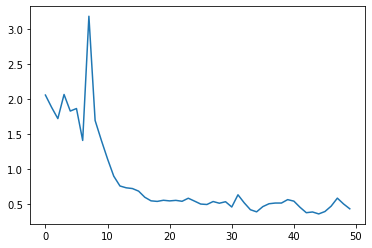

In [66]:
plt.plot(baby_losses)

In [68]:
small_dataset = GraphDatasetGenerateSingleThread(keys=keys[:1000], labels=labels[:1000],cyss=cys_chain_and_idx[:1000],
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='small_1000',
                                       path_marker='/')

Generating graphs ...


 13%|█▎        | 132/1000 [00:00<00:00, 1317.08it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P51790_161.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P14616_191.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P05106_554.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P51693_128.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8N2G4_101.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IW52_242.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P35555_256.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P22607_119.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9BYR8_26.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HCJ2_375.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y219_633.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NGE9_97.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O60284_729.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75095_58

 42%|████▏     | 415/1000 [00:00<00:00, 1393.99it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/A0A0B4J1T7_30.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P54315_322.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q13641_77.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P28799_246.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9BYJ0_72.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O95867_97.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8N2E2_365.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IYR6_299.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P17643_303.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IZA0_85.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P26927_343.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96NT3_167.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P55145_30.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P19022_61

 70%|██████▉   | 699/1000 [00:00<00:00, 1374.05it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P69849_788.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y625_244.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9C0I4_337.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O95754_149.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14766_559.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NGT0_169.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5FYB0_152.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P78504_638.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NR23_264.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O94813_670.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P78504_491.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O43167_492.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NS15_783.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y625_

100%|██████████| 1000/1000 [00:00<00:00, 1297.51it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/O60259_39.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8WWZ8_124.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P19957_104.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P02790_366.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UN88_324.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96IG2_432.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14990_65.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q13444_480.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q16515_171.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8WZ79_196.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P04437_49.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y6R7_207.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96MS0_143.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P0C7H8_79.

In [70]:
np.array(small_dataset.labels).sum()

85

In [71]:
len(small_dataset.labels)

785

In [73]:
small_dataloader = DataLoader(small_dataset, batch_size=128, shuffle=True,
                               collate_fn=collate_fn, drop_last=True)

In [74]:
DeepCoSI_Model_logits_small = DeepCoSIPredictorWithLogits(node_feat_size=94, edge_feat_size=20, num_layers=3,
                                     graph_feat_size=256,
                                     d_FC_layer=256, n_FC_layer=2, dropout=0.)

In [77]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits_small.parameters(), lr=0.0001, weight_decay=0.)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(8))

In [78]:
small_aucs = []
small_accuracies = []
small_losses = []
small_precisions = []
small_recalls = []
small_thresholds = [] 
small_auprcs = [] 
small_num_positive = []

for epoch in tqdm(range(50)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, small_dataloader, optimizer)
    small_true, small_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, small_dataloader)

    small_true = np.concatenate(np.array(small_true), 0)
    small_pred = np.concatenate(np.array(small_pred), 0)
    
    small_loss = loss_fn(torch.tensor(small_pred, dtype=torch.float),
                         torch.tensor(small_true, dtype=torch.float))
    
    small_pred_bin = []
    for x in small_pred[:,0]:
        if x >= 0.:
            small_pred_bin.append([1.])
        else:
            small_pred_bin.append([0.])     
    
    small_auc = roc_auc_score(small_true, small_pred)
    small_aucs.append(small_auc)
    
    small_accuracy = accuracy_score(small_true,small_pred_bin)
    small_accuracies.append(small_accuracy)
                           
    small_precision, small_recall, small_threshold = precision_recall_curve(small_true, small_pred)
    small_precisions.append(small_precision)
    small_recalls.append(small_recall)
    small_thresholds.append(small_threshold)
    small_auprc = auc(small_recall, small_precision)
    small_auprcs.append(small_auprc)

    small_losses.append(small_loss.item())
    
    small_num_positive.append(np.array(small_pred_bin).sum())
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, small_loss.item(), small_loss.item(), small_accuracy, small_accuracy, small_auc, small_auc, small_auprc, small_auprc, small_num_positive[-1], small_num_positive[-1],end - st))
    

  2%|▏         | 1/50 [00:58<48:06, 58.91s/it]

epoch:0 	 train_loss:1.3135 	 valid_loss:1.3135 	 train_accuracy:0.5143 	 valid_accuracy:0.5143 	 train_auc:0.5974 	 valid_auc:0.5974 	 train_auprc:0.1574 	 valid_auprc:0.1574 	 train_num_positive:395.0000 	 valid_num_positive:395.0000 	 time:58.911 s


  4%|▍         | 2/50 [01:57<47:07, 58.91s/it]

epoch:1 	 train_loss:1.2309 	 valid_loss:1.2309 	 train_accuracy:0.5443 	 valid_accuracy:0.5443 	 train_auc:0.6299 	 valid_auc:0.6299 	 train_auprc:0.1817 	 valid_auprc:0.1817 	 train_num_positive:374.0000 	 valid_num_positive:374.0000 	 time:58.909 s


  6%|▌         | 3/50 [02:56<46:00, 58.73s/it]

epoch:2 	 train_loss:1.1845 	 valid_loss:1.1845 	 train_accuracy:0.7917 	 valid_accuracy:0.7917 	 train_auc:0.6452 	 valid_auc:0.6452 	 train_auprc:0.1833 	 valid_auprc:0.1833 	 train_num_positive:128.0000 	 valid_num_positive:128.0000 	 time:58.522 s


  8%|▊         | 4/50 [03:55<45:05, 58.81s/it]

epoch:3 	 train_loss:1.2539 	 valid_loss:1.2539 	 train_accuracy:0.8646 	 valid_accuracy:0.8646 	 train_auc:0.6534 	 valid_auc:0.6534 	 train_auprc:0.1938 	 valid_auprc:0.1938 	 train_num_positive:39.0000 	 valid_num_positive:39.0000 	 time:58.927 s


 10%|█         | 5/50 [04:54<44:08, 58.86s/it]

epoch:4 	 train_loss:1.1094 	 valid_loss:1.1094 	 train_accuracy:0.8216 	 valid_accuracy:0.8216 	 train_auc:0.7255 	 valid_auc:0.7255 	 train_auprc:0.2809 	 valid_auprc:0.2809 	 train_num_positive:114.0000 	 valid_num_positive:114.0000 	 time:58.960 s


 12%|█▏        | 6/50 [05:53<43:09, 58.85s/it]

epoch:5 	 train_loss:1.0516 	 valid_loss:1.0516 	 train_accuracy:0.6927 	 valid_accuracy:0.6927 	 train_auc:0.7536 	 valid_auc:0.7536 	 train_auprc:0.2931 	 valid_auprc:0.2931 	 train_num_positive:272.0000 	 valid_num_positive:272.0000 	 time:58.810 s


 14%|█▍        | 7/50 [06:52<42:12, 58.89s/it]

epoch:6 	 train_loss:1.0412 	 valid_loss:1.0412 	 train_accuracy:0.6641 	 valid_accuracy:0.6641 	 train_auc:0.7619 	 valid_auc:0.7619 	 train_auprc:0.3234 	 valid_auprc:0.3234 	 train_num_positive:299.0000 	 valid_num_positive:299.0000 	 time:58.972 s


 16%|█▌        | 8/50 [07:50<41:06, 58.74s/it]

epoch:7 	 train_loss:1.0773 	 valid_loss:1.0773 	 train_accuracy:0.8099 	 valid_accuracy:0.8099 	 train_auc:0.7509 	 valid_auc:0.7509 	 train_auprc:0.2836 	 valid_auprc:0.2836 	 train_num_positive:150.0000 	 valid_num_positive:150.0000 	 time:58.416 s


 18%|█▊        | 9/50 [08:49<40:08, 58.74s/it]

epoch:8 	 train_loss:1.0666 	 valid_loss:1.0666 	 train_accuracy:0.8477 	 valid_accuracy:0.8477 	 train_auc:0.7841 	 valid_auc:0.7841 	 train_auprc:0.3526 	 valid_auprc:0.3526 	 train_num_positive:99.0000 	 valid_num_positive:99.0000 	 time:58.733 s


 20%|██        | 10/50 [09:47<39:08, 58.72s/it]

epoch:9 	 train_loss:0.9663 	 valid_loss:0.9663 	 train_accuracy:0.8490 	 valid_accuracy:0.8490 	 train_auc:0.8363 	 valid_auc:0.8363 	 train_auprc:0.4811 	 valid_auprc:0.4811 	 train_num_positive:130.0000 	 valid_num_positive:130.0000 	 time:58.694 s


 22%|██▏       | 11/50 [10:46<38:13, 58.80s/it]

epoch:10 	 train_loss:1.0157 	 valid_loss:1.0157 	 train_accuracy:0.8919 	 valid_accuracy:0.8919 	 train_auc:0.8362 	 valid_auc:0.8362 	 train_auprc:0.4914 	 valid_auprc:0.4914 	 train_num_positive:75.0000 	 valid_num_positive:75.0000 	 time:58.970 s


 24%|██▍       | 12/50 [11:45<37:09, 58.68s/it]

epoch:11 	 train_loss:1.0248 	 valid_loss:1.0248 	 train_accuracy:0.9036 	 valid_accuracy:0.9036 	 train_auc:0.8161 	 valid_auc:0.8161 	 train_auprc:0.4609 	 valid_auprc:0.4609 	 train_num_positive:61.0000 	 valid_num_positive:61.0000 	 time:58.416 s


 26%|██▌       | 13/50 [12:44<36:14, 58.78s/it]

epoch:12 	 train_loss:0.9512 	 valid_loss:0.9512 	 train_accuracy:0.8685 	 valid_accuracy:0.8685 	 train_auc:0.8650 	 valid_auc:0.8650 	 train_auprc:0.4734 	 valid_auprc:0.4734 	 train_num_positive:119.0000 	 valid_num_positive:119.0000 	 time:59.009 s


 28%|██▊       | 14/50 [13:43<35:16, 58.78s/it]

epoch:13 	 train_loss:0.8874 	 valid_loss:0.8874 	 train_accuracy:0.8867 	 valid_accuracy:0.8867 	 train_auc:0.8765 	 valid_auc:0.8765 	 train_auprc:0.5550 	 valid_auprc:0.5550 	 train_num_positive:111.0000 	 valid_num_positive:111.0000 	 time:58.790 s


 30%|███       | 15/50 [14:41<34:15, 58.73s/it]

epoch:14 	 train_loss:0.8700 	 valid_loss:0.8700 	 train_accuracy:0.7852 	 valid_accuracy:0.7852 	 train_auc:0.8658 	 valid_auc:0.8658 	 train_auprc:0.5177 	 valid_auprc:0.5177 	 train_num_positive:214.0000 	 valid_num_positive:214.0000 	 time:58.603 s


 32%|███▏      | 16/50 [15:40<33:14, 58.65s/it]

epoch:15 	 train_loss:0.9234 	 valid_loss:0.9234 	 train_accuracy:0.6159 	 valid_accuracy:0.6159 	 train_auc:0.8645 	 valid_auc:0.8645 	 train_auprc:0.5149 	 valid_auprc:0.5149 	 train_num_positive:371.0000 	 valid_num_positive:371.0000 	 time:58.466 s


 34%|███▍      | 17/50 [16:38<32:16, 58.67s/it]

epoch:16 	 train_loss:0.7880 	 valid_loss:0.7880 	 train_accuracy:0.8229 	 valid_accuracy:0.8229 	 train_auc:0.9295 	 valid_auc:0.9295 	 train_auprc:0.6802 	 valid_auprc:0.6802 	 train_num_positive:209.0000 	 valid_num_positive:209.0000 	 time:58.719 s


 36%|███▌      | 18/50 [17:37<31:16, 58.65s/it]

epoch:17 	 train_loss:0.7717 	 valid_loss:0.7717 	 train_accuracy:0.8242 	 valid_accuracy:0.8242 	 train_auc:0.9310 	 valid_auc:0.9310 	 train_auprc:0.6399 	 valid_auprc:0.6399 	 train_num_positive:194.0000 	 valid_num_positive:194.0000 	 time:58.595 s


 38%|███▊      | 19/50 [18:35<30:16, 58.59s/it]

epoch:18 	 train_loss:0.8457 	 valid_loss:0.8457 	 train_accuracy:0.6315 	 valid_accuracy:0.6315 	 train_auc:0.9085 	 valid_auc:0.9085 	 train_auprc:0.6154 	 valid_auprc:0.6154 	 train_num_positive:363.0000 	 valid_num_positive:363.0000 	 time:58.440 s


 40%|████      | 20/50 [19:35<29:23, 58.77s/it]

epoch:19 	 train_loss:0.8264 	 valid_loss:0.8264 	 train_accuracy:0.6523 	 valid_accuracy:0.6523 	 train_auc:0.9116 	 valid_auc:0.9116 	 train_auprc:0.6220 	 valid_auprc:0.6220 	 train_num_positive:346.0000 	 valid_num_positive:346.0000 	 time:59.192 s


 42%|████▏     | 21/50 [20:33<28:25, 58.81s/it]

epoch:20 	 train_loss:0.7394 	 valid_loss:0.7394 	 train_accuracy:0.8464 	 valid_accuracy:0.8464 	 train_auc:0.9084 	 valid_auc:0.9084 	 train_auprc:0.6909 	 valid_auprc:0.6909 	 train_num_positive:176.0000 	 valid_num_positive:176.0000 	 time:58.916 s


 44%|████▍     | 22/50 [21:23<26:10, 56.09s/it]

epoch:21 	 train_loss:0.7297 	 valid_loss:0.7297 	 train_accuracy:0.7292 	 valid_accuracy:0.7292 	 train_auc:0.9489 	 valid_auc:0.9489 	 train_auprc:0.7820 	 valid_auprc:0.7820 	 train_num_positive:285.0000 	 valid_num_positive:285.0000 	 time:49.728 s


 46%|████▌     | 23/50 [22:10<23:55, 53.16s/it]

epoch:22 	 train_loss:0.8103 	 valid_loss:0.8103 	 train_accuracy:0.8906 	 valid_accuracy:0.8906 	 train_auc:0.8930 	 valid_auc:0.8930 	 train_auprc:0.6131 	 valid_auprc:0.6131 	 train_num_positive:105.0000 	 valid_num_positive:105.0000 	 time:46.332 s


 48%|████▊     | 24/50 [22:55<22:05, 50.97s/it]

epoch:23 	 train_loss:0.9239 	 valid_loss:0.9239 	 train_accuracy:0.5326 	 valid_accuracy:0.5326 	 train_auc:0.9327 	 valid_auc:0.9327 	 train_auprc:0.6892 	 valid_auprc:0.6892 	 train_num_positive:443.0000 	 valid_num_positive:443.0000 	 time:45.864 s


 50%|█████     | 25/50 [23:42<20:37, 49.51s/it]

epoch:24 	 train_loss:0.9258 	 valid_loss:0.9258 	 train_accuracy:0.6784 	 valid_accuracy:0.6784 	 train_auc:0.8516 	 valid_auc:0.8516 	 train_auprc:0.4028 	 valid_auprc:0.4028 	 train_num_positive:315.0000 	 valid_num_positive:315.0000 	 time:46.090 s


 52%|█████▏    | 26/50 [24:28<19:25, 48.57s/it]

epoch:25 	 train_loss:4.2353 	 valid_loss:4.2353 	 train_accuracy:0.2643 	 valid_accuracy:0.2643 	 train_auc:0.6811 	 valid_auc:0.6811 	 train_auprc:0.1830 	 valid_auprc:0.1830 	 train_num_positive:649.0000 	 valid_num_positive:649.0000 	 time:46.369 s


 54%|█████▍    | 27/50 [25:14<18:21, 47.91s/it]

epoch:26 	 train_loss:0.9707 	 valid_loss:0.9707 	 train_accuracy:0.5990 	 valid_accuracy:0.5990 	 train_auc:0.8822 	 valid_auc:0.8822 	 train_auprc:0.4392 	 valid_auprc:0.4392 	 train_num_positive:384.0000 	 valid_num_positive:384.0000 	 time:46.374 s


 56%|█████▌    | 28/50 [26:00<17:21, 47.36s/it]

epoch:27 	 train_loss:1.1312 	 valid_loss:1.1312 	 train_accuracy:0.4766 	 valid_accuracy:0.4766 	 train_auc:0.8664 	 valid_auc:0.8664 	 train_auprc:0.3886 	 valid_auprc:0.3886 	 train_num_positive:480.0000 	 valid_num_positive:480.0000 	 time:46.081 s


 58%|█████▊    | 29/50 [26:47<16:28, 47.07s/it]

epoch:28 	 train_loss:1.0376 	 valid_loss:1.0376 	 train_accuracy:0.4948 	 valid_accuracy:0.4948 	 train_auc:0.9008 	 valid_auc:0.9008 	 train_auprc:0.4691 	 valid_auprc:0.4691 	 train_num_positive:470.0000 	 valid_num_positive:470.0000 	 time:46.382 s


 60%|██████    | 30/50 [27:33<15:35, 46.79s/it]

epoch:29 	 train_loss:2.2382 	 valid_loss:2.2382 	 train_accuracy:0.2201 	 valid_accuracy:0.2201 	 train_auc:0.8210 	 valid_auc:0.8210 	 train_auprc:0.3442 	 valid_auprc:0.3442 	 train_num_positive:681.0000 	 valid_num_positive:681.0000 	 time:46.156 s


 62%|██████▏   | 31/50 [28:19<14:46, 46.65s/it]

epoch:30 	 train_loss:0.9169 	 valid_loss:0.9169 	 train_accuracy:0.6172 	 valid_accuracy:0.6172 	 train_auc:0.8446 	 valid_auc:0.8446 	 train_auprc:0.4924 	 valid_auprc:0.4924 	 train_num_positive:358.0000 	 valid_num_positive:358.0000 	 time:46.326 s


 64%|██████▍   | 32/50 [29:05<13:56, 46.47s/it]

epoch:31 	 train_loss:0.7066 	 valid_loss:0.7066 	 train_accuracy:0.7057 	 valid_accuracy:0.7057 	 train_auc:0.9643 	 valid_auc:0.9643 	 train_auprc:0.7803 	 valid_auprc:0.7803 	 train_num_positive:311.0000 	 valid_num_positive:311.0000 	 time:46.027 s


 66%|██████▌   | 33/50 [29:51<13:07, 46.30s/it]

epoch:32 	 train_loss:0.6107 	 valid_loss:0.6107 	 train_accuracy:0.8607 	 valid_accuracy:0.8607 	 train_auc:0.9841 	 valid_auc:0.9841 	 train_auprc:0.8811 	 valid_auprc:0.8811 	 train_num_positive:190.0000 	 valid_num_positive:190.0000 	 time:45.928 s


 68%|██████▊   | 34/50 [30:37<12:19, 46.20s/it]

epoch:33 	 train_loss:0.6302 	 valid_loss:0.6302 	 train_accuracy:0.9375 	 valid_accuracy:0.9375 	 train_auc:0.9671 	 valid_auc:0.9671 	 train_auprc:0.8421 	 valid_auprc:0.8421 	 train_num_positive:108.0000 	 valid_num_positive:108.0000 	 time:45.942 s


 70%|███████   | 35/50 [31:24<11:34, 46.27s/it]

epoch:34 	 train_loss:0.7093 	 valid_loss:0.7093 	 train_accuracy:0.8633 	 valid_accuracy:0.8633 	 train_auc:0.9252 	 valid_auc:0.9252 	 train_auprc:0.6191 	 valid_auprc:0.6191 	 train_num_positive:169.0000 	 valid_num_positive:169.0000 	 time:46.436 s


 72%|███████▏  | 36/50 [32:10<10:47, 46.26s/it]

epoch:35 	 train_loss:0.6336 	 valid_loss:0.6336 	 train_accuracy:0.7760 	 valid_accuracy:0.7760 	 train_auc:0.9773 	 valid_auc:0.9773 	 train_auprc:0.8630 	 valid_auprc:0.8630 	 train_num_positive:256.0000 	 valid_num_positive:256.0000 	 time:46.249 s


 74%|███████▍  | 37/50 [32:56<10:01, 46.27s/it]

epoch:36 	 train_loss:0.6339 	 valid_loss:0.6339 	 train_accuracy:0.7721 	 valid_accuracy:0.7721 	 train_auc:0.9625 	 valid_auc:0.9625 	 train_auprc:0.8201 	 valid_auprc:0.8201 	 train_num_positive:255.0000 	 valid_num_positive:255.0000 	 time:46.298 s


 76%|███████▌  | 38/50 [33:42<09:14, 46.22s/it]

epoch:37 	 train_loss:0.6484 	 valid_loss:0.6484 	 train_accuracy:0.7240 	 valid_accuracy:0.7240 	 train_auc:0.9635 	 valid_auc:0.9635 	 train_auprc:0.8147 	 valid_auprc:0.8147 	 train_num_positive:294.0000 	 valid_num_positive:294.0000 	 time:46.102 s


 78%|███████▊  | 39/50 [34:28<08:28, 46.19s/it]

epoch:38 	 train_loss:0.6517 	 valid_loss:0.6517 	 train_accuracy:0.7852 	 valid_accuracy:0.7852 	 train_auc:0.9502 	 valid_auc:0.9502 	 train_auprc:0.6585 	 valid_auprc:0.6585 	 train_num_positive:249.0000 	 valid_num_positive:249.0000 	 time:46.103 s


 80%|████████  | 40/50 [35:15<07:43, 46.31s/it]

epoch:39 	 train_loss:0.7015 	 valid_loss:0.7015 	 train_accuracy:0.7031 	 valid_accuracy:0.7031 	 train_auc:0.9646 	 valid_auc:0.9646 	 train_auprc:0.7521 	 valid_auprc:0.7521 	 train_num_positive:310.0000 	 valid_num_positive:310.0000 	 time:46.610 s


 82%|████████▏ | 41/50 [36:01<06:55, 46.20s/it]

epoch:40 	 train_loss:0.6301 	 valid_loss:0.6301 	 train_accuracy:0.9440 	 valid_accuracy:0.9440 	 train_auc:0.9604 	 valid_auc:0.9604 	 train_auprc:0.7834 	 valid_auprc:0.7834 	 train_num_positive:88.0000 	 valid_num_positive:88.0000 	 time:45.924 s


 84%|████████▍ | 42/50 [36:47<06:09, 46.20s/it]

epoch:41 	 train_loss:0.5415 	 valid_loss:0.5415 	 train_accuracy:0.8255 	 valid_accuracy:0.8255 	 train_auc:0.9802 	 valid_auc:0.9802 	 train_auprc:0.8604 	 valid_auprc:0.8604 	 train_num_positive:217.0000 	 valid_num_positive:217.0000 	 time:46.196 s


 86%|████████▌ | 43/50 [37:33<05:23, 46.27s/it]

epoch:42 	 train_loss:0.4568 	 valid_loss:0.4568 	 train_accuracy:0.8841 	 valid_accuracy:0.8841 	 train_auc:0.9937 	 valid_auc:0.9937 	 train_auprc:0.9492 	 valid_auprc:0.9492 	 train_num_positive:173.0000 	 valid_num_positive:173.0000 	 time:46.436 s


 88%|████████▊ | 44/50 [38:20<04:37, 46.29s/it]

epoch:43 	 train_loss:0.7049 	 valid_loss:0.7049 	 train_accuracy:0.7812 	 valid_accuracy:0.7812 	 train_auc:0.9328 	 valid_auc:0.9328 	 train_auprc:0.6765 	 valid_auprc:0.6765 	 train_num_positive:245.0000 	 valid_num_positive:245.0000 	 time:46.331 s


 90%|█████████ | 45/50 [39:06<03:51, 46.32s/it]

epoch:44 	 train_loss:0.6697 	 valid_loss:0.6697 	 train_accuracy:0.6836 	 valid_accuracy:0.6836 	 train_auc:0.9796 	 valid_auc:0.9796 	 train_auprc:0.8849 	 valid_auprc:0.8849 	 train_num_positive:325.0000 	 valid_num_positive:325.0000 	 time:46.388 s


 92%|█████████▏| 46/50 [39:53<03:05, 46.40s/it]

epoch:45 	 train_loss:0.5999 	 valid_loss:0.5999 	 train_accuracy:0.7878 	 valid_accuracy:0.7878 	 train_auc:0.9635 	 valid_auc:0.9635 	 train_auprc:0.8242 	 valid_auprc:0.8242 	 train_num_positive:246.0000 	 valid_num_positive:246.0000 	 time:46.586 s


 94%|█████████▍| 47/50 [40:39<02:19, 46.39s/it]

epoch:46 	 train_loss:0.5822 	 valid_loss:0.5822 	 train_accuracy:0.7721 	 valid_accuracy:0.7721 	 train_auc:0.9833 	 valid_auc:0.9833 	 train_auprc:0.8720 	 valid_auprc:0.8720 	 train_num_positive:259.0000 	 valid_num_positive:259.0000 	 time:46.365 s


 96%|█████████▌| 48/50 [41:26<01:32, 46.46s/it]

epoch:47 	 train_loss:1.3257 	 valid_loss:1.3257 	 train_accuracy:0.4635 	 valid_accuracy:0.4635 	 train_auc:0.9563 	 valid_auc:0.9563 	 train_auprc:0.7665 	 valid_auprc:0.7665 	 train_num_positive:495.0000 	 valid_num_positive:495.0000 	 time:46.630 s


 98%|█████████▊| 49/50 [42:12<00:46, 46.49s/it]

epoch:48 	 train_loss:1.5328 	 valid_loss:1.5328 	 train_accuracy:0.4414 	 valid_accuracy:0.4414 	 train_auc:0.9087 	 valid_auc:0.9087 	 train_auprc:0.4912 	 valid_auprc:0.4912 	 train_num_positive:512.0000 	 valid_num_positive:512.0000 	 time:46.544 s


100%|██████████| 50/50 [42:59<00:00, 51.58s/it]

epoch:49 	 train_loss:0.6740 	 valid_loss:0.6740 	 train_accuracy:0.7435 	 valid_accuracy:0.7435 	 train_auc:0.9564 	 valid_auc:0.9564 	 train_auprc:0.7464 	 valid_auprc:0.7464 	 train_num_positive:277.0000 	 valid_num_positive:277.0000 	 time:46.394 s


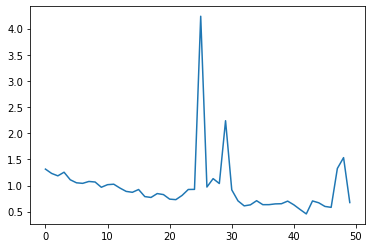

In [79]:
plt.plot(small_losses)

In [80]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits_small.parameters(), lr=0.000025, weight_decay=0.)


In [81]:
for epoch in tqdm(range(20)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, small_dataloader, optimizer)
    small_true, small_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, small_dataloader)

    small_true = np.concatenate(np.array(small_true), 0)
    small_pred = np.concatenate(np.array(small_pred), 0)
    
    small_loss = loss_fn(torch.tensor(small_pred, dtype=torch.float),
                         torch.tensor(small_true, dtype=torch.float))
    
    small_pred_bin = []
    for x in small_pred[:,0]:
        if x >= 0.:
            small_pred_bin.append([1.])
        else:
            small_pred_bin.append([0.])     
    
    small_auc = roc_auc_score(small_true, small_pred)
    small_aucs.append(small_auc)
    
    small_accuracy = accuracy_score(small_true,small_pred_bin)
    small_accuracies.append(small_accuracy)
                           
    small_precision, small_recall, small_threshold = precision_recall_curve(small_true, small_pred)
    small_precisions.append(small_precision)
    small_recalls.append(small_recall)
    small_thresholds.append(small_threshold)
    small_auprc = auc(small_recall, small_precision)
    small_auprcs.append(small_auprc)

    small_losses.append(small_loss.item())
    
    small_num_positive.append(np.array(small_pred_bin).sum())
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, small_loss.item(), small_loss.item(), small_accuracy, small_accuracy, small_auc, small_auc, small_auprc, small_auprc, small_num_positive[-1], small_num_positive[-1],end - st))
    

  5%|▌         | 1/20 [00:45<14:19, 45.22s/it]

epoch:0 	 train_loss:0.4299 	 valid_loss:0.4299 	 train_accuracy:0.9076 	 valid_accuracy:0.9076 	 train_auc:0.9907 	 valid_auc:0.9907 	 train_auprc:0.8831 	 valid_auprc:0.8831 	 train_num_positive:152.0000 	 valid_num_positive:152.0000 	 time:45.217 s


 10%|█         | 2/20 [01:30<13:37, 45.42s/it]

epoch:1 	 train_loss:0.3601 	 valid_loss:0.3601 	 train_accuracy:0.9479 	 valid_accuracy:0.9479 	 train_auc:0.9980 	 valid_auc:0.9980 	 train_auprc:0.9503 	 valid_auprc:0.9503 	 train_num_positive:122.0000 	 valid_num_positive:122.0000 	 time:45.560 s


 15%|█▌        | 3/20 [02:16<12:55, 45.65s/it]

epoch:2 	 train_loss:0.4487 	 valid_loss:0.4487 	 train_accuracy:0.8424 	 valid_accuracy:0.8424 	 train_auc:0.9954 	 valid_auc:0.9954 	 train_auprc:0.9679 	 valid_auprc:0.9679 	 train_num_positive:203.0000 	 valid_num_positive:203.0000 	 time:45.917 s


 20%|██        | 4/20 [03:02<12:13, 45.85s/it]

epoch:3 	 train_loss:0.5476 	 valid_loss:0.5476 	 train_accuracy:0.7734 	 valid_accuracy:0.7734 	 train_auc:0.9938 	 valid_auc:0.9938 	 train_auprc:0.9604 	 valid_auprc:0.9604 	 train_num_positive:256.0000 	 valid_num_positive:256.0000 	 time:46.149 s


 25%|██▌       | 5/20 [03:49<11:29, 45.96s/it]

epoch:4 	 train_loss:0.3373 	 valid_loss:0.3373 	 train_accuracy:0.9284 	 valid_accuracy:0.9284 	 train_auc:0.9997 	 valid_auc:0.9997 	 train_auprc:0.9973 	 valid_auprc:0.9973 	 train_num_positive:139.0000 	 valid_num_positive:139.0000 	 time:46.161 s


 30%|███       | 6/20 [04:35<10:44, 46.04s/it]

epoch:5 	 train_loss:0.4352 	 valid_loss:0.4352 	 train_accuracy:0.8346 	 valid_accuracy:0.8346 	 train_auc:0.9997 	 valid_auc:0.9997 	 train_auprc:0.9975 	 valid_auprc:0.9975 	 train_num_positive:210.0000 	 valid_num_positive:210.0000 	 time:46.201 s


 35%|███▌      | 7/20 [05:21<09:59, 46.12s/it]

epoch:6 	 train_loss:0.4993 	 valid_loss:0.4993 	 train_accuracy:0.7773 	 valid_accuracy:0.7773 	 train_auc:0.9996 	 valid_auc:0.9996 	 train_auprc:0.9969 	 valid_auprc:0.9969 	 train_num_positive:254.0000 	 valid_num_positive:254.0000 	 time:46.293 s


 40%|████      | 8/20 [06:07<09:13, 46.11s/it]

epoch:7 	 train_loss:0.3467 	 valid_loss:0.3467 	 train_accuracy:0.8997 	 valid_accuracy:0.8997 	 train_auc:0.9998 	 valid_auc:0.9998 	 train_auprc:0.9980 	 valid_auprc:0.9980 	 train_num_positive:160.0000 	 valid_num_positive:160.0000 	 time:46.093 s


 45%|████▌     | 9/20 [06:53<08:27, 46.15s/it]

epoch:8 	 train_loss:0.2976 	 valid_loss:0.2976 	 train_accuracy:0.9518 	 valid_accuracy:0.9518 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:120.0000 	 valid_num_positive:120.0000 	 time:46.235 s


 50%|█████     | 10/20 [07:40<07:43, 46.40s/it]

epoch:9 	 train_loss:0.2582 	 valid_loss:0.2582 	 train_accuracy:0.9779 	 valid_accuracy:0.9779 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:101.0000 	 valid_num_positive:101.0000 	 time:46.947 s


 55%|█████▌    | 11/20 [08:26<06:57, 46.34s/it]

epoch:10 	 train_loss:0.3500 	 valid_loss:0.3500 	 train_accuracy:0.9206 	 valid_accuracy:0.9206 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:143.0000 	 valid_num_positive:143.0000 	 time:46.201 s


 60%|██████    | 12/20 [09:12<06:09, 46.21s/it]

epoch:11 	 train_loss:0.3841 	 valid_loss:0.3841 	 train_accuracy:0.8932 	 valid_accuracy:0.8932 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:0.9999 	 valid_auprc:0.9999 	 train_num_positive:164.0000 	 valid_num_positive:164.0000 	 time:45.916 s


 65%|██████▌   | 13/20 [09:59<05:23, 46.19s/it]

epoch:12 	 train_loss:0.2687 	 valid_loss:0.2687 	 train_accuracy:0.9818 	 valid_accuracy:0.9818 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:97.0000 	 valid_num_positive:97.0000 	 time:46.131 s


 70%|███████   | 14/20 [10:45<04:38, 46.42s/it]

epoch:13 	 train_loss:0.4255 	 valid_loss:0.4255 	 train_accuracy:0.8464 	 valid_accuracy:0.8464 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:0.9997 	 valid_auprc:0.9997 	 train_num_positive:202.0000 	 valid_num_positive:202.0000 	 time:46.963 s


 75%|███████▌  | 15/20 [11:32<03:51, 46.31s/it]

epoch:14 	 train_loss:0.3044 	 valid_loss:0.3044 	 train_accuracy:0.9505 	 valid_accuracy:0.9505 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:123.0000 	 valid_num_positive:123.0000 	 time:46.053 s


 80%|████████  | 16/20 [12:18<03:05, 46.29s/it]

epoch:15 	 train_loss:0.3398 	 valid_loss:0.3398 	 train_accuracy:0.9219 	 valid_accuracy:0.9219 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:0.9997 	 valid_auprc:0.9997 	 train_num_positive:144.0000 	 valid_num_positive:144.0000 	 time:46.250 s


 85%|████████▌ | 17/20 [13:04<02:18, 46.19s/it]

epoch:16 	 train_loss:0.3762 	 valid_loss:0.3762 	 train_accuracy:0.8880 	 valid_accuracy:0.8880 	 train_auc:0.9983 	 valid_auc:0.9983 	 train_auprc:0.9845 	 valid_auprc:0.9845 	 train_num_positive:170.0000 	 valid_num_positive:170.0000 	 time:45.939 s


 90%|█████████ | 18/20 [13:49<01:32, 46.04s/it]

epoch:17 	 train_loss:0.3288 	 valid_loss:0.3288 	 train_accuracy:0.9466 	 valid_accuracy:0.9466 	 train_auc:0.9965 	 valid_auc:0.9965 	 train_auprc:0.9670 	 valid_auprc:0.9670 	 train_num_positive:125.0000 	 valid_num_positive:125.0000 	 time:45.712 s


 95%|█████████▌| 19/20 [14:35<00:46, 46.04s/it]

epoch:18 	 train_loss:0.3397 	 valid_loss:0.3397 	 train_accuracy:0.9323 	 valid_accuracy:0.9323 	 train_auc:0.9979 	 valid_auc:0.9979 	 train_auprc:0.9765 	 valid_auprc:0.9765 	 train_num_positive:133.0000 	 valid_num_positive:133.0000 	 time:46.018 s


100%|██████████| 20/20 [15:21<00:00, 46.09s/it]

epoch:19 	 train_loss:0.4192 	 valid_loss:0.4192 	 train_accuracy:0.8516 	 valid_accuracy:0.8516 	 train_auc:0.9980 	 valid_auc:0.9980 	 train_auprc:0.9791 	 valid_auprc:0.9791 	 train_num_positive:197.0000 	 valid_num_positive:197.0000 	 time:45.815 s


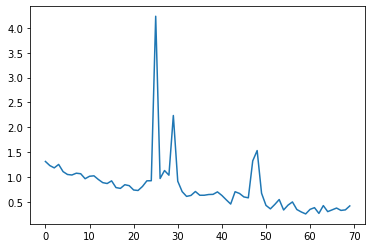

In [82]:
plt.plot(small_losses)

In [83]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits_small.parameters(), lr=0.000005, weight_decay=0.)

In [84]:
for epoch in tqdm(range(20)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, small_dataloader, optimizer)
    small_true, small_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, small_dataloader)

    small_true = np.concatenate(np.array(small_true), 0)
    small_pred = np.concatenate(np.array(small_pred), 0)
    
    small_loss = loss_fn(torch.tensor(small_pred, dtype=torch.float),
                         torch.tensor(small_true, dtype=torch.float))
    
    small_pred_bin = []
    for x in small_pred[:,0]:
        if x >= 0.:
            small_pred_bin.append([1.])
        else:
            small_pred_bin.append([0.])     
    
    small_auc = roc_auc_score(small_true, small_pred)
    small_aucs.append(small_auc)
    
    small_accuracy = accuracy_score(small_true,small_pred_bin)
    small_accuracies.append(small_accuracy)
                           
    small_precision, small_recall, small_threshold = precision_recall_curve(small_true, small_pred)
    small_precisions.append(small_precision)
    small_recalls.append(small_recall)
    small_thresholds.append(small_threshold)
    small_auprc = auc(small_recall, small_precision)
    small_auprcs.append(small_auprc)

    small_losses.append(small_loss.item())
    
    small_num_positive.append(np.array(small_pred_bin).sum())
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, small_loss.item(), small_loss.item(), small_accuracy, small_accuracy, small_auc, small_auc, small_auprc, small_auprc, small_num_positive[-1], small_num_positive[-1],end - st))
    

  5%|▌         | 1/20 [00:48<15:16, 48.21s/it]

epoch:0 	 train_loss:0.3111 	 valid_loss:0.3111 	 train_accuracy:0.9531 	 valid_accuracy:0.9531 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:118.0000 	 valid_num_positive:118.0000 	 time:48.215 s


 10%|█         | 2/20 [01:34<14:04, 46.94s/it]

epoch:1 	 train_loss:0.2838 	 valid_loss:0.2838 	 train_accuracy:0.9753 	 valid_accuracy:0.9753 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:103.0000 	 valid_num_positive:103.0000 	 time:46.038 s


 15%|█▌        | 3/20 [02:20<13:14, 46.75s/it]

epoch:2 	 train_loss:0.2780 	 valid_loss:0.2780 	 train_accuracy:0.9792 	 valid_accuracy:0.9792 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:100.0000 	 valid_num_positive:100.0000 	 time:46.533 s


 20%|██        | 4/20 [03:07<12:30, 46.91s/it]

epoch:3 	 train_loss:0.3035 	 valid_loss:0.3035 	 train_accuracy:0.9635 	 valid_accuracy:0.9635 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:112.0000 	 valid_num_positive:112.0000 	 time:47.160 s


 25%|██▌       | 5/20 [03:55<11:46, 47.12s/it]

epoch:4 	 train_loss:0.2956 	 valid_loss:0.2956 	 train_accuracy:0.9622 	 valid_accuracy:0.9622 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:113.0000 	 valid_num_positive:113.0000 	 time:47.481 s


 30%|███       | 6/20 [04:42<11:00, 47.20s/it]

epoch:5 	 train_loss:0.2741 	 valid_loss:0.2741 	 train_accuracy:0.9792 	 valid_accuracy:0.9792 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:98.0000 	 valid_num_positive:98.0000 	 time:47.370 s


 35%|███▌      | 7/20 [05:29<10:12, 47.12s/it]

epoch:6 	 train_loss:0.2625 	 valid_loss:0.2625 	 train_accuracy:0.9818 	 valid_accuracy:0.9818 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:96.0000 	 valid_num_positive:96.0000 	 time:46.940 s


 40%|████      | 8/20 [06:16<09:24, 47.07s/it]

epoch:7 	 train_loss:0.2670 	 valid_loss:0.2670 	 train_accuracy:0.9792 	 valid_accuracy:0.9792 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:99.0000 	 valid_num_positive:99.0000 	 time:46.955 s


 45%|████▌     | 9/20 [07:02<08:35, 46.82s/it]

epoch:8 	 train_loss:0.2718 	 valid_loss:0.2718 	 train_accuracy:0.9766 	 valid_accuracy:0.9766 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:102.0000 	 valid_num_positive:102.0000 	 time:46.279 s


 50%|█████     | 10/20 [07:49<07:46, 46.64s/it]

epoch:9 	 train_loss:0.2588 	 valid_loss:0.2588 	 train_accuracy:0.9870 	 valid_accuracy:0.9870 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:92.0000 	 valid_num_positive:92.0000 	 time:46.241 s


 55%|█████▌    | 11/20 [08:35<06:58, 46.50s/it]

epoch:10 	 train_loss:0.2573 	 valid_loss:0.2573 	 train_accuracy:0.9857 	 valid_accuracy:0.9857 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:93.0000 	 valid_num_positive:93.0000 	 time:46.170 s


 60%|██████    | 12/20 [09:21<06:11, 46.50s/it]

epoch:11 	 train_loss:0.2792 	 valid_loss:0.2792 	 train_accuracy:0.9740 	 valid_accuracy:0.9740 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:103.0000 	 valid_num_positive:103.0000 	 time:46.496 s


 65%|██████▌   | 13/20 [10:08<05:24, 46.41s/it]

epoch:12 	 train_loss:0.2929 	 valid_loss:0.2929 	 train_accuracy:0.9570 	 valid_accuracy:0.9570 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:117.0000 	 valid_num_positive:117.0000 	 time:46.209 s


 65%|██████▌   | 13/20 [10:52<05:51, 50.19s/it]


KeyboardInterrupt: 

In [85]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits_small.parameters(), lr=0.000001, weight_decay=0.)

In [86]:
for epoch in tqdm(range(20)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, small_dataloader, optimizer)
    small_true, small_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, small_dataloader)

    small_true = np.concatenate(np.array(small_true), 0)
    small_pred = np.concatenate(np.array(small_pred), 0)
    
    small_loss = loss_fn(torch.tensor(small_pred, dtype=torch.float),
                         torch.tensor(small_true, dtype=torch.float))
    
    small_pred_bin = []
    for x in small_pred[:,0]:
        if x >= 0.:
            small_pred_bin.append([1.])
        else:
            small_pred_bin.append([0.])     
    
    small_auc = roc_auc_score(small_true, small_pred)
    small_aucs.append(small_auc)
    
    small_accuracy = accuracy_score(small_true,small_pred_bin)
    small_accuracies.append(small_accuracy)
                           
    small_precision, small_recall, small_threshold = precision_recall_curve(small_true, small_pred)
    small_precisions.append(small_precision)
    small_recalls.append(small_recall)
    small_thresholds.append(small_threshold)
    small_auprc = auc(small_recall, small_precision)
    small_auprcs.append(small_auprc)

    small_losses.append(small_loss.item())
    
    small_num_positive.append(np.array(small_pred_bin).sum())
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, small_loss.item(), small_loss.item(), small_accuracy, small_accuracy, small_auc, small_auc, small_auprc, small_auprc, small_num_positive[-1], small_num_positive[-1],end - st))

  5%|▌         | 1/20 [00:45<14:29, 45.78s/it]

epoch:0 	 train_loss:0.2688 	 valid_loss:0.2688 	 train_accuracy:0.9818 	 valid_accuracy:0.9818 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:98.0000 	 valid_num_positive:98.0000 	 time:45.781 s


 10%|█         | 2/20 [01:31<13:44, 45.83s/it]

epoch:1 	 train_loss:0.2596 	 valid_loss:0.2596 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:95.0000 	 valid_num_positive:95.0000 	 time:45.869 s


 15%|█▌        | 3/20 [02:17<13:01, 45.96s/it]

epoch:2 	 train_loss:0.2590 	 valid_loss:0.2590 	 train_accuracy:0.9857 	 valid_accuracy:0.9857 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:93.0000 	 valid_num_positive:93.0000 	 time:46.112 s


 20%|██        | 4/20 [03:03<12:15, 45.98s/it]

epoch:3 	 train_loss:0.2561 	 valid_loss:0.2561 	 train_accuracy:0.9883 	 valid_accuracy:0.9883 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:92.0000 	 valid_num_positive:92.0000 	 time:45.997 s


 25%|██▌       | 5/20 [03:49<11:28, 45.90s/it]

epoch:4 	 train_loss:0.2559 	 valid_loss:0.2559 	 train_accuracy:0.9883 	 valid_accuracy:0.9883 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:91.0000 	 valid_num_positive:91.0000 	 time:45.766 s


 30%|███       | 6/20 [04:35<10:42, 45.88s/it]

epoch:5 	 train_loss:0.2520 	 valid_loss:0.2520 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:90.0000 	 valid_num_positive:90.0000 	 time:45.848 s


 35%|███▌      | 7/20 [05:21<09:55, 45.80s/it]

epoch:6 	 train_loss:0.2532 	 valid_loss:0.2532 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:90.0000 	 valid_num_positive:90.0000 	 time:45.625 s


 40%|████      | 8/20 [06:07<09:10, 45.88s/it]

epoch:7 	 train_loss:0.2519 	 valid_loss:0.2519 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:92.0000 	 valid_num_positive:92.0000 	 time:46.051 s


 45%|████▌     | 9/20 [06:53<08:27, 46.12s/it]

epoch:8 	 train_loss:0.2580 	 valid_loss:0.2580 	 train_accuracy:0.9870 	 valid_accuracy:0.9870 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:90.0000 	 valid_num_positive:90.0000 	 time:46.653 s


 50%|█████     | 10/20 [07:40<07:43, 46.34s/it]

epoch:9 	 train_loss:0.2569 	 valid_loss:0.2569 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:91.0000 	 valid_num_positive:91.0000 	 time:46.823 s


 55%|█████▌    | 11/20 [08:26<06:56, 46.24s/it]

epoch:10 	 train_loss:0.2551 	 valid_loss:0.2551 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:90.0000 	 valid_num_positive:90.0000 	 time:46.029 s


 60%|██████    | 12/20 [09:12<06:09, 46.20s/it]

epoch:11 	 train_loss:0.2582 	 valid_loss:0.2582 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:92.0000 	 valid_num_positive:92.0000 	 time:46.100 s


 65%|██████▌   | 13/20 [09:59<05:23, 46.27s/it]

epoch:12 	 train_loss:0.2651 	 valid_loss:0.2651 	 train_accuracy:0.9857 	 valid_accuracy:0.9857 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:94.0000 	 valid_num_positive:94.0000 	 time:46.418 s


 65%|██████▌   | 13/20 [10:21<05:34, 47.81s/it]


KeyboardInterrupt: 

In [87]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits_small.parameters(), lr=0.0000002, weight_decay=0.)

In [88]:
for epoch in tqdm(range(20)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, small_dataloader, optimizer)
    small_true, small_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, small_dataloader)

    small_true = np.concatenate(np.array(small_true), 0)
    small_pred = np.concatenate(np.array(small_pred), 0)
    
    small_loss = loss_fn(torch.tensor(small_pred, dtype=torch.float),
                         torch.tensor(small_true, dtype=torch.float))
    
    small_pred_bin = []
    for x in small_pred[:,0]:
        if x >= 0.:
            small_pred_bin.append([1.])
        else:
            small_pred_bin.append([0.])     
    
    small_auc = roc_auc_score(small_true, small_pred)
    small_aucs.append(small_auc)
    
    small_accuracy = accuracy_score(small_true,small_pred_bin)
    small_accuracies.append(small_accuracy)
                           
    small_precision, small_recall, small_threshold = precision_recall_curve(small_true, small_pred)
    small_precisions.append(small_precision)
    small_recalls.append(small_recall)
    small_thresholds.append(small_threshold)
    small_auprc = auc(small_recall, small_precision)
    small_auprcs.append(small_auprc)

    small_losses.append(small_loss.item())
    
    small_num_positive.append(np.array(small_pred_bin).sum())
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, small_loss.item(), small_loss.item(), small_accuracy, small_accuracy, small_auc, small_auc, small_auprc, small_auprc, small_num_positive[-1], small_num_positive[-1],end - st))

  5%|▌         | 1/20 [00:46<14:41, 46.42s/it]

epoch:0 	 train_loss:0.2607 	 valid_loss:0.2607 	 train_accuracy:0.9883 	 valid_accuracy:0.9883 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:91.0000 	 valid_num_positive:91.0000 	 time:46.419 s


 10%|█         | 2/20 [01:32<13:53, 46.32s/it]

epoch:1 	 train_loss:0.2609 	 valid_loss:0.2609 	 train_accuracy:0.9844 	 valid_accuracy:0.9844 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:95.0000 	 valid_num_positive:95.0000 	 time:46.246 s


 15%|█▌        | 3/20 [02:18<13:06, 46.27s/it]

epoch:2 	 train_loss:0.2580 	 valid_loss:0.2580 	 train_accuracy:0.9870 	 valid_accuracy:0.9870 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:94.0000 	 valid_num_positive:94.0000 	 time:46.217 s


 20%|██        | 4/20 [03:05<12:23, 46.44s/it]

epoch:3 	 train_loss:0.2540 	 valid_loss:0.2540 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:91.0000 	 valid_num_positive:91.0000 	 time:46.706 s


 25%|██▌       | 5/20 [03:52<11:41, 46.76s/it]

epoch:4 	 train_loss:0.2564 	 valid_loss:0.2564 	 train_accuracy:0.9883 	 valid_accuracy:0.9883 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:90.0000 	 valid_num_positive:90.0000 	 time:47.319 s


 30%|███       | 6/20 [04:38<10:50, 46.49s/it]

epoch:5 	 train_loss:0.2578 	 valid_loss:0.2578 	 train_accuracy:0.9909 	 valid_accuracy:0.9909 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:90.0000 	 valid_num_positive:90.0000 	 time:45.975 s


 35%|███▌      | 7/20 [05:25<10:04, 46.50s/it]

epoch:6 	 train_loss:0.2540 	 valid_loss:0.2540 	 train_accuracy:0.9909 	 valid_accuracy:0.9909 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:91.0000 	 valid_num_positive:91.0000 	 time:46.521 s


 40%|████      | 8/20 [06:12<09:19, 46.66s/it]

epoch:7 	 train_loss:0.2541 	 valid_loss:0.2541 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:92.0000 	 valid_num_positive:92.0000 	 time:46.989 s


 45%|████▌     | 9/20 [06:59<08:34, 46.77s/it]

epoch:8 	 train_loss:0.2542 	 valid_loss:0.2542 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:92.0000 	 valid_num_positive:92.0000 	 time:47.026 s


 50%|█████     | 10/20 [07:46<07:47, 46.79s/it]

epoch:9 	 train_loss:0.2542 	 valid_loss:0.2542 	 train_accuracy:0.9883 	 valid_accuracy:0.9883 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:92.0000 	 valid_num_positive:92.0000 	 time:46.830 s


 55%|█████▌    | 11/20 [08:32<07:00, 46.77s/it]

epoch:10 	 train_loss:0.2548 	 valid_loss:0.2548 	 train_accuracy:0.9883 	 valid_accuracy:0.9883 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:93.0000 	 valid_num_positive:93.0000 	 time:46.729 s


 60%|██████    | 12/20 [09:19<06:14, 46.75s/it]

epoch:11 	 train_loss:0.2520 	 valid_loss:0.2520 	 train_accuracy:0.9883 	 valid_accuracy:0.9883 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:93.0000 	 valid_num_positive:93.0000 	 time:46.706 s


 65%|██████▌   | 13/20 [10:06<05:27, 46.85s/it]

epoch:12 	 train_loss:0.2520 	 valid_loss:0.2520 	 train_accuracy:0.9883 	 valid_accuracy:0.9883 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:93.0000 	 valid_num_positive:93.0000 	 time:47.087 s


 70%|███████   | 14/20 [10:53<04:41, 46.85s/it]

epoch:13 	 train_loss:0.2506 	 valid_loss:0.2506 	 train_accuracy:0.9909 	 valid_accuracy:0.9909 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:91.0000 	 valid_num_positive:91.0000 	 time:46.854 s


 75%|███████▌  | 15/20 [11:41<03:55, 47.08s/it]

epoch:14 	 train_loss:0.2520 	 valid_loss:0.2520 	 train_accuracy:0.9909 	 valid_accuracy:0.9909 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:90.0000 	 valid_num_positive:90.0000 	 time:47.614 s


 80%|████████  | 16/20 [12:28<03:08, 47.22s/it]

epoch:15 	 train_loss:0.2533 	 valid_loss:0.2533 	 train_accuracy:0.9909 	 valid_accuracy:0.9909 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:90.0000 	 valid_num_positive:90.0000 	 time:47.534 s


 85%|████████▌ | 17/20 [13:15<02:21, 47.13s/it]

epoch:16 	 train_loss:0.2556 	 valid_loss:0.2556 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:89.0000 	 valid_num_positive:89.0000 	 time:46.913 s


 90%|█████████ | 18/20 [14:03<01:34, 47.20s/it]

epoch:17 	 train_loss:0.2562 	 valid_loss:0.2562 	 train_accuracy:0.9883 	 valid_accuracy:0.9883 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:90.0000 	 valid_num_positive:90.0000 	 time:47.372 s


 95%|█████████▌| 19/20 [14:50<00:47, 47.23s/it]

epoch:18 	 train_loss:0.2551 	 valid_loss:0.2551 	 train_accuracy:0.9896 	 valid_accuracy:0.9896 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:91.0000 	 valid_num_positive:91.0000 	 time:47.295 s


100%|██████████| 20/20 [15:38<00:00, 46.90s/it]

epoch:19 	 train_loss:0.2549 	 valid_loss:0.2549 	 train_accuracy:0.9883 	 valid_accuracy:0.9883 	 train_auc:1.0000 	 valid_auc:1.0000 	 train_auprc:1.0000 	 valid_auprc:1.0000 	 train_num_positive:93.0000 	 valid_num_positive:93.0000 	 time:47.686 s


Lessons:
 - need a very low learning rate - start low + learning rate scheduler
 - add early stopping by checking best validation error - save the model
 - make the training, validation and test sets have the same proportion of positive to negative examples
 - needs a lot of epochs in general

In [104]:
from sklearn.model_selection import train_test_split

In [108]:
to_split = af_human_proteome_df.iloc[:6500]

In [117]:
train_validation, test = train_test_split(to_split, stratify=to_split['positive'], shuffle=True, random_state=42, test_size=0.1)

In [118]:
train, validation = train_test_split(train_validation, stratify=train_validation['positive'], shuffle=True, random_state=42, test_size=0.1)

In [119]:
train['positive'].value_counts()

False    4820
True      445
Name: positive, dtype: int64

In [120]:
test['positive'].value_counts()

False    595
True      55
Name: positive, dtype: int64

In [121]:
55/595

0.09243697478991597

In [122]:
445/4820

0.09232365145228216

In [124]:
train_keys = [f'{row[0]}_{row[1]}' for i,row in train.iterrows()]
train_labels = train['positive'].values
train_cys_chain_and_idx = [(row[3], int(row[1])) for i,row in train.iterrows()]
train_pdb_pockets = ['cysteine_environments_10a_pdb/' + key + '.pdb' for key in train_keys]

In [129]:
valid_keys = [f'{row[0]}_{row[1]}' for i,row in validation.iterrows()]
valid_labels = validation['positive'].values
valid_cys_chain_and_idx = [(row[3], int(row[1])) for i,row in validation.iterrows()]
valid_pdb_pockets = ['cysteine_environments_10a_pdb/' + key + '.pdb' for key in valid_keys]

In [130]:
test_keys = [f'{row[0]}_{row[1]}' for i,row in test.iterrows()]
test_labels = test['positive'].values
test_cys_chain_and_idx = [(row[3], int(row[1])) for i,row in test.iterrows()]
test_pdb_pockets = ['cysteine_environments_10a_pdb/' + key + '.pdb' for key in test_keys]

In [125]:
train_dataset = GraphDatasetGenerateSingleThread(keys=train_keys, labels=train_labels,cyss=train_cys_chain_and_idx,
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='training_stratified',
                                       path_marker='/')

Generating graphs ...


  2%|▏         | 105/5265 [00:00<00:04, 1046.32it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UPR5_775.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75443_996.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UY14_364.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q4LDE5_431.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NQS5_166.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NZV1_564.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P83105_40.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y5Q5_240.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P41222_186.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9P0K1_154.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8TEZ7_240.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NZ20_425.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P02461_67.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UXK2_23

  5%|▍         | 237/5265 [00:00<00:04, 1205.30it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P14770_26.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UKP5_512.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P21709_311.bin


  7%|▋         | 358/5265 [00:00<00:04, 1188.69it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NTQ9_64.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q86SG7_92.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NY15_241.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UIW2_524.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14112_859.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O95497_398.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8WZ79_196.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P01133_767.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O60391_759.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75129_549.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y219_624.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q92824_803.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NES3_373.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14990_68

  9%|▉         | 496/5265 [00:00<00:03, 1261.26it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P18507_190.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q12866_361.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6PRD1_282.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P00533_232.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P35346_112.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A6NCL2_51.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A2VEC9_368.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P54753_284.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UF33_279.bin


 12%|█▏        | 631/5265 [00:00<00:03, 1287.96it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5VU97_206.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q86UP6_512.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O95218_34.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NS71_193.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P46531_675.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5JZY3_318.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q92854_503.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NH09_169.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75882_309.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P07942_997.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96PB7_213.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y5W5_305.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O15265_364.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HAW8_1

 15%|█▍        | 773/5265 [00:00<00:03, 1330.25it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/O43897_800.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/B1AKI9_386.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6YHK3_636.bin


 17%|█▋        | 915/5265 [00:00<00:03, 1356.58it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q99466_977.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6ZQN7_642.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5GFL6_738.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9P0T7_78.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5FYB0_152.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q53RD9_171.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P09871_618.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9GZX9_53.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O00622_243.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O15399_828.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P01034_109.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UKF2_457.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96DZ1_261.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8WWZ3_10

 20%|█▉        | 1051/5265 [00:00<00:03, 1337.90it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6W4X9_677.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P16144_635.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P35555_133.bin


 23%|██▎       | 1204/5265 [00:00<00:02, 1395.03it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/A1L453_183.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y2I2_306.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q86WW8_41.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NGT0_169.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P98164_970.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75578_736.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96DX4_46.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6ZPA2_37.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P41271_59.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5SY68_96.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9P0K1_135.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UN76_164.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HBJ0_146.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q99466_830.b

 26%|██▌       | 1344/5265 [00:01<00:02, 1367.21it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q16552_146.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P23469_253.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O14625_74.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q16787_96.bin


 28%|██▊       | 1481/5265 [00:01<00:02, 1357.94it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P02745_190.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P07357_574.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P42658_527.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q92824_707.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A8MPY1_198.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q30KQ9_35.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14393_195.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5T601_257.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P11717_466.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8N3T1_517.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UI33_283.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P08294_208.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14953_149.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8TB73_4

 31%|███       | 1622/5265 [00:01<00:02, 1372.43it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P17041_12.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O00468_613.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UXH9_125.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6P9A2_144.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q93063_85.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9BZ11_360.bin


 33%|███▎      | 1760/5265 [00:01<00:02, 1343.08it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q86XM0_510.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q3ZCN5_644.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P78504_638.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P82987_656.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y4X3_33.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A6BM72_433.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O00626_76.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O14672_473.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14563_381.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P15514_159.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5GFL6_228.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P55289_590.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6L8G5_97.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96I82_108

 36%|███▋      | 1916/5265 [00:01<00:02, 1406.69it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/O75095_889.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P0DPE3_110.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P02787_396.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P54753_116.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P48146_117.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A0PJK1_348.bin


 39%|███▉      | 2057/5265 [00:01<00:02, 1406.99it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P51685_106.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A0A075B6N4_110.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UXD5_672.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P31639_345.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P55085_226.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P08514_96.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9P2S2_726.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14641_138.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y5U5_50.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NFL0_394.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8WWQ8_361.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q03405_28.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9BS91_192.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5JPE7

 42%|████▏     | 2203/5265 [00:01<00:02, 1419.48it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/O15072_899.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HCB6_615.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P22692_131.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q2PZI1_627.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P01127_141.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P36980_114.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A0A096LNW5_230.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UW15_163.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IVL6_297.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IW50_182.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P08637_89.bin


 45%|████▍     | 2346/5265 [00:01<00:02, 1414.01it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IX30_57.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P40199_215.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O60284_729.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P07949_611.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O15031_330.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y561_254.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9H741_116.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y2C9_235.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P47890_169.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P32004_591.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P16871_57.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O15031_312.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9BYH1_609.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9P2E7_91

 47%|████▋     | 2488/5265 [00:01<00:02, 1381.76it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P31645_200.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5VX71_289.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P48546_70.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9BX93_118.bin


 50%|█████     | 2633/5265 [00:01<00:01, 1400.48it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P18084_594.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A4D0S4_408.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A8K2U0_259.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P48060_173.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UHI8_575.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75197_336.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5IJ48_96.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P04201_142.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/B2RUY7_53.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P0DSO2_80.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UXV0_258.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P01189_28.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y561_463.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P09871_386.

 53%|█████▎    | 2774/5265 [00:02<00:03, 805.99it/s] 

Could not open graph dict cysteine_pockets_as_rdkit_mols/P01034_99.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8N2S1_432.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UHF4_120.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P35504_178.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96KG7_69.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q86TH1_837.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P13866_511.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P07225_241.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5HYA8_117.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HD43_688.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y5Q5_592.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O95857_3.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P12544_218.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q2VPA4_332.

 58%|█████▊    | 3062/5265 [00:02<00:02, 1033.60it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5W0N0_154.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P19957_104.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q92832_460.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NH53_171.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NSC7_365.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14DG7_479.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9BTN0_45.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6ZMM2_96.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P05026_276.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96NU0_622.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UWQ5_133.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75051_537.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P10321_188.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P22310_38

 64%|██████▎   | 3354/5265 [00:02<00:01, 1220.23it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P00739_282.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P0CV99_283.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P08908_109.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P07942_854.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UXD5_764.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q13214_644.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5SY80_835.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14832_419.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P02765_149.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P03951_571.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q02985_175.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P17787_169.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HCE3_759.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P98173_

 69%|██████▉   | 3636/5265 [00:02<00:01, 1232.21it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5QJU3_199.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q30KQ8_82.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UHI8_662.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q16819_709.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5VTL7_500.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P01133_899.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9BY14_164.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NYJ7_300.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A8MU10_48.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O95395_110.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UMR5_117.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y6R7_187.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A0A0B4J1T7_30.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q16515

 74%|███████▍  | 3907/5265 [00:03<00:01, 1283.04it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P07988_55.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P82279_681.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8TCW7_301.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P14854_54.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IW52_242.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P13671_158.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q86VB7_382.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P22413_112.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9C0I4_337.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P0CG37_123.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A0A1B0GTW7_599.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UKP5_693.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UW60_619.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P1394

 79%|███████▉  | 4181/5265 [00:03<00:00, 1308.55it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/O15455_649.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P07204_480.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P35555_180.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9ULB1_49.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9H156_243.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NZV1_433.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P82987_775.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UHJ9_54.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96RJ0_13.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O60242_342.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O95944_63.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NPR2_399.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9P2S2_798.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P02771_384.

 85%|████████▍ | 4450/5265 [00:03<00:00, 1324.29it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y337_206.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P78325_424.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NYQ7_557.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6ZSJ9_121.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8N6G5_490.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NRY7_201.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NFQ6_200.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O15165_32.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UXZ4_87.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NRM6_99.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P21554_98.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HCJ2_375.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q12860_436.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q969X2_108.

 90%|████████▉ | 4737/5265 [00:03<00:00, 1384.71it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q4LDE5_647.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NY15_865.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O60939_72.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q32ZL2_164.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IYR6_299.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O95522_459.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O15162_239.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5JPE7_788.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75899_237.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P21709_329.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8N2G4_101.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9BYR8_26.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IZF5_207.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q658N2_19

 96%|█████████▌| 5034/5265 [00:03<00:00, 1423.29it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P07359_280.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5R3K3_146.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P02771_270.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HC84_75.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5T1R4_225.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HAW8_220.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P07686_137.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UJW7_245.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A2RUU4_45.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P05556_516.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P29083_129.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P08833_57.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y6R7_207.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q15113_37.

100%|██████████| 5265/5265 [00:04<00:00, 1280.33it/s]


Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NES8_27.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q2I0M5_135.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A0A589_110.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A8TX70_992.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P15289_172.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8N2S1_459.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8N423_196.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NT99_72.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6ZMR5_367.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P23276_599.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q13444_641.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9C0I4_850.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P30511_185.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A1KZ92_83

In [131]:
validation_dataset = GraphDatasetGenerateSingleThread(keys=valid_keys, labels=valid_labels,cyss=valid_cys_chain_and_idx,
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='validation_stratified',
                                       path_marker='/')

Generating graphs ...


 22%|██▏       | 128/585 [00:00<00:00, 1276.67it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/O60242_112.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P20160_52.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q86X52_697.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NR61_508.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UKF5_520.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A0A075B6I4_108.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5JPE7_641.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P11047_804.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NPY3_330.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8TE58_851.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A0A075B6U6_40.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NS62_392.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UXM1_624.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q

 46%|████▌     | 269/585 [00:00<00:00, 1348.91it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q2M2H8_928.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6P5X7_61.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NC01_122.bin


 70%|███████   | 412/585 [00:00<00:00, 1382.54it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y5W5_232.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q2M385_385.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P26927_283.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NZV1_424.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P35556_676.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q53RD9_140.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q16820_619.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P06858_445.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8IX30_779.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NFY4_329.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P12110_246.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8WWI5_159.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9HAR2_36.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P41222_8

 96%|█████████▌| 560/585 [00:00<00:00, 1417.37it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/P08582_172.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NH40_182.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A8MWY0_634.bin


100%|██████████| 585/585 [00:00<00:00, 1383.05it/s]


Could not open graph dict cysteine_pockets_as_rdkit_mols/Q1L6U9_100.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P0CG36_157.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96JB6_349.bin


In [132]:
testing_dataset = GraphDatasetGenerateSingleThread(keys=test_keys, labels=test_labels,cyss=test_cys_chain_and_idx,
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='testing_stratified',
                                       path_marker='/')

Generating graphs ...


 19%|█▉        | 124/650 [00:00<00:00, 1239.63it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96PD2_237.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14114_98.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P21860_463.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O94985_242.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P00750_69.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NYB5_547.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UL68_905.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NPY3_264.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P36897_38.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P00742_57.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P16109_717.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O60909_211.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UXK5_58.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P09544_206.b

 40%|████      | 263/650 [00:00<00:00, 1321.32it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5VTL7_679.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P14410_635.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/A4D1S0_304.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O94772_31.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75882_765.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O95715_63.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P54315_322.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9NT99_315.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96FL9_493.bin


 86%|████████▌ | 556/650 [00:00<00:00, 1416.81it/s]

Could not open graph dict cysteine_pockets_as_rdkit_mols/Q02509_90.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q14C87_568.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P32246_273.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O14905_316.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9Y251_127.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q07954_753.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P08519_400.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P10721_491.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q5VY43_321.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O75509_150.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P60153_83.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q16620_218.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q96BD0_574.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P78504_89

100%|██████████| 650/650 [00:00<00:00, 1362.50it/s]


Could not open graph dict cysteine_pockets_as_rdkit_mols/P08603_205.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8NGS5_189.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q9UQ72_217.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6W4X9_681.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P07204_369.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O14817_169.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/P11465_217.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q6UWM9_154.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q8N4Q1_74.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q7Z4F1_374.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q86SQ4_41.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/Q13635_296.bin
Could not open graph dict cysteine_pockets_as_rdkit_mols/O94813_510.bin


In [126]:
len(train_dataset)

4135

In [127]:
np.array(train_dataset.labels).sum()

431

In [128]:
431/4135

0.10423216444981862

In [140]:
(4135-431) / 431

8.593967517401392

In [134]:
len(validation_dataset)

465

In [135]:
np.array(validation_dataset.labels).sum()

46

In [136]:
46/465

0.0989247311827957

In [137]:
len(testing_dataset)

498

In [138]:
np.array(testing_dataset.labels).sum()

53

In [139]:
53/498

0.10642570281124498

It is the case that the population of classes in the testing set (and not the validation) is closer to the training

In [141]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True,
                               collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=True,
                               collate_fn=collate_fn)
test_dataloader = DataLoader(testing_dataset, batch_size=256, shuffle=True,
                               collate_fn=collate_fn)

In [148]:
DeepCoSI_Model_logits = DeepCoSIPredictorWithLogits(node_feat_size=94, edge_feat_size=20, num_layers=3,
                                     graph_feat_size=256,
                                     d_FC_layer=256, n_FC_layer=2, dropout=0.1)

In [149]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits.parameters(), lr=0.00001, weight_decay=0.)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(8))

In [150]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [151]:
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [152]:
train_aucs, valid_aucs, test_aucs = [],[],[]
train_accuracies, valid_accuracies, test_accuracies = [],[],[]
train_losses, valid_losses, test_losses = [],[],[]
train_precisions, valid_precisions, test_precisions = [],[],[]
train_recalls, valid_recalls, test_recalls = [],[],[]
train_thresholds, valid_thresholds,test_thresholds = [],[],[]
train_auprcs, valid_auprcs, test_auprcs = [],[],[]
train_num_positive, valid_num_positive, test_num_positive = [],[],[]
best_valid_loss = torch.inf

for epoch in tqdm(range(100)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss:
        best_valid_loss = test_loss.item()
        torch.save(DeepCoSI_Model_logits.state_dict(), f'best_models/{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)
    test_aucs.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_thresholds.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    valid_thresholds.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_thresholds.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs.append(test_auprc)
    
    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    test_losses.append(test_loss.item())
    
    train_num_positive.append(np.array(train_pred_bin).sum())
    valid_num_positive.append(np.array(valid_pred_bin).sum())
    test_num_positive.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive[-1], test_num_positive[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive[-1], end - st))

  1%|          | 1/100 [05:09<8:31:14, 309.85s/it]

epoch:0 	 train_loss:1.1997 	 valid_loss:1.2119 	 train_accuracy:0.8958 	 valid_accuracy:0.2731 	 train_auc:0.5078 	 valid_auc:0.4898 	 train_auprc:0.1015 	 valid_auprc:0.1018 	 train_num_positive:0.0000 	 valid_num_positive:401.0000 	 time:309.845 s
epoch:0 	 test_loss:1.1804 	 test_accuracy:0.2624 	 test_auc:0.4238 	 test_auprc:0.0778 	 test_num_positive:381.0000 	 time:309.845 s


  2%|▏         | 2/100 [10:22<8:28:49, 311.52s/it]

epoch:1 	 train_loss:1.2581 	 valid_loss:1.2821 	 train_accuracy:0.8958 	 valid_accuracy:0.8092 	 train_auc:0.4088 	 valid_auc:0.3780 	 train_auprc:0.0870 	 valid_auprc:0.0802 	 train_num_positive:0.0000 	 valid_num_positive:48.0000 	 time:312.698 s
epoch:1 	 test_loss:1.2359 	 test_accuracy:0.8215 	 test_auc:0.3928 	 test_auprc:0.0832 	 test_num_positive:45.0000 	 time:312.698 s


  3%|▎         | 3/100 [15:36<8:25:28, 312.66s/it]

epoch:2 	 train_loss:1.3628 	 valid_loss:1.3838 	 train_accuracy:0.8958 	 valid_accuracy:0.8876 	 train_auc:0.3735 	 valid_auc:0.3625 	 train_auprc:0.0784 	 valid_auprc:0.0810 	 train_num_positive:0.0000 	 valid_num_positive:5.0000 	 time:314.015 s
epoch:2 	 test_loss:1.3178 	 test_accuracy:0.8882 	 test_auc:0.3905 	 test_auprc:0.0832 	 test_num_positive:6.0000 	 time:314.015 s


  4%|▍         | 4/100 [20:49<8:20:23, 312.74s/it]

epoch:3 	 train_loss:1.4124 	 valid_loss:1.4873 	 train_accuracy:0.8742 	 valid_accuracy:0.6888 	 train_auc:0.4554 	 valid_auc:0.4338 	 train_auprc:0.1037 	 valid_auprc:0.1039 	 train_num_positive:119.0000 	 valid_num_positive:132.0000 	 time:312.862 s
epoch:3 	 test_loss:1.4023 	 test_accuracy:0.6882 	 test_auc:0.4613 	 test_auprc:0.1025 	 test_num_positive:127.0000 	 time:312.862 s


  5%|▌         | 5/100 [26:05<8:17:13, 314.04s/it]

epoch:4 	 train_loss:1.2693 	 valid_loss:1.3233 	 train_accuracy:0.5601 	 valid_accuracy:0.3173 	 train_auc:0.5796 	 valid_auc:0.5746 	 train_auprc:0.1253 	 valid_auprc:0.1299 	 train_num_positive:1866.0000 	 valid_num_positive:373.0000 	 time:316.334 s
epoch:4 	 test_loss:1.2252 	 test_accuracy:0.3441 	 test_auc:0.5953 	 test_auprc:0.1401 	 test_num_positive:343.0000 	 time:316.334 s


  6%|▌         | 6/100 [31:14<8:09:12, 312.27s/it]

epoch:5 	 train_loss:1.2027 	 valid_loss:1.2128 	 train_accuracy:0.6805 	 valid_accuracy:0.3695 	 train_auc:0.6115 	 valid_auc:0.6103 	 train_auprc:0.1442 	 valid_auprc:0.1450 	 train_num_positive:1256.0000 	 valid_num_positive:347.0000 	 time:308.821 s
epoch:5 	 test_loss:1.1959 	 test_accuracy:0.3935 	 test_auc:0.5797 	 test_auprc:0.1620 	 test_num_positive:304.0000 	 time:308.821 s


  7%|▋         | 7/100 [36:23<8:02:33, 311.33s/it]

epoch:6 	 train_loss:1.1944 	 valid_loss:1.1900 	 train_accuracy:0.6984 	 valid_accuracy:0.4337 	 train_auc:0.6149 	 valid_auc:0.6378 	 train_auprc:0.1457 	 valid_auprc:0.1675 	 train_num_positive:1162.0000 	 valid_num_positive:309.0000 	 time:309.407 s
epoch:6 	 test_loss:1.1913 	 test_accuracy:0.4366 	 test_auc:0.5738 	 test_auprc:0.1658 	 test_num_positive:276.0000 	 time:309.407 s


  8%|▊         | 8/100 [41:33<7:56:38, 310.86s/it]

epoch:7 	 train_loss:1.1802 	 valid_loss:1.1866 	 train_accuracy:0.8326 	 valid_accuracy:0.6004 	 train_auc:0.5916 	 valid_auc:0.6069 	 train_auprc:0.1503 	 valid_auprc:0.1406 	 train_num_positive:429.0000 	 valid_num_positive:206.0000 	 time:309.843 s
epoch:7 	 test_loss:1.1819 	 test_accuracy:0.6000 	 test_auc:0.5614 	 test_auprc:0.1451 	 test_num_positive:184.0000 	 time:309.843 s


  9%|▉         | 9/100 [46:41<7:50:05, 309.95s/it]

epoch:8 	 train_loss:1.1798 	 valid_loss:1.2145 	 train_accuracy:0.7434 	 valid_accuracy:0.5542 	 train_auc:0.6218 	 valid_auc:0.5884 	 train_auprc:0.1605 	 valid_auprc:0.1548 	 train_num_positive:964.0000 	 valid_num_positive:237.0000 	 time:307.957 s
epoch:8 	 test_loss:1.1505 	 test_accuracy:0.5699 	 test_auc:0.6104 	 test_auprc:0.1818 	 test_num_positive:208.0000 	 time:307.957 s


 10%|█         | 10/100 [51:50<7:44:27, 309.64s/it]

epoch:9 	 train_loss:1.1640 	 valid_loss:1.1854 	 train_accuracy:0.8215 	 valid_accuracy:0.5843 	 train_auc:0.6163 	 valid_auc:0.6127 	 train_auprc:0.1592 	 valid_auprc:0.1371 	 train_num_positive:511.0000 	 valid_num_positive:218.0000 	 time:308.929 s
epoch:9 	 test_loss:1.1580 	 test_accuracy:0.5935 	 test_auc:0.5859 	 test_auprc:0.1635 	 test_num_positive:189.0000 	 time:308.929 s


 11%|█         | 11/100 [56:57<7:37:56, 308.73s/it]

epoch:10 	 train_loss:1.1750 	 valid_loss:1.2076 	 train_accuracy:0.8080 	 valid_accuracy:0.6566 	 train_auc:0.6062 	 valid_auc:0.5899 	 train_auprc:0.1538 	 valid_auprc:0.1329 	 train_num_positive:583.0000 	 valid_num_positive:170.0000 	 time:306.662 s
epoch:10 	 test_loss:1.1904 	 test_accuracy:0.6602 	 test_auc:0.5497 	 test_auprc:0.1531 	 test_num_positive:146.0000 	 time:306.662 s


 12%|█▏        | 12/100 [1:02:02<7:31:11, 307.63s/it]

epoch:11 	 train_loss:1.1783 	 valid_loss:1.1910 	 train_accuracy:0.6875 	 valid_accuracy:0.4980 	 train_auc:0.6395 	 valid_auc:0.6376 	 train_auprc:0.1642 	 valid_auprc:0.1607 	 train_num_positive:1281.0000 	 valid_num_positive:279.0000 	 time:305.131 s
epoch:11 	 test_loss:1.1902 	 test_accuracy:0.4839 	 test_auc:0.5949 	 test_auprc:0.2018 	 test_num_positive:256.0000 	 time:305.131 s


 13%|█▎        | 13/100 [1:07:10<7:26:08, 307.69s/it]

epoch:12 	 train_loss:1.1842 	 valid_loss:1.1926 	 train_accuracy:0.6888 	 valid_accuracy:0.4880 	 train_auc:0.6309 	 valid_auc:0.6335 	 train_auprc:0.1586 	 valid_auprc:0.1547 	 train_num_positive:1252.0000 	 valid_num_positive:282.0000 	 time:307.816 s
epoch:12 	 test_loss:1.1935 	 test_accuracy:0.4430 	 test_auc:0.5865 	 test_auprc:0.1574 	 test_num_positive:273.0000 	 time:307.816 s


 14%|█▍        | 14/100 [1:12:20<7:22:18, 308.58s/it]

epoch:13 	 train_loss:1.1794 	 valid_loss:1.1924 	 train_accuracy:0.7125 	 valid_accuracy:0.4960 	 train_auc:0.6296 	 valid_auc:0.6267 	 train_auprc:0.1557 	 valid_auprc:0.1522 	 train_num_positive:1114.0000 	 valid_num_positive:274.0000 	 time:310.641 s
epoch:13 	 test_loss:1.1903 	 test_accuracy:0.4774 	 test_auc:0.5837 	 test_auprc:0.1468 	 test_num_positive:259.0000 	 time:310.641 s


 15%|█▌        | 15/100 [1:17:31<7:18:01, 309.20s/it]

epoch:14 	 train_loss:1.1734 	 valid_loss:1.1867 	 train_accuracy:0.7076 	 valid_accuracy:0.4960 	 train_auc:0.6373 	 valid_auc:0.6323 	 train_auprc:0.1611 	 valid_auprc:0.1515 	 train_num_positive:1156.0000 	 valid_num_positive:278.0000 	 time:310.621 s
epoch:14 	 test_loss:1.1800 	 test_accuracy:0.4710 	 test_auc:0.5987 	 test_auprc:0.1849 	 test_num_positive:262.0000 	 time:310.621 s


 16%|█▌        | 16/100 [1:22:40<7:12:39, 309.05s/it]

epoch:15 	 train_loss:1.1607 	 valid_loss:1.1734 	 train_accuracy:0.7265 	 valid_accuracy:0.5060 	 train_auc:0.6467 	 valid_auc:0.6446 	 train_auprc:0.1658 	 valid_auprc:0.1578 	 train_num_positive:1060.0000 	 valid_num_positive:273.0000 	 time:308.694 s
epoch:15 	 test_loss:1.1614 	 test_accuracy:0.4903 	 test_auc:0.6128 	 test_auprc:0.1852 	 test_num_positive:247.0000 	 time:308.694 s


 17%|█▋        | 17/100 [1:27:49<7:07:26, 308.99s/it]

epoch:16 	 train_loss:1.1747 	 valid_loss:1.1915 	 train_accuracy:0.6890 	 valid_accuracy:0.4618 	 train_auc:0.6485 	 valid_auc:0.6368 	 train_auprc:0.1647 	 valid_auprc:0.1523 	 train_num_positive:1291.0000 	 valid_num_positive:299.0000 	 time:308.865 s
epoch:16 	 test_loss:1.1821 	 test_accuracy:0.4237 	 test_auc:0.6087 	 test_auprc:0.1648 	 test_num_positive:286.0000 	 time:308.865 s


 18%|█▊        | 18/100 [1:32:55<7:01:05, 308.11s/it]

epoch:17 	 train_loss:1.1752 	 valid_loss:1.1921 	 train_accuracy:0.6892 	 valid_accuracy:0.4618 	 train_auc:0.6476 	 valid_auc:0.6388 	 train_auprc:0.1682 	 valid_auprc:0.1515 	 train_num_positive:1296.0000 	 valid_num_positive:301.0000 	 time:306.066 s
epoch:17 	 test_loss:1.1831 	 test_accuracy:0.4301 	 test_auc:0.6085 	 test_auprc:0.1645 	 test_num_positive:283.0000 	 time:306.066 s


 19%|█▉        | 19/100 [1:38:02<6:55:44, 307.96s/it]

epoch:18 	 train_loss:1.1662 	 valid_loss:1.1819 	 train_accuracy:0.7045 	 valid_accuracy:0.4859 	 train_auc:0.6510 	 valid_auc:0.6412 	 train_auprc:0.1709 	 valid_auprc:0.1566 	 train_num_positive:1221.0000 	 valid_num_positive:289.0000 	 time:307.594 s
epoch:18 	 test_loss:1.1748 	 test_accuracy:0.4753 	 test_auc:0.6112 	 test_auprc:0.1926 	 test_num_positive:264.0000 	 time:307.594 s


 20%|██        | 20/100 [1:43:11<6:50:49, 308.12s/it]

epoch:19 	 train_loss:1.1778 	 valid_loss:1.1931 	 train_accuracy:0.6667 	 valid_accuracy:0.4538 	 train_auc:0.6508 	 valid_auc:0.6392 	 train_auprc:0.1704 	 valid_auprc:0.1540 	 train_num_positive:1397.0000 	 valid_num_positive:305.0000 	 time:308.497 s
epoch:19 	 test_loss:1.1864 	 test_accuracy:0.4602 	 test_auc:0.6137 	 test_auprc:0.1818 	 test_num_positive:275.0000 	 time:308.497 s


 21%|██        | 21/100 [1:48:22<6:46:43, 308.91s/it]

epoch:20 	 train_loss:1.1810 	 valid_loss:1.1971 	 train_accuracy:0.6549 	 valid_accuracy:0.4478 	 train_auc:0.6549 	 valid_auc:0.6436 	 train_auprc:0.1721 	 valid_auprc:0.1622 	 train_num_positive:1462.0000 	 valid_num_positive:308.0000 	 time:310.745 s
epoch:20 	 test_loss:1.1869 	 test_accuracy:0.4323 	 test_auc:0.6285 	 test_auprc:0.1604 	 test_num_positive:288.0000 	 time:310.745 s


 22%|██▏       | 22/100 [1:53:35<6:43:27, 310.35s/it]

epoch:21 	 train_loss:1.1909 	 valid_loss:1.2048 	 train_accuracy:0.6368 	 valid_accuracy:0.4398 	 train_auc:0.6527 	 valid_auc:0.6441 	 train_auprc:0.1664 	 valid_auprc:0.1701 	 train_num_positive:1553.0000 	 valid_num_positive:316.0000 	 time:313.697 s
epoch:21 	 test_loss:1.2011 	 test_accuracy:0.4172 	 test_auc:0.6214 	 test_auprc:0.1536 	 test_num_positive:297.0000 	 time:313.697 s


 23%|██▎       | 23/100 [1:58:47<6:38:55, 310.86s/it]

epoch:22 	 train_loss:1.1869 	 valid_loss:1.2034 	 train_accuracy:0.6368 	 valid_accuracy:0.4317 	 train_auc:0.6584 	 valid_auc:0.6476 	 train_auprc:0.1708 	 valid_auprc:0.1644 	 train_num_positive:1571.0000 	 valid_num_positive:316.0000 	 time:312.044 s
epoch:22 	 test_loss:1.1949 	 test_accuracy:0.4280 	 test_auc:0.6321 	 test_auprc:0.1674 	 test_num_positive:294.0000 	 time:312.044 s


 24%|██▍       | 24/100 [2:03:55<6:32:23, 309.78s/it]

epoch:23 	 train_loss:1.1866 	 valid_loss:1.2034 	 train_accuracy:0.6310 	 valid_accuracy:0.4498 	 train_auc:0.6586 	 valid_auc:0.6513 	 train_auprc:0.1717 	 valid_auprc:0.1638 	 train_num_positive:1617.0000 	 valid_num_positive:311.0000 	 time:307.280 s
epoch:23 	 test_loss:1.1926 	 test_accuracy:0.4344 	 test_auc:0.6362 	 test_auprc:0.1798 	 test_num_positive:289.0000 	 time:307.280 s


 25%|██▌       | 25/100 [2:09:04<6:27:07, 309.70s/it]

epoch:24 	 train_loss:1.1806 	 valid_loss:1.1971 	 train_accuracy:0.6343 	 valid_accuracy:0.4618 	 train_auc:0.6639 	 valid_auc:0.6562 	 train_auprc:0.1734 	 valid_auprc:0.1658 	 train_num_positive:1591.0000 	 valid_num_positive:303.0000 	 time:309.496 s
epoch:24 	 test_loss:1.1890 	 test_accuracy:0.4516 	 test_auc:0.6394 	 test_auprc:0.2190 	 test_num_positive:281.0000 	 time:309.496 s


 26%|██▌       | 26/100 [2:14:14<6:22:10, 309.87s/it]

epoch:25 	 train_loss:1.1733 	 valid_loss:1.1916 	 train_accuracy:0.6474 	 valid_accuracy:0.4719 	 train_auc:0.6647 	 valid_auc:0.6565 	 train_auprc:0.1721 	 valid_auprc:0.1745 	 train_num_positive:1533.0000 	 valid_num_positive:292.0000 	 time:310.264 s
epoch:25 	 test_loss:1.1788 	 test_accuracy:0.4559 	 test_auc:0.6431 	 test_auprc:0.2065 	 test_num_positive:273.0000 	 time:310.264 s


 27%|██▋       | 27/100 [2:19:24<6:16:59, 309.85s/it]

epoch:26 	 train_loss:1.1650 	 valid_loss:1.1790 	 train_accuracy:0.6588 	 valid_accuracy:0.4960 	 train_auc:0.6683 	 valid_auc:0.6640 	 train_auprc:0.1735 	 valid_auprc:0.1756 	 train_num_positive:1476.0000 	 valid_num_positive:282.0000 	 time:309.815 s
epoch:26 	 test_loss:1.1828 	 test_accuracy:0.4710 	 test_auc:0.6311 	 test_auprc:0.1833 	 test_num_positive:268.0000 	 time:309.815 s


 28%|██▊       | 28/100 [2:24:40<6:13:52, 311.56s/it]

epoch:27 	 train_loss:1.1682 	 valid_loss:1.1845 	 train_accuracy:0.6479 	 valid_accuracy:0.4799 	 train_auc:0.6699 	 valid_auc:0.6624 	 train_auprc:0.1742 	 valid_auprc:0.1723 	 train_num_positive:1527.0000 	 valid_num_positive:288.0000 	 time:315.534 s
epoch:27 	 test_loss:1.1818 	 test_accuracy:0.4516 	 test_auc:0.6386 	 test_auprc:0.1903 	 test_num_positive:279.0000 	 time:315.534 s


 29%|██▉       | 29/100 [2:29:52<6:08:47, 311.65s/it]

epoch:28 	 train_loss:1.1759 	 valid_loss:1.1926 	 train_accuracy:0.6365 	 valid_accuracy:0.4659 	 train_auc:0.6689 	 valid_auc:0.6600 	 train_auprc:0.1732 	 valid_auprc:0.1721 	 train_num_positive:1592.0000 	 valid_num_positive:295.0000 	 time:311.863 s
epoch:28 	 test_loss:1.1883 	 test_accuracy:0.4409 	 test_auc:0.6399 	 test_auprc:0.1839 	 test_num_positive:284.0000 	 time:311.863 s


 30%|███       | 30/100 [2:35:00<6:02:26, 310.67s/it]

epoch:29 	 train_loss:1.1697 	 valid_loss:1.1880 	 train_accuracy:0.6489 	 valid_accuracy:0.4779 	 train_auc:0.6704 	 valid_auc:0.6611 	 train_auprc:0.1729 	 valid_auprc:0.1716 	 train_num_positive:1531.0000 	 valid_num_positive:289.0000 	 time:308.366 s
epoch:29 	 test_loss:1.1832 	 test_accuracy:0.4559 	 test_auc:0.6399 	 test_auprc:0.1827 	 test_num_positive:277.0000 	 time:308.366 s


 31%|███       | 31/100 [2:40:08<5:56:20, 309.86s/it]

epoch:30 	 train_loss:1.1606 	 valid_loss:1.1776 	 train_accuracy:0.6638 	 valid_accuracy:0.4880 	 train_auc:0.6715 	 valid_auc:0.6620 	 train_auprc:0.1768 	 valid_auprc:0.1694 	 train_num_positive:1451.0000 	 valid_num_positive:284.0000 	 time:307.992 s
epoch:30 	 test_loss:1.1716 	 test_accuracy:0.4624 	 test_auc:0.6413 	 test_auprc:0.2004 	 test_num_positive:274.0000 	 time:307.992 s


 32%|███▏      | 32/100 [2:45:14<5:49:53, 308.73s/it]

epoch:31 	 train_loss:1.1655 	 valid_loss:1.1799 	 train_accuracy:0.6505 	 valid_accuracy:0.4859 	 train_auc:0.6717 	 valid_auc:0.6635 	 train_auprc:0.1732 	 valid_auprc:0.1719 	 train_num_positive:1520.0000 	 valid_num_positive:285.0000 	 time:306.073 s
epoch:31 	 test_loss:1.1781 	 test_accuracy:0.4645 	 test_auc:0.6434 	 test_auprc:0.1857 	 test_num_positive:273.0000 	 time:306.073 s


 33%|███▎      | 33/100 [2:50:22<5:44:24, 308.43s/it]

epoch:32 	 train_loss:1.1649 	 valid_loss:1.1743 	 train_accuracy:0.6571 	 valid_accuracy:0.5120 	 train_auc:0.6687 	 valid_auc:0.6656 	 train_auprc:0.1725 	 valid_auprc:0.1721 	 train_num_positive:1481.0000 	 valid_num_positive:272.0000 	 time:307.728 s
epoch:32 	 test_loss:1.1698 	 test_accuracy:0.4753 	 test_auc:0.6479 	 test_auprc:0.1898 	 test_num_positive:268.0000 	 time:307.728 s


 34%|███▍      | 34/100 [2:55:29<5:38:48, 308.01s/it]

epoch:33 	 train_loss:1.1677 	 valid_loss:1.1723 	 train_accuracy:0.6491 	 valid_accuracy:0.5060 	 train_auc:0.6687 	 valid_auc:0.6697 	 train_auprc:0.1739 	 valid_auprc:0.1735 	 train_num_positive:1530.0000 	 valid_num_positive:277.0000 	 time:307.021 s
epoch:33 	 test_loss:1.1707 	 test_accuracy:0.4774 	 test_auc:0.6509 	 test_auprc:0.1916 	 test_num_positive:267.0000 	 time:307.021 s


 35%|███▌      | 35/100 [3:00:40<5:34:37, 308.88s/it]

epoch:34 	 train_loss:1.1656 	 valid_loss:1.1740 	 train_accuracy:0.6561 	 valid_accuracy:0.5141 	 train_auc:0.6685 	 valid_auc:0.6649 	 train_auprc:0.1735 	 valid_auprc:0.1705 	 train_num_positive:1499.0000 	 valid_num_positive:271.0000 	 time:310.913 s
epoch:34 	 test_loss:1.1663 	 test_accuracy:0.4839 	 test_auc:0.6523 	 test_auprc:0.1781 	 test_num_positive:264.0000 	 time:310.913 s


 36%|███▌      | 36/100 [3:05:47<5:29:02, 308.48s/it]

epoch:35 	 train_loss:1.1674 	 valid_loss:1.1741 	 train_accuracy:0.6510 	 valid_accuracy:0.5100 	 train_auc:0.6691 	 valid_auc:0.6674 	 train_auprc:0.1730 	 valid_auprc:0.1699 	 train_num_positive:1524.0000 	 valid_num_positive:275.0000 	 time:307.531 s
epoch:35 	 test_loss:1.1702 	 test_accuracy:0.4753 	 test_auc:0.6504 	 test_auprc:0.1825 	 test_num_positive:268.0000 	 time:307.531 s


 37%|███▋      | 37/100 [3:10:53<5:23:04, 307.69s/it]

epoch:36 	 train_loss:1.1678 	 valid_loss:1.1784 	 train_accuracy:0.6467 	 valid_accuracy:0.5000 	 train_auc:0.6711 	 valid_auc:0.6665 	 train_auprc:0.1743 	 valid_auprc:0.1684 	 train_num_positive:1544.0000 	 valid_num_positive:280.0000 	 time:305.853 s
epoch:36 	 test_loss:1.1739 	 test_accuracy:0.4645 	 test_auc:0.6497 	 test_auprc:0.1801 	 test_num_positive:273.0000 	 time:305.853 s


 38%|███▊      | 38/100 [3:15:59<5:17:31, 307.29s/it]

epoch:37 	 train_loss:1.1717 	 valid_loss:1.1809 	 train_accuracy:0.6377 	 valid_accuracy:0.4920 	 train_auc:0.6712 	 valid_auc:0.6675 	 train_auprc:0.1751 	 valid_auprc:0.1691 	 train_num_positive:1591.0000 	 valid_num_positive:286.0000 	 time:306.348 s
epoch:37 	 test_loss:1.1762 	 test_accuracy:0.4538 	 test_auc:0.6514 	 test_auprc:0.1997 	 test_num_positive:278.0000 	 time:306.348 s


 39%|███▉      | 39/100 [3:21:05<5:11:55, 306.80s/it]

epoch:38 	 train_loss:1.1682 	 valid_loss:1.1766 	 train_accuracy:0.6457 	 valid_accuracy:0.5100 	 train_auc:0.6690 	 valid_auc:0.6664 	 train_auprc:0.1734 	 valid_auprc:0.1706 	 train_num_positive:1548.0000 	 valid_num_positive:275.0000 	 time:305.676 s
epoch:38 	 test_loss:1.1699 	 test_accuracy:0.4796 	 test_auc:0.6533 	 test_auprc:0.1991 	 test_num_positive:266.0000 	 time:305.676 s


 40%|████      | 40/100 [3:26:09<5:06:02, 306.04s/it]

epoch:39 	 train_loss:1.1623 	 valid_loss:1.1711 	 train_accuracy:0.6612 	 valid_accuracy:0.5321 	 train_auc:0.6697 	 valid_auc:0.6654 	 train_auprc:0.1741 	 valid_auprc:0.1684 	 train_num_positive:1472.0000 	 valid_num_positive:266.0000 	 time:304.252 s
epoch:39 	 test_loss:1.1594 	 test_accuracy:0.4946 	 test_auc:0.6553 	 test_auprc:0.1817 	 test_num_positive:259.0000 	 time:304.252 s


 41%|████      | 41/100 [3:31:14<5:00:39, 305.76s/it]

epoch:40 	 train_loss:1.1615 	 valid_loss:1.1698 	 train_accuracy:0.6605 	 valid_accuracy:0.5221 	 train_auc:0.6700 	 valid_auc:0.6662 	 train_auprc:0.1738 	 valid_auprc:0.1687 	 train_num_positive:1469.0000 	 valid_num_positive:271.0000 	 time:305.102 s
epoch:40 	 test_loss:1.1604 	 test_accuracy:0.4882 	 test_auc:0.6545 	 test_auprc:0.1972 	 test_num_positive:262.0000 	 time:305.102 s


 42%|████▏     | 42/100 [3:36:20<4:55:25, 305.62s/it]

epoch:41 	 train_loss:1.1646 	 valid_loss:1.1716 	 train_accuracy:0.6520 	 valid_accuracy:0.5141 	 train_auc:0.6701 	 valid_auc:0.6701 	 train_auprc:0.1730 	 valid_auprc:0.1710 	 train_num_positive:1514.0000 	 valid_num_positive:273.0000 	 time:305.295 s
epoch:41 	 test_loss:1.1672 	 test_accuracy:0.4774 	 test_auc:0.6512 	 test_auprc:0.1690 	 test_num_positive:267.0000 	 time:305.295 s


 43%|████▎     | 43/100 [3:41:27<4:50:54, 306.23s/it]

epoch:42 	 train_loss:1.1662 	 valid_loss:1.1743 	 train_accuracy:0.6491 	 valid_accuracy:0.5120 	 train_auc:0.6695 	 valid_auc:0.6685 	 train_auprc:0.1721 	 valid_auprc:0.1711 	 train_num_positive:1524.0000 	 valid_num_positive:274.0000 	 time:307.639 s
epoch:42 	 test_loss:1.1712 	 test_accuracy:0.4753 	 test_auc:0.6499 	 test_auprc:0.1673 	 test_num_positive:268.0000 	 time:307.639 s


 44%|████▍     | 44/100 [3:46:34<4:45:49, 306.23s/it]

epoch:43 	 train_loss:1.1657 	 valid_loss:1.1731 	 train_accuracy:0.6525 	 valid_accuracy:0.5120 	 train_auc:0.6690 	 valid_auc:0.6676 	 train_auprc:0.1724 	 valid_auprc:0.1702 	 train_num_positive:1510.0000 	 valid_num_positive:276.0000 	 time:306.248 s
epoch:43 	 test_loss:1.1653 	 test_accuracy:0.4796 	 test_auc:0.6549 	 test_auprc:0.1698 	 test_num_positive:266.0000 	 time:306.248 s


 45%|████▌     | 45/100 [3:51:45<4:42:04, 307.72s/it]

epoch:44 	 train_loss:1.1654 	 valid_loss:1.1739 	 train_accuracy:0.6508 	 valid_accuracy:0.5161 	 train_auc:0.6698 	 valid_auc:0.6683 	 train_auprc:0.1737 	 valid_auprc:0.1707 	 train_num_positive:1521.0000 	 valid_num_positive:272.0000 	 time:311.181 s
epoch:44 	 test_loss:1.1687 	 test_accuracy:0.4860 	 test_auc:0.6527 	 test_auprc:0.1785 	 test_num_positive:263.0000 	 time:311.181 s


 46%|████▌     | 46/100 [3:56:52<4:36:45, 307.50s/it]

epoch:45 	 train_loss:1.1598 	 valid_loss:1.1713 	 train_accuracy:0.6680 	 valid_accuracy:0.5281 	 train_auc:0.6691 	 valid_auc:0.6614 	 train_auprc:0.1735 	 valid_auprc:0.1687 	 train_num_positive:1436.0000 	 valid_num_positive:264.0000 	 time:307.003 s
epoch:45 	 test_loss:1.1584 	 test_accuracy:0.4989 	 test_auc:0.6547 	 test_auprc:0.1792 	 test_num_positive:255.0000 	 time:307.003 s


 47%|████▋     | 47/100 [4:01:58<4:31:17, 307.11s/it]

epoch:46 	 train_loss:1.1671 	 valid_loss:1.1750 	 train_accuracy:0.6489 	 valid_accuracy:0.5201 	 train_auc:0.6694 	 valid_auc:0.6680 	 train_auprc:0.1740 	 valid_auprc:0.1684 	 train_num_positive:1529.0000 	 valid_num_positive:272.0000 	 time:306.202 s
epoch:46 	 test_loss:1.1691 	 test_accuracy:0.4839 	 test_auc:0.6547 	 test_auprc:0.1926 	 test_num_positive:264.0000 	 time:306.202 s


 48%|████▊     | 48/100 [4:07:06<4:26:21, 307.34s/it]

epoch:47 	 train_loss:1.1555 	 valid_loss:1.1639 	 train_accuracy:0.6726 	 valid_accuracy:0.5261 	 train_auc:0.6699 	 valid_auc:0.6681 	 train_auprc:0.1732 	 valid_auprc:0.1689 	 train_num_positive:1409.0000 	 valid_num_positive:267.0000 	 time:307.877 s
epoch:47 	 test_loss:1.1556 	 test_accuracy:0.5032 	 test_auc:0.6544 	 test_auprc:0.1894 	 test_num_positive:255.0000 	 time:307.877 s


 49%|████▉     | 49/100 [4:12:12<4:20:56, 306.98s/it]

epoch:48 	 train_loss:1.1539 	 valid_loss:1.1648 	 train_accuracy:0.6730 	 valid_accuracy:0.5281 	 train_auc:0.6716 	 valid_auc:0.6683 	 train_auprc:0.1742 	 valid_auprc:0.1716 	 train_num_positive:1413.0000 	 valid_num_positive:266.0000 	 time:306.133 s
epoch:48 	 test_loss:1.1534 	 test_accuracy:0.5011 	 test_auc:0.6567 	 test_auprc:0.1730 	 test_num_positive:256.0000 	 time:306.133 s


 50%|█████     | 50/100 [4:17:18<4:15:32, 306.65s/it]

epoch:49 	 train_loss:1.1638 	 valid_loss:1.1730 	 train_accuracy:0.6515 	 valid_accuracy:0.5261 	 train_auc:0.6709 	 valid_auc:0.6669 	 train_auprc:0.1734 	 valid_auprc:0.1696 	 train_num_positive:1518.0000 	 valid_num_positive:269.0000 	 time:305.870 s
epoch:49 	 test_loss:1.1640 	 test_accuracy:0.4817 	 test_auc:0.6557 	 test_auprc:0.1711 	 test_num_positive:265.0000 	 time:305.870 s


 51%|█████     | 51/100 [4:22:25<4:10:25, 306.64s/it]

epoch:50 	 train_loss:1.1643 	 valid_loss:1.1719 	 train_accuracy:0.6508 	 valid_accuracy:0.5261 	 train_auc:0.6702 	 valid_auc:0.6690 	 train_auprc:0.1728 	 valid_auprc:0.1703 	 train_num_positive:1521.0000 	 valid_num_positive:267.0000 	 time:306.607 s
epoch:50 	 test_loss:1.1658 	 test_accuracy:0.4860 	 test_auc:0.6541 	 test_auprc:0.1698 	 test_num_positive:263.0000 	 time:306.607 s


 52%|█████▏    | 52/100 [4:27:31<4:05:20, 306.68s/it]

epoch:51 	 train_loss:1.1631 	 valid_loss:1.1713 	 train_accuracy:0.6585 	 valid_accuracy:0.5161 	 train_auc:0.6706 	 valid_auc:0.6693 	 train_auprc:0.1728 	 valid_auprc:0.1708 	 train_num_positive:1487.0000 	 valid_num_positive:272.0000 	 time:306.781 s
epoch:51 	 test_loss:1.1658 	 test_accuracy:0.4839 	 test_auc:0.6523 	 test_auprc:0.1672 	 test_num_positive:264.0000 	 time:306.781 s


 53%|█████▎    | 53/100 [4:32:39<4:00:34, 307.12s/it]

epoch:52 	 train_loss:1.1606 	 valid_loss:1.1708 	 train_accuracy:0.6607 	 valid_accuracy:0.5181 	 train_auc:0.6704 	 valid_auc:0.6681 	 train_auprc:0.1714 	 valid_auprc:0.1707 	 train_num_positive:1476.0000 	 valid_num_positive:271.0000 	 time:308.152 s
epoch:52 	 test_loss:1.1680 	 test_accuracy:0.4817 	 test_auc:0.6484 	 test_auprc:0.1654 	 test_num_positive:265.0000 	 time:308.152 s


 54%|█████▍    | 54/100 [4:37:45<3:55:11, 306.76s/it]

epoch:53 	 train_loss:1.1694 	 valid_loss:1.1774 	 train_accuracy:0.6428 	 valid_accuracy:0.5020 	 train_auc:0.6703 	 valid_auc:0.6696 	 train_auprc:0.1728 	 valid_auprc:0.1699 	 train_num_positive:1564.0000 	 valid_num_positive:279.0000 	 time:305.916 s
epoch:53 	 test_loss:1.1753 	 test_accuracy:0.4688 	 test_auc:0.6503 	 test_auprc:0.1684 	 test_num_positive:271.0000 	 time:305.916 s


 55%|█████▌    | 55/100 [4:42:52<3:50:05, 306.79s/it]

epoch:54 	 train_loss:1.1618 	 valid_loss:1.1699 	 train_accuracy:0.6583 	 valid_accuracy:0.5221 	 train_auc:0.6713 	 valid_auc:0.6708 	 train_auprc:0.1731 	 valid_auprc:0.1704 	 train_num_positive:1488.0000 	 valid_num_positive:271.0000 	 time:306.841 s
epoch:54 	 test_loss:1.1670 	 test_accuracy:0.4860 	 test_auc:0.6509 	 test_auprc:0.1872 	 test_num_positive:263.0000 	 time:306.841 s


 56%|█████▌    | 56/100 [4:47:57<3:44:31, 306.17s/it]

epoch:55 	 train_loss:1.1575 	 valid_loss:1.1678 	 train_accuracy:0.6660 	 valid_accuracy:0.5161 	 train_auc:0.6727 	 valid_auc:0.6700 	 train_auprc:0.1725 	 valid_auprc:0.1723 	 train_num_positive:1450.0000 	 valid_num_positive:270.0000 	 time:304.721 s
epoch:55 	 test_loss:1.1676 	 test_accuracy:0.4839 	 test_auc:0.6454 	 test_auprc:0.1854 	 test_num_positive:262.0000 	 time:304.721 s


 57%|█████▋    | 57/100 [4:53:05<3:39:46, 306.66s/it]

epoch:56 	 train_loss:1.1605 	 valid_loss:1.1727 	 train_accuracy:0.6597 	 valid_accuracy:0.5100 	 train_auc:0.6723 	 valid_auc:0.6685 	 train_auprc:0.1722 	 valid_auprc:0.1713 	 train_num_positive:1480.0000 	 valid_num_positive:273.0000 	 time:307.814 s
epoch:56 	 test_loss:1.1705 	 test_accuracy:0.4774 	 test_auc:0.6465 	 test_auprc:0.1842 	 test_num_positive:267.0000 	 time:307.814 s


 58%|█████▊    | 58/100 [4:58:12<3:34:42, 306.73s/it]

epoch:57 	 train_loss:1.1633 	 valid_loss:1.1765 	 train_accuracy:0.6556 	 valid_accuracy:0.5040 	 train_auc:0.6707 	 valid_auc:0.6660 	 train_auprc:0.1715 	 valid_auprc:0.1706 	 train_num_positive:1497.0000 	 valid_num_positive:276.0000 	 time:306.886 s
epoch:57 	 test_loss:1.1729 	 test_accuracy:0.4796 	 test_auc:0.6458 	 test_auprc:0.1830 	 test_num_positive:266.0000 	 time:306.886 s


 59%|█████▉    | 59/100 [5:03:21<3:30:04, 307.44s/it]

epoch:58 	 train_loss:1.1590 	 valid_loss:1.1712 	 train_accuracy:0.6665 	 valid_accuracy:0.5120 	 train_auc:0.6706 	 valid_auc:0.6665 	 train_auprc:0.1713 	 valid_auprc:0.1686 	 train_num_positive:1440.0000 	 valid_num_positive:272.0000 	 time:309.084 s
epoch:58 	 test_loss:1.1699 	 test_accuracy:0.4817 	 test_auc:0.6415 	 test_auprc:0.1806 	 test_num_positive:263.0000 	 time:309.084 s


 60%|██████    | 60/100 [5:08:30<3:25:20, 308.01s/it]

epoch:59 	 train_loss:1.1585 	 valid_loss:1.1707 	 train_accuracy:0.6614 	 valid_accuracy:0.5120 	 train_auc:0.6730 	 valid_auc:0.6674 	 train_auprc:0.1732 	 valid_auprc:0.1693 	 train_num_positive:1467.0000 	 valid_num_positive:272.0000 	 time:309.343 s
epoch:59 	 test_loss:1.1680 	 test_accuracy:0.4796 	 test_auc:0.6471 	 test_auprc:0.1846 	 test_num_positive:266.0000 	 time:309.343 s


 61%|██████    | 61/100 [5:13:42<3:20:55, 309.13s/it]

epoch:60 	 train_loss:1.1623 	 valid_loss:1.1728 	 train_accuracy:0.6568 	 valid_accuracy:0.5080 	 train_auc:0.6718 	 valid_auc:0.6694 	 train_auprc:0.1730 	 valid_auprc:0.1697 	 train_num_positive:1490.0000 	 valid_num_positive:274.0000 	 time:311.726 s
epoch:60 	 test_loss:1.1725 	 test_accuracy:0.4753 	 test_auc:0.6455 	 test_auprc:0.1850 	 test_num_positive:268.0000 	 time:311.726 s


 62%|██████▏   | 62/100 [5:18:53<3:16:06, 309.64s/it]

epoch:61 	 train_loss:1.1600 	 valid_loss:1.1723 	 train_accuracy:0.6624 	 valid_accuracy:0.5100 	 train_auc:0.6727 	 valid_auc:0.6686 	 train_auprc:0.1731 	 valid_auprc:0.1689 	 train_num_positive:1469.0000 	 valid_num_positive:273.0000 	 time:310.848 s
epoch:61 	 test_loss:1.1704 	 test_accuracy:0.4817 	 test_auc:0.6452 	 test_auprc:0.1843 	 test_num_positive:265.0000 	 time:310.848 s


 63%|██████▎   | 63/100 [5:24:04<3:11:16, 310.16s/it]

epoch:62 	 train_loss:1.1599 	 valid_loss:1.1732 	 train_accuracy:0.6626 	 valid_accuracy:0.5040 	 train_auc:0.6707 	 valid_auc:0.6663 	 train_auprc:0.1723 	 valid_auprc:0.1700 	 train_num_positive:1462.0000 	 valid_num_positive:276.0000 	 time:311.377 s
epoch:62 	 test_loss:1.1725 	 test_accuracy:0.4753 	 test_auc:0.6423 	 test_auprc:0.1813 	 test_num_positive:266.0000 	 time:311.377 s


 64%|██████▍   | 64/100 [5:29:11<3:05:29, 309.15s/it]

epoch:63 	 train_loss:1.1611 	 valid_loss:1.1748 	 train_accuracy:0.6585 	 valid_accuracy:0.5020 	 train_auc:0.6711 	 valid_auc:0.6660 	 train_auprc:0.1726 	 valid_auprc:0.1706 	 train_num_positive:1479.0000 	 valid_num_positive:277.0000 	 time:306.793 s
epoch:63 	 test_loss:1.1720 	 test_accuracy:0.4753 	 test_auc:0.6442 	 test_auprc:0.1820 	 test_num_positive:266.0000 	 time:306.793 s


 65%|██████▌   | 65/100 [5:34:19<3:00:08, 308.82s/it]

epoch:64 	 train_loss:1.1639 	 valid_loss:1.1767 	 train_accuracy:0.6554 	 valid_accuracy:0.5000 	 train_auc:0.6718 	 valid_auc:0.6661 	 train_auprc:0.1726 	 valid_auprc:0.1678 	 train_num_positive:1506.0000 	 valid_num_positive:278.0000 	 time:308.039 s
epoch:64 	 test_loss:1.1754 	 test_accuracy:0.4710 	 test_auc:0.6438 	 test_auprc:0.1835 	 test_num_positive:270.0000 	 time:308.039 s


 66%|██████▌   | 66/100 [5:39:27<2:54:48, 308.48s/it]

epoch:65 	 train_loss:1.1615 	 valid_loss:1.1739 	 train_accuracy:0.6561 	 valid_accuracy:0.5000 	 train_auc:0.6722 	 valid_auc:0.6672 	 train_auprc:0.1724 	 valid_auprc:0.1701 	 train_num_positive:1493.0000 	 valid_num_positive:278.0000 	 time:307.683 s
epoch:65 	 test_loss:1.1724 	 test_accuracy:0.4796 	 test_auc:0.6435 	 test_auprc:0.1827 	 test_num_positive:266.0000 	 time:307.683 s


 67%|██████▋   | 67/100 [5:44:34<2:49:33, 308.29s/it]

epoch:66 	 train_loss:1.1609 	 valid_loss:1.1735 	 train_accuracy:0.6593 	 valid_accuracy:0.5020 	 train_auc:0.6722 	 valid_auc:0.6665 	 train_auprc:0.1735 	 valid_auprc:0.1709 	 train_num_positive:1480.0000 	 valid_num_positive:277.0000 	 time:307.836 s
epoch:66 	 test_loss:1.1694 	 test_accuracy:0.4817 	 test_auc:0.6466 	 test_auprc:0.1832 	 test_num_positive:265.0000 	 time:307.836 s


 68%|██████▊   | 68/100 [5:49:42<2:44:19, 308.12s/it]

epoch:67 	 train_loss:1.1599 	 valid_loss:1.1730 	 train_accuracy:0.6622 	 valid_accuracy:0.5020 	 train_auc:0.6715 	 valid_auc:0.6659 	 train_auprc:0.1723 	 valid_auprc:0.1700 	 train_num_positive:1460.0000 	 valid_num_positive:277.0000 	 time:307.737 s
epoch:67 	 test_loss:1.1700 	 test_accuracy:0.4817 	 test_auc:0.6447 	 test_auprc:0.1845 	 test_num_positive:265.0000 	 time:307.737 s


 69%|██████▉   | 69/100 [5:54:49<2:39:02, 307.83s/it]

epoch:68 	 train_loss:1.1604 	 valid_loss:1.1737 	 train_accuracy:0.6624 	 valid_accuracy:0.5080 	 train_auc:0.6706 	 valid_auc:0.6667 	 train_auprc:0.1714 	 valid_auprc:0.1698 	 train_num_positive:1465.0000 	 valid_num_positive:274.0000 	 time:307.155 s
epoch:68 	 test_loss:1.1736 	 test_accuracy:0.4753 	 test_auc:0.6403 	 test_auprc:0.1805 	 test_num_positive:266.0000 	 time:307.155 s


 70%|███████   | 70/100 [5:59:57<2:33:52, 307.75s/it]

epoch:69 	 train_loss:1.1603 	 valid_loss:1.1722 	 train_accuracy:0.6622 	 valid_accuracy:0.5000 	 train_auc:0.6713 	 valid_auc:0.6672 	 train_auprc:0.1726 	 valid_auprc:0.1690 	 train_num_positive:1466.0000 	 valid_num_positive:278.0000 	 time:307.553 s
epoch:69 	 test_loss:1.1722 	 test_accuracy:0.4774 	 test_auc:0.6414 	 test_auprc:0.1825 	 test_num_positive:265.0000 	 time:307.553 s


 71%|███████   | 71/100 [6:05:07<2:29:04, 308.44s/it]

epoch:70 	 train_loss:1.1653 	 valid_loss:1.1781 	 train_accuracy:0.6493 	 valid_accuracy:0.4920 	 train_auc:0.6715 	 valid_auc:0.6658 	 train_auprc:0.1723 	 valid_auprc:0.1684 	 train_num_positive:1527.0000 	 valid_num_positive:282.0000 	 time:310.046 s
epoch:70 	 test_loss:1.1772 	 test_accuracy:0.4710 	 test_auc:0.6432 	 test_auprc:0.1825 	 test_num_positive:270.0000 	 time:310.046 s


 72%|███████▏  | 72/100 [6:10:14<2:23:44, 308.00s/it]

epoch:71 	 train_loss:1.1612 	 valid_loss:1.1755 	 train_accuracy:0.6568 	 valid_accuracy:0.5000 	 train_auc:0.6722 	 valid_auc:0.6656 	 train_auprc:0.1728 	 valid_auprc:0.1687 	 train_num_positive:1492.0000 	 valid_num_positive:278.0000 	 time:306.989 s
epoch:71 	 test_loss:1.1716 	 test_accuracy:0.4753 	 test_auc:0.6449 	 test_auprc:0.1832 	 test_num_positive:268.0000 	 time:306.989 s


 73%|███████▎  | 73/100 [6:15:19<2:18:10, 307.04s/it]

epoch:72 	 train_loss:1.1561 	 valid_loss:1.1705 	 train_accuracy:0.6670 	 valid_accuracy:0.5040 	 train_auc:0.6724 	 valid_auc:0.6672 	 train_auprc:0.1721 	 valid_auprc:0.1707 	 train_num_positive:1436.0000 	 valid_num_positive:276.0000 	 time:304.800 s
epoch:72 	 test_loss:1.1686 	 test_accuracy:0.4774 	 test_auc:0.6439 	 test_auprc:0.1831 	 test_num_positive:265.0000 	 time:304.800 s


 74%|███████▍  | 74/100 [6:20:28<2:13:21, 307.75s/it]

epoch:73 	 train_loss:1.1638 	 valid_loss:1.1791 	 train_accuracy:0.6510 	 valid_accuracy:0.4960 	 train_auc:0.6719 	 valid_auc:0.6660 	 train_auprc:0.1710 	 valid_auprc:0.1704 	 train_num_positive:1522.0000 	 valid_num_positive:280.0000 	 time:309.390 s
epoch:73 	 test_loss:1.1769 	 test_accuracy:0.4710 	 test_auc:0.6443 	 test_auprc:0.1818 	 test_num_positive:270.0000 	 time:309.390 s


 75%|███████▌  | 75/100 [6:25:36<2:08:16, 307.87s/it]

epoch:74 	 train_loss:1.1620 	 valid_loss:1.1764 	 train_accuracy:0.6561 	 valid_accuracy:0.4980 	 train_auc:0.6723 	 valid_auc:0.6669 	 train_auprc:0.1730 	 valid_auprc:0.1695 	 train_num_positive:1495.0000 	 valid_num_positive:279.0000 	 time:308.154 s
epoch:74 	 test_loss:1.1753 	 test_accuracy:0.4731 	 test_auc:0.6429 	 test_auprc:0.1824 	 test_num_positive:269.0000 	 time:308.154 s


 76%|███████▌  | 76/100 [6:30:42<2:02:49, 307.08s/it]

epoch:75 	 train_loss:1.1627 	 valid_loss:1.1746 	 train_accuracy:0.6549 	 valid_accuracy:0.5040 	 train_auc:0.6715 	 valid_auc:0.6670 	 train_auprc:0.1720 	 valid_auprc:0.1723 	 train_num_positive:1494.0000 	 valid_num_positive:276.0000 	 time:305.230 s
epoch:75 	 test_loss:1.1720 	 test_accuracy:0.4731 	 test_auc:0.6447 	 test_auprc:0.1828 	 test_num_positive:269.0000 	 time:305.230 s


 77%|███████▋  | 77/100 [6:35:47<1:57:32, 306.64s/it]

epoch:76 	 train_loss:1.1580 	 valid_loss:1.1722 	 train_accuracy:0.6663 	 valid_accuracy:0.5100 	 train_auc:0.6717 	 valid_auc:0.6667 	 train_auprc:0.1723 	 valid_auprc:0.1712 	 train_num_positive:1443.0000 	 valid_num_positive:273.0000 	 time:305.603 s
epoch:76 	 test_loss:1.1707 	 test_accuracy:0.4817 	 test_auc:0.6418 	 test_auprc:0.1822 	 test_num_positive:263.0000 	 time:305.603 s


 78%|███████▊  | 78/100 [6:40:56<1:52:44, 307.46s/it]

epoch:77 	 train_loss:1.1579 	 valid_loss:1.1708 	 train_accuracy:0.6684 	 valid_accuracy:0.5060 	 train_auc:0.6714 	 valid_auc:0.6672 	 train_auprc:0.1718 	 valid_auprc:0.1703 	 train_num_positive:1436.0000 	 valid_num_positive:275.0000 	 time:309.379 s
epoch:77 	 test_loss:1.1696 	 test_accuracy:0.4817 	 test_auc:0.6436 	 test_auprc:0.1829 	 test_num_positive:263.0000 	 time:309.379 s


 79%|███████▉  | 79/100 [6:46:08<1:48:02, 308.71s/it]

epoch:78 	 train_loss:1.1587 	 valid_loss:1.1729 	 train_accuracy:0.6641 	 valid_accuracy:0.5060 	 train_auc:0.6718 	 valid_auc:0.6662 	 train_auprc:0.1721 	 valid_auprc:0.1696 	 train_num_positive:1454.0000 	 valid_num_positive:275.0000 	 time:311.634 s
epoch:78 	 test_loss:1.1707 	 test_accuracy:0.4774 	 test_auc:0.6429 	 test_auprc:0.1861 	 test_num_positive:265.0000 	 time:311.634 s


 80%|████████  | 80/100 [6:51:19<1:43:07, 309.36s/it]

epoch:79 	 train_loss:1.1619 	 valid_loss:1.1742 	 train_accuracy:0.6576 	 valid_accuracy:0.4960 	 train_auc:0.6724 	 valid_auc:0.6675 	 train_auprc:0.1730 	 valid_auprc:0.1689 	 train_num_positive:1483.0000 	 valid_num_positive:280.0000 	 time:310.875 s
epoch:79 	 test_loss:1.1731 	 test_accuracy:0.4774 	 test_auc:0.6432 	 test_auprc:0.1837 	 test_num_positive:267.0000 	 time:310.875 s


 81%|████████  | 81/100 [6:56:31<1:38:11, 310.08s/it]

epoch:80 	 train_loss:1.1657 	 valid_loss:1.1787 	 train_accuracy:0.6510 	 valid_accuracy:0.4960 	 train_auc:0.6710 	 valid_auc:0.6665 	 train_auprc:0.1719 	 valid_auprc:0.1699 	 train_num_positive:1526.0000 	 valid_num_positive:280.0000 	 time:311.747 s
epoch:80 	 test_loss:1.1783 	 test_accuracy:0.4710 	 test_auc:0.6418 	 test_auprc:0.1809 	 test_num_positive:270.0000 	 time:311.747 s


 82%|████████▏ | 82/100 [7:01:38<1:32:46, 309.23s/it]

epoch:81 	 train_loss:1.1631 	 valid_loss:1.1783 	 train_accuracy:0.6522 	 valid_accuracy:0.4980 	 train_auc:0.6722 	 valid_auc:0.6665 	 train_auprc:0.1724 	 valid_auprc:0.1698 	 train_num_positive:1507.0000 	 valid_num_positive:279.0000 	 time:307.258 s
epoch:81 	 test_loss:1.1762 	 test_accuracy:0.4731 	 test_auc:0.6439 	 test_auprc:0.1834 	 test_num_positive:269.0000 	 time:307.258 s


 83%|████████▎ | 83/100 [7:06:44<1:27:20, 308.28s/it]

epoch:82 	 train_loss:1.1662 	 valid_loss:1.1800 	 train_accuracy:0.6479 	 valid_accuracy:0.4940 	 train_auc:0.6719 	 valid_auc:0.6658 	 train_auprc:0.1729 	 valid_auprc:0.1706 	 train_num_positive:1539.0000 	 valid_num_positive:281.0000 	 time:306.051 s
epoch:82 	 test_loss:1.1773 	 test_accuracy:0.4667 	 test_auc:0.6438 	 test_auprc:0.1827 	 test_num_positive:272.0000 	 time:306.051 s


 84%|████████▍ | 84/100 [7:11:53<1:22:15, 308.46s/it]

epoch:83 	 train_loss:1.1674 	 valid_loss:1.1806 	 train_accuracy:0.6462 	 valid_accuracy:0.5000 	 train_auc:0.6713 	 valid_auc:0.6667 	 train_auprc:0.1721 	 valid_auprc:0.1705 	 train_num_positive:1552.0000 	 valid_num_positive:280.0000 	 time:308.894 s
epoch:83 	 test_loss:1.1802 	 test_accuracy:0.4688 	 test_auc:0.6421 	 test_auprc:0.1809 	 test_num_positive:271.0000 	 time:308.894 s


 85%|████████▌ | 85/100 [7:17:01<1:17:06, 308.41s/it]

epoch:84 	 train_loss:1.1581 	 valid_loss:1.1696 	 train_accuracy:0.6687 	 valid_accuracy:0.5040 	 train_auc:0.6719 	 valid_auc:0.6667 	 train_auprc:0.1722 	 valid_auprc:0.1700 	 train_num_positive:1433.0000 	 valid_num_positive:276.0000 	 time:308.266 s
epoch:84 	 test_loss:1.1671 	 test_accuracy:0.4774 	 test_auc:0.6441 	 test_auprc:0.1856 	 test_num_positive:265.0000 	 time:308.266 s


 86%|████████▌ | 86/100 [7:22:12<1:12:08, 309.20s/it]

epoch:85 	 train_loss:1.1609 	 valid_loss:1.1783 	 train_accuracy:0.6518 	 valid_accuracy:0.5000 	 train_auc:0.6733 	 valid_auc:0.6661 	 train_auprc:0.1727 	 valid_auprc:0.1696 	 train_num_positive:1521.0000 	 valid_num_positive:278.0000 	 time:311.069 s
epoch:85 	 test_loss:1.1768 	 test_accuracy:0.4753 	 test_auc:0.6414 	 test_auprc:0.1815 	 test_num_positive:268.0000 	 time:311.069 s


 87%|████████▋ | 87/100 [7:27:24<1:07:08, 309.90s/it]

epoch:86 	 train_loss:1.1657 	 valid_loss:1.1800 	 train_accuracy:0.6464 	 valid_accuracy:0.5000 	 train_auc:0.6711 	 valid_auc:0.6664 	 train_auprc:0.1722 	 valid_auprc:0.1688 	 train_num_positive:1545.0000 	 valid_num_positive:278.0000 	 time:311.518 s
epoch:86 	 test_loss:1.1795 	 test_accuracy:0.4710 	 test_auc:0.6418 	 test_auprc:0.1814 	 test_num_positive:270.0000 	 time:311.518 s


 88%|████████▊ | 88/100 [7:32:36<1:02:07, 310.64s/it]

epoch:87 	 train_loss:1.1685 	 valid_loss:1.1833 	 train_accuracy:0.6416 	 valid_accuracy:0.4920 	 train_auc:0.6713 	 valid_auc:0.6663 	 train_auprc:0.1729 	 valid_auprc:0.1697 	 train_num_positive:1571.0000 	 valid_num_positive:284.0000 	 time:312.379 s
epoch:87 	 test_loss:1.1816 	 test_accuracy:0.4667 	 test_auc:0.6441 	 test_auprc:0.1839 	 test_num_positive:272.0000 	 time:312.379 s


 89%|████████▉ | 89/100 [7:37:48<56:59, 310.84s/it]  

epoch:88 	 train_loss:1.1661 	 valid_loss:1.1796 	 train_accuracy:0.6459 	 valid_accuracy:0.4920 	 train_auc:0.6716 	 valid_auc:0.6676 	 train_auprc:0.1723 	 valid_auprc:0.1709 	 train_num_positive:1547.0000 	 valid_num_positive:284.0000 	 time:311.306 s
epoch:88 	 test_loss:1.1796 	 test_accuracy:0.4667 	 test_auc:0.6448 	 test_auprc:0.1830 	 test_num_positive:272.0000 	 time:311.306 s


 90%|█████████ | 90/100 [7:43:01<51:55, 311.56s/it]

epoch:89 	 train_loss:1.1591 	 valid_loss:1.1737 	 train_accuracy:0.6602 	 valid_accuracy:0.5080 	 train_auc:0.6725 	 valid_auc:0.6683 	 train_auprc:0.1722 	 valid_auprc:0.1729 	 train_num_positive:1476.0000 	 valid_num_positive:274.0000 	 time:313.246 s
epoch:89 	 test_loss:1.1721 	 test_accuracy:0.4796 	 test_auc:0.6445 	 test_auprc:0.1856 	 test_num_positive:264.0000 	 time:313.246 s


 91%|█████████ | 91/100 [7:48:13<46:44, 311.63s/it]

epoch:90 	 train_loss:1.1613 	 valid_loss:1.1704 	 train_accuracy:0.6634 	 valid_accuracy:0.5120 	 train_auc:0.6712 	 valid_auc:0.6703 	 train_auprc:0.1718 	 valid_auprc:0.1720 	 train_num_positive:1463.0000 	 valid_num_positive:272.0000 	 time:311.770 s
epoch:90 	 test_loss:1.1725 	 test_accuracy:0.4753 	 test_auc:0.6406 	 test_auprc:0.1842 	 test_num_positive:266.0000 	 time:311.770 s


 92%|█████████▏| 92/100 [7:53:27<41:38, 312.35s/it]

epoch:91 	 train_loss:1.1575 	 valid_loss:1.1687 	 train_accuracy:0.6684 	 valid_accuracy:0.5080 	 train_auc:0.6725 	 valid_auc:0.6672 	 train_auprc:0.1731 	 valid_auprc:0.1692 	 train_num_positive:1432.0000 	 valid_num_positive:274.0000 	 time:314.022 s
epoch:91 	 test_loss:1.1656 	 test_accuracy:0.4839 	 test_auc:0.6442 	 test_auprc:0.1839 	 test_num_positive:264.0000 	 time:314.022 s


 93%|█████████▎| 93/100 [7:58:36<36:20, 311.53s/it]

epoch:92 	 train_loss:1.1572 	 valid_loss:1.1705 	 train_accuracy:0.6680 	 valid_accuracy:0.5080 	 train_auc:0.6718 	 valid_auc:0.6665 	 train_auprc:0.1715 	 valid_auprc:0.1698 	 train_num_positive:1430.0000 	 valid_num_positive:274.0000 	 time:309.629 s
epoch:92 	 test_loss:1.1695 	 test_accuracy:0.4860 	 test_auc:0.6421 	 test_auprc:0.1821 	 test_num_positive:261.0000 	 time:309.629 s


 94%|█████████▍| 94/100 [8:03:45<31:04, 310.76s/it]

epoch:93 	 train_loss:1.1599 	 valid_loss:1.1745 	 train_accuracy:0.6602 	 valid_accuracy:0.5040 	 train_auc:0.6717 	 valid_auc:0.6674 	 train_auprc:0.1716 	 valid_auprc:0.1697 	 train_num_positive:1470.0000 	 valid_num_positive:276.0000 	 time:308.963 s
epoch:93 	 test_loss:1.1751 	 test_accuracy:0.4753 	 test_auc:0.6399 	 test_auprc:0.1818 	 test_num_positive:266.0000 	 time:308.963 s


 95%|█████████▌| 95/100 [8:08:52<25:47, 309.50s/it]

epoch:94 	 train_loss:1.1605 	 valid_loss:1.1724 	 train_accuracy:0.6617 	 valid_accuracy:0.5100 	 train_auc:0.6714 	 valid_auc:0.6672 	 train_auprc:0.1733 	 valid_auprc:0.1694 	 train_num_positive:1466.0000 	 valid_num_positive:273.0000 	 time:306.555 s
epoch:94 	 test_loss:1.1714 	 test_accuracy:0.4817 	 test_auc:0.6433 	 test_auprc:0.1821 	 test_num_positive:265.0000 	 time:306.555 s


 96%|█████████▌| 96/100 [8:14:01<20:37, 309.30s/it]

epoch:95 	 train_loss:1.1623 	 valid_loss:1.1746 	 train_accuracy:0.6571 	 valid_accuracy:0.4980 	 train_auc:0.6721 	 valid_auc:0.6667 	 train_auprc:0.1735 	 valid_auprc:0.1693 	 train_num_positive:1491.0000 	 valid_num_positive:281.0000 	 time:308.847 s
epoch:95 	 test_loss:1.1700 	 test_accuracy:0.4688 	 test_auc:0.6475 	 test_auprc:0.1840 	 test_num_positive:271.0000 	 time:308.847 s


 97%|█████████▋| 97/100 [8:19:08<15:26, 308.76s/it]

epoch:96 	 train_loss:1.1634 	 valid_loss:1.1791 	 train_accuracy:0.6498 	 valid_accuracy:0.5020 	 train_auc:0.6721 	 valid_auc:0.6670 	 train_auprc:0.1729 	 valid_auprc:0.1698 	 train_num_positive:1521.0000 	 valid_num_positive:277.0000 	 time:307.474 s
epoch:96 	 test_loss:1.1779 	 test_accuracy:0.4710 	 test_auc:0.6431 	 test_auprc:0.1828 	 test_num_positive:270.0000 	 time:307.474 s


 98%|█████████▊| 98/100 [8:24:12<10:14, 307.41s/it]

epoch:97 	 train_loss:1.1643 	 valid_loss:1.1808 	 train_accuracy:0.6496 	 valid_accuracy:0.5000 	 train_auc:0.6719 	 valid_auc:0.6663 	 train_auprc:0.1718 	 valid_auprc:0.1701 	 train_num_positive:1532.0000 	 valid_num_positive:278.0000 	 time:304.267 s
epoch:97 	 test_loss:1.1803 	 test_accuracy:0.4753 	 test_auc:0.6409 	 test_auprc:0.1811 	 test_num_positive:268.0000 	 time:304.267 s


 99%|█████████▉| 99/100 [8:29:19<05:07, 307.21s/it]

epoch:98 	 train_loss:1.1588 	 valid_loss:1.1731 	 train_accuracy:0.6663 	 valid_accuracy:0.5040 	 train_auc:0.6721 	 valid_auc:0.6660 	 train_auprc:0.1723 	 valid_auprc:0.1715 	 train_num_positive:1445.0000 	 valid_num_positive:276.0000 	 time:306.747 s
epoch:98 	 test_loss:1.1692 	 test_accuracy:0.4817 	 test_auc:0.6442 	 test_auprc:0.1821 	 test_num_positive:263.0000 	 time:306.747 s


100%|██████████| 100/100 [8:34:18<00:00, 308.59s/it]

epoch:99 	 train_loss:1.1623 	 valid_loss:1.1758 	 train_accuracy:0.6539 	 valid_accuracy:0.4980 	 train_auc:0.6721 	 valid_auc:0.6663 	 train_auprc:0.1733 	 valid_auprc:0.1692 	 train_num_positive:1502.0000 	 valid_num_positive:279.0000 	 time:299.312 s
epoch:99 	 test_loss:1.1738 	 test_accuracy:0.4731 	 test_auc:0.6438 	 test_auprc:0.1832 	 test_num_positive:269.0000 	 time:299.312 s


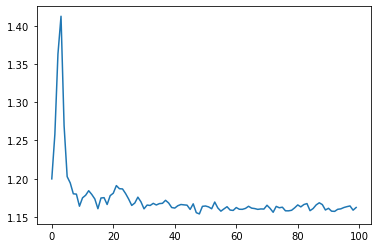

In [153]:
plt.plot(train_losses)

In [155]:
optimizer.state_dict

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1.0000000000000004e-08
    weight_decay: 0.0
)>

In [157]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits.parameters(), lr=0.000002, weight_decay=0.)


In [158]:
for epoch in tqdm(range(10)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss:
        best_valid_loss = test_loss.item()
        torch.save(DeepCoSI_Model_logits.state_dict(), f'best_models/{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)
    test_aucs.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_thresholds.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    valid_thresholds.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_thresholds.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs.append(test_auprc)
    
    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    test_losses.append(test_loss.item())
    
    train_num_positive.append(np.array(train_pred_bin).sum())
    valid_num_positive.append(np.array(valid_pred_bin).sum())
    test_num_positive.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive[-1], test_num_positive[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive[-1], end - st))

 10%|█         | 1/10 [06:21<57:14, 381.58s/it]

epoch:0 	 train_loss:1.1583 	 valid_loss:1.1678 	 train_accuracy:0.6588 	 valid_accuracy:0.5100 	 train_auc:0.6731 	 valid_auc:0.6710 	 train_auprc:0.1753 	 valid_auprc:0.1699 	 train_num_positive:1480.0000 	 valid_num_positive:273.0000 	 time:381.582 s
epoch:0 	 test_loss:1.1707 	 test_accuracy:0.4753 	 test_auc:0.6458 	 test_auprc:0.1915 	 test_num_positive:268.0000 	 time:381.582 s


 20%|██        | 2/10 [12:41<50:43, 380.49s/it]

epoch:1 	 train_loss:1.1549 	 valid_loss:1.1736 	 train_accuracy:0.6660 	 valid_accuracy:0.5000 	 train_auc:0.6751 	 valid_auc:0.6663 	 train_auprc:0.1747 	 valid_auprc:0.1659 	 train_num_positive:1444.0000 	 valid_num_positive:278.0000 	 time:379.721 s
epoch:1 	 test_loss:1.1733 	 test_accuracy:0.4731 	 test_auc:0.6397 	 test_auprc:0.1844 	 test_num_positive:267.0000 	 time:379.721 s


 30%|███       | 3/10 [19:03<44:27, 381.08s/it]

epoch:2 	 train_loss:1.1558 	 valid_loss:1.1755 	 train_accuracy:0.6655 	 valid_accuracy:0.4980 	 train_auc:0.6755 	 valid_auc:0.6649 	 train_auprc:0.1772 	 valid_auprc:0.1667 	 train_num_positive:1452.0000 	 valid_num_positive:281.0000 	 time:381.787 s
epoch:2 	 test_loss:1.1703 	 test_accuracy:0.4710 	 test_auc:0.6431 	 test_auprc:0.1849 	 test_num_positive:270.0000 	 time:381.787 s


 40%|████      | 4/10 [25:26<38:12, 382.11s/it]

epoch:3 	 train_loss:1.1541 	 valid_loss:1.1746 	 train_accuracy:0.6655 	 valid_accuracy:0.5060 	 train_auc:0.6755 	 valid_auc:0.6635 	 train_auprc:0.1748 	 valid_auprc:0.1660 	 train_num_positive:1444.0000 	 valid_num_positive:279.0000 	 time:383.684 s
epoch:3 	 test_loss:1.1719 	 test_accuracy:0.4753 	 test_auc:0.6386 	 test_auprc:0.1868 	 test_num_positive:266.0000 	 time:383.684 s


 40%|████      | 4/10 [29:36<44:24, 444.03s/it]


KeyboardInterrupt: 

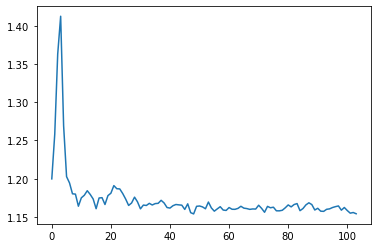

In [159]:
plt.plot(train_losses)

In [160]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                               collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle=True,
                               collate_fn=collate_fn)
test_dataloader = DataLoader(testing_dataset, batch_size=128, shuffle=True,
                               collate_fn=collate_fn)

In [161]:
for epoch in tqdm(range(10)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss:
        best_valid_loss = test_loss.item()
        torch.save(DeepCoSI_Model_logits.state_dict(), f'best_models/{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)
    test_aucs.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_thresholds.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    valid_thresholds.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_thresholds.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs.append(test_auprc)
    
    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    test_losses.append(test_loss.item())
    
    train_num_positive.append(np.array(train_pred_bin).sum())
    valid_num_positive.append(np.array(valid_pred_bin).sum())
    test_num_positive.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive[-1], test_num_positive[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive[-1], end - st))

 10%|█         | 1/10 [06:00<54:06, 360.68s/it]

epoch:0 	 train_loss:1.1424 	 valid_loss:1.1643 	 train_accuracy:0.6912 	 valid_accuracy:0.5161 	 train_auc:0.6779 	 valid_auc:0.6657 	 train_auprc:0.1755 	 valid_auprc:0.1693 	 train_num_positive:1308.0000 	 valid_num_positive:270.0000 	 time:360.676 s
epoch:0 	 test_loss:1.1602 	 test_accuracy:0.4903 	 test_auc:0.6381 	 test_auprc:0.1881 	 test_num_positive:257.0000 	 time:360.676 s


 20%|██        | 2/10 [12:09<48:43, 365.49s/it]

epoch:1 	 train_loss:1.1516 	 valid_loss:1.1737 	 train_accuracy:0.6672 	 valid_accuracy:0.4980 	 train_auc:0.6769 	 valid_auc:0.6637 	 train_auprc:0.1759 	 valid_auprc:0.1677 	 train_num_positive:1435.0000 	 valid_num_positive:281.0000 	 time:368.857 s
epoch:1 	 test_loss:1.1716 	 test_accuracy:0.4645 	 test_auc:0.6363 	 test_auprc:0.1928 	 test_num_positive:271.0000 	 time:368.857 s


 30%|███       | 3/10 [18:23<43:05, 369.33s/it]

epoch:2 	 train_loss:1.1501 	 valid_loss:1.1702 	 train_accuracy:0.6759 	 valid_accuracy:0.4900 	 train_auc:0.6751 	 valid_auc:0.6618 	 train_auprc:0.1770 	 valid_auprc:0.1677 	 train_num_positive:1387.0000 	 valid_num_positive:283.0000 	 time:373.888 s
epoch:2 	 test_loss:1.1689 	 test_accuracy:0.4602 	 test_auc:0.6364 	 test_auprc:0.1921 	 test_num_positive:273.0000 	 time:373.888 s


 40%|████      | 4/10 [24:25<36:39, 366.57s/it]

epoch:3 	 train_loss:1.1509 	 valid_loss:1.1716 	 train_accuracy:0.6682 	 valid_accuracy:0.4880 	 train_auc:0.6766 	 valid_auc:0.6631 	 train_auprc:0.1788 	 valid_auprc:0.1737 	 train_num_positive:1417.0000 	 valid_num_positive:282.0000 	 time:362.345 s
epoch:3 	 test_loss:1.1725 	 test_accuracy:0.4645 	 test_auc:0.6355 	 test_auprc:0.1756 	 test_num_positive:271.0000 	 time:362.345 s


 50%|█████     | 5/10 [30:31<30:32, 366.43s/it]

epoch:4 	 train_loss:1.1472 	 valid_loss:1.1713 	 train_accuracy:0.6779 	 valid_accuracy:0.4779 	 train_auc:0.6751 	 valid_auc:0.6568 	 train_auprc:0.1750 	 valid_auprc:0.1725 	 train_num_positive:1373.0000 	 valid_num_positive:285.0000 	 time:366.176 s
epoch:4 	 test_loss:1.1681 	 test_accuracy:0.4731 	 test_auc:0.6366 	 test_auprc:0.1760 	 test_num_positive:267.0000 	 time:366.176 s


 60%|██████    | 6/10 [36:41<24:30, 367.63s/it]

epoch:5 	 train_loss:1.1511 	 valid_loss:1.1778 	 train_accuracy:0.6593 	 valid_accuracy:0.4759 	 train_auc:0.6805 	 valid_auc:0.6604 	 train_auprc:0.1795 	 valid_auprc:0.1690 	 train_num_positive:1480.0000 	 valid_num_positive:292.0000 	 time:369.962 s
epoch:5 	 test_loss:1.1735 	 test_accuracy:0.4581 	 test_auc:0.6404 	 test_auprc:0.1878 	 test_num_positive:274.0000 	 time:369.962 s


 60%|██████    | 6/10 [38:07<25:24, 381.23s/it]


KeyboardInterrupt: 

In [162]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True,
                               collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=True,
                               collate_fn=collate_fn)
test_dataloader = DataLoader(testing_dataset, batch_size=256, shuffle=True,
                               collate_fn=collate_fn)

In [165]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits.parameters(), lr=0.0000005, weight_decay=0.)

In [166]:
for epoch in tqdm(range(10)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss:
        best_valid_loss = test_loss.item()
        torch.save(DeepCoSI_Model_logits.state_dict(), f'best_models/{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)
    test_aucs.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_thresholds.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    valid_thresholds.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_thresholds.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs.append(test_auprc)
    
    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    test_losses.append(test_loss.item())
    
    train_num_positive.append(np.array(train_pred_bin).sum())
    valid_num_positive.append(np.array(valid_pred_bin).sum())
    test_num_positive.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive[-1], test_num_positive[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive[-1], end - st))

 10%|█         | 1/10 [06:39<59:54, 399.40s/it]

epoch:0 	 train_loss:1.1524 	 valid_loss:1.1809 	 train_accuracy:0.6580 	 valid_accuracy:0.4679 	 train_auc:0.6793 	 valid_auc:0.6589 	 train_auprc:0.1783 	 valid_auprc:0.1688 	 train_num_positive:1489.0000 	 valid_num_positive:296.0000 	 time:399.399 s
epoch:0 	 test_loss:1.1717 	 test_accuracy:0.4581 	 test_auc:0.6454 	 test_auprc:0.1910 	 test_num_positive:274.0000 	 time:399.399 s


 20%|██        | 2/10 [13:16<53:06, 398.28s/it]

epoch:1 	 train_loss:1.1470 	 valid_loss:1.1739 	 train_accuracy:0.6694 	 valid_accuracy:0.4880 	 train_auc:0.6771 	 valid_auc:0.6586 	 train_auprc:0.1748 	 valid_auprc:0.1699 	 train_num_positive:1418.0000 	 valid_num_positive:282.0000 	 time:397.499 s
epoch:1 	 test_loss:1.1674 	 test_accuracy:0.4710 	 test_auc:0.6422 	 test_auprc:0.1833 	 test_num_positive:268.0000 	 time:397.499 s


 30%|███       | 3/10 [19:54<46:26, 398.07s/it]

epoch:2 	 train_loss:1.1514 	 valid_loss:1.1780 	 train_accuracy:0.6609 	 valid_accuracy:0.4819 	 train_auc:0.6766 	 valid_auc:0.6586 	 train_auprc:0.1740 	 valid_auprc:0.1712 	 train_num_positive:1461.0000 	 valid_num_positive:285.0000 	 time:397.825 s
epoch:2 	 test_loss:1.1731 	 test_accuracy:0.4688 	 test_auc:0.6411 	 test_auprc:0.1798 	 test_num_positive:269.0000 	 time:397.825 s


 30%|███       | 3/10 [20:29<47:48, 409.77s/it]


KeyboardInterrupt: 

In [167]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                               collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True,
                               collate_fn=collate_fn)
test_dataloader = DataLoader(testing_dataset, batch_size=16, shuffle=True,
                               collate_fn=collate_fn)

In [169]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits.parameters(), lr=0.000002, weight_decay=0.)

In [170]:
for epoch in tqdm(range(10)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss:
        best_valid_loss = test_loss.item()
        torch.save(DeepCoSI_Model_logits.state_dict(), f'best_models/{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)
    test_aucs.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_thresholds.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    valid_thresholds.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_thresholds.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs.append(test_auprc)
    
    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    test_losses.append(test_loss.item())
    
    train_num_positive.append(np.array(train_pred_bin).sum())
    valid_num_positive.append(np.array(valid_pred_bin).sum())
    test_num_positive.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive[-1], test_num_positive[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive[-1], end - st))

 10%|█         | 1/10 [05:56<53:26, 356.24s/it]

epoch:0 	 train_loss:1.1342 	 valid_loss:1.1665 	 train_accuracy:0.6813 	 valid_accuracy:0.4940 	 train_auc:0.6828 	 valid_auc:0.6573 	 train_auprc:0.1812 	 valid_auprc:0.1610 	 train_num_positive:1367.0000 	 valid_num_positive:281.0000 	 time:356.235 s
epoch:0 	 test_loss:1.1416 	 test_accuracy:0.4796 	 test_auc:0.6601 	 test_auprc:0.1830 	 test_num_positive:264.0000 	 time:356.235 s


 20%|██        | 2/10 [11:51<47:24, 355.52s/it]

epoch:1 	 train_loss:1.1433 	 valid_loss:1.1550 	 train_accuracy:0.6844 	 valid_accuracy:0.5120 	 train_auc:0.6826 	 valid_auc:0.6669 	 train_auprc:0.1784 	 valid_auprc:0.1667 	 train_num_positive:1350.0000 	 valid_num_positive:274.0000 	 time:355.010 s
epoch:1 	 test_loss:1.1404 	 test_accuracy:0.4882 	 test_auc:0.6560 	 test_auprc:0.1831 	 test_num_positive:258.0000 	 time:355.010 s


 30%|███       | 3/10 [17:47<41:29, 355.67s/it]

epoch:2 	 train_loss:1.1450 	 valid_loss:1.1856 	 train_accuracy:0.6764 	 valid_accuracy:0.4679 	 train_auc:0.6808 	 valid_auc:0.6469 	 train_auprc:0.1726 	 valid_auprc:0.1689 	 train_num_positive:1395.0000 	 valid_num_positive:294.0000 	 time:355.855 s
epoch:2 	 test_loss:1.1619 	 test_accuracy:0.4667 	 test_auc:0.6484 	 test_auprc:0.1952 	 test_num_positive:268.0000 	 time:355.855 s


 30%|███       | 3/10 [18:08<42:18, 362.68s/it]


KeyboardInterrupt: 

## load the saved state dicts - the model will be overwritten 

So, the model learns the small dataset (about 750 examples), but seems to strugle with the larger dataset

Hence, perhaps make it deeper

In [171]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True,
                               collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=True,
                               collate_fn=collate_fn)
test_dataloader = DataLoader(testing_dataset, batch_size=256, shuffle=True,
                               collate_fn=collate_fn)

In [172]:
DeepCoSI_Model_logits = DeepCoSIPredictorWithLogits(node_feat_size=94, edge_feat_size=20, num_layers=6,
                                     graph_feat_size=256,
                                     d_FC_layer=256, n_FC_layer=3, dropout=0.1)

In [173]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits.parameters(), lr=0.000005, weight_decay=0.)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(8))

In [ ]:
train_aucs_deeper, valid_aucs_deeper, test_aucs_deeper = [],[],[]
train_accuracies_deeper, valid_accuracies_deeper, test_accuracies_deeper = [],[],[]
train_losses_deeper, valid_losses_deeper, test_losses_deeper = [],[],[]
train_precisions_deeper, valid_precisions_deeper, test_precisions_deeper = [],[],[]
train_recalls_deeper, valid_recalls_deeper, test_recalls_deeper = [],[],[]
train_thresholds_deeper, valid_thresholds_deeper,test_thresholds_deeper = [],[],[]
train_auprcs_deeper, valid_auprcs_deeper, test_auprcs_deeper = [],[],[]
train_num_positive_deeper, valid_num_positive_deeper, test_num_positive_deeper = [],[],[]
best_valid_loss_deeper = torch.inf

In [177]:


for epoch in tqdm(range(100)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss_deeper:
        best_valid_loss_deeper = test_loss.item()
        torch.save(DeepCoSI_Model_logits.state_dict(), f'best_deeper_models/{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs_deeper.append(train_auc)
    valid_aucs_deeper.append(valid_auc)
    test_aucs_deeper.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies_deeper.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies_deeper.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies_deeper.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions_deeper.append(train_precision)
    train_recalls_deeper.append(train_recall)
    train_thresholds_deeper.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs_deeper.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions_deeper.append(valid_precision)
    valid_recalls_deeper.append(valid_recall)
    valid_thresholds_deeper.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs_deeper.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions_deeper.append(test_precision)
    test_recalls_deeper.append(test_recall)
    test_thresholds_deeper.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs_deeper.append(test_auprc)
    
    train_losses_deeper.append(train_loss.item())
    valid_losses_deeper.append(valid_loss.item())
    test_losses_deeper.append(test_loss.item())
    
    train_num_positive_deeper.append(np.array(train_pred_bin).sum())
    valid_num_positive_deeper.append(np.array(valid_pred_bin).sum())
    test_num_positive_deeper.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive[-1], test_num_positive[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive[-1], end - st))

  1%|          | 1/100 [12:41<20:55:45, 761.06s/it]

epoch:0 	 train_loss:3.2318 	 valid_loss:3.3607 	 train_accuracy:0.8958 	 valid_accuracy:0.8936 	 train_auc:0.3991 	 valid_auc:0.3934 	 train_auprc:0.0814 	 valid_auprc:0.0904 	 train_num_positive:1395.0000 	 valid_num_positive:294.0000 	 time:761.063 s
epoch:0 	 test_loss:3.1626 	 test_accuracy:0.9011 	 test_auc:0.3827 	 test_auprc:0.0759 	 test_num_positive:268.0000 	 time:761.063 s


  2%|▏         | 2/100 [25:07<20:28:55, 752.41s/it]

epoch:1 	 train_loss:2.6840 	 valid_loss:2.8056 	 train_accuracy:0.8958 	 valid_accuracy:0.8936 	 train_auc:0.3975 	 valid_auc:0.3904 	 train_auprc:0.0812 	 valid_auprc:0.0897 	 train_num_positive:1395.0000 	 valid_num_positive:294.0000 	 time:746.343 s
epoch:1 	 test_loss:2.6152 	 test_accuracy:0.9011 	 test_auc:0.3872 	 test_auprc:0.0764 	 test_num_positive:268.0000 	 time:746.343 s


  3%|▎         | 3/100 [37:41<20:17:54, 753.35s/it]

epoch:2 	 train_loss:2.0275 	 valid_loss:2.1071 	 train_accuracy:0.8958 	 valid_accuracy:0.8936 	 train_auc:0.4011 	 valid_auc:0.3877 	 train_auprc:0.0827 	 valid_auprc:0.1011 	 train_num_positive:1395.0000 	 valid_num_positive:294.0000 	 time:754.464 s
epoch:2 	 test_loss:1.9869 	 test_accuracy:0.9011 	 test_auc:0.3873 	 test_auprc:0.0761 	 test_num_positive:268.0000 	 time:754.464 s


  4%|▍         | 4/100 [50:12<20:03:50, 752.40s/it]

epoch:3 	 train_loss:1.3309 	 valid_loss:1.3632 	 train_accuracy:0.8950 	 valid_accuracy:0.7410 	 train_auc:0.4309 	 valid_auc:0.3924 	 train_auprc:0.0879 	 valid_auprc:0.0821 	 train_num_positive:1395.0000 	 valid_num_positive:294.0000 	 time:750.958 s
epoch:3 	 test_loss:1.3081 	 test_accuracy:0.7957 	 test_auc:0.4347 	 test_auprc:0.0894 	 test_num_positive:268.0000 	 time:750.958 s


  5%|▌         | 5/100 [1:02:47<19:52:25, 753.11s/it]

epoch:4 	 train_loss:1.1852 	 valid_loss:1.2274 	 train_accuracy:0.8435 	 valid_accuracy:0.4719 	 train_auc:0.5808 	 valid_auc:0.5290 	 train_auprc:0.1396 	 valid_auprc:0.1160 	 train_num_positive:1395.0000 	 valid_num_positive:294.0000 	 time:754.352 s
epoch:4 	 test_loss:1.1777 	 test_accuracy:0.4602 	 test_auc:0.5638 	 test_auprc:0.1273 	 test_num_positive:268.0000 	 time:754.352 s


  6%|▌         | 6/100 [1:15:18<19:39:07, 752.63s/it]

epoch:5 	 train_loss:1.1832 	 valid_loss:1.2310 	 train_accuracy:0.8244 	 valid_accuracy:0.4398 	 train_auc:0.5880 	 valid_auc:0.5220 	 train_auprc:0.1406 	 valid_auprc:0.1158 	 train_num_positive:1395.0000 	 valid_num_positive:294.0000 	 time:751.701 s
epoch:5 	 test_loss:1.1871 	 test_accuracy:0.4430 	 test_auc:0.5407 	 test_auprc:0.1285 	 test_num_positive:268.0000 	 time:751.701 s


  7%|▋         | 7/100 [1:27:50<19:26:03, 752.29s/it]

epoch:6 	 train_loss:1.1890 	 valid_loss:1.2473 	 train_accuracy:0.7608 	 valid_accuracy:0.3494 	 train_auc:0.5991 	 valid_auc:0.5283 	 train_auprc:0.1491 	 valid_auprc:0.1182 	 train_num_positive:1395.0000 	 valid_num_positive:294.0000 	 time:751.594 s
epoch:6 	 test_loss:1.2083 	 test_accuracy:0.3419 	 test_auc:0.5392 	 test_auprc:0.1449 	 test_num_positive:268.0000 	 time:751.594 s


  8%|▊         | 8/100 [1:40:02<19:03:29, 745.76s/it]

epoch:7 	 train_loss:1.2028 	 valid_loss:1.2588 	 train_accuracy:0.6805 	 valid_accuracy:0.3112 	 train_auc:0.6173 	 valid_auc:0.5535 	 train_auprc:0.1575 	 valid_auprc:0.1179 	 train_num_positive:1395.0000 	 valid_num_positive:294.0000 	 time:731.758 s
epoch:7 	 test_loss:1.1962 	 test_accuracy:0.2989 	 test_auc:0.6169 	 test_auprc:0.1481 	 test_num_positive:268.0000 	 time:731.758 s


  9%|▉         | 9/100 [1:52:30<18:52:14, 746.53s/it]

epoch:8 	 train_loss:1.1782 	 valid_loss:1.2430 	 train_accuracy:0.7642 	 valid_accuracy:0.3956 	 train_auc:0.6175 	 valid_auc:0.5403 	 train_auprc:0.1576 	 valid_auprc:0.1179 	 train_num_positive:1395.0000 	 valid_num_positive:294.0000 	 time:748.234 s
epoch:8 	 test_loss:1.1891 	 test_accuracy:0.4043 	 test_auc:0.5833 	 test_auprc:0.1417 	 test_num_positive:268.0000 	 time:748.234 s


  9%|▉         | 9/100 [1:55:36<19:28:57, 770.74s/it]


KeyboardInterrupt: 

In [178]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits.parameters(), lr=0.000001, weight_decay=0.)

In [179]:

for epoch in tqdm(range(100)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss_deeper:
        best_valid_loss_deeper = test_loss.item()
        torch.save(DeepCoSI_Model_logits.state_dict(), f'best_deeper_models/{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs_deeper.append(train_auc)
    valid_aucs_deeper.append(valid_auc)
    test_aucs_deeper.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies_deeper.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies_deeper.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies_deeper.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions_deeper.append(train_precision)
    train_recalls_deeper.append(train_recall)
    train_thresholds_deeper.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs_deeper.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions_deeper.append(valid_precision)
    valid_recalls_deeper.append(valid_recall)
    valid_thresholds_deeper.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs_deeper.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions_deeper.append(test_precision)
    test_recalls_deeper.append(test_recall)
    test_thresholds_deeper.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs_deeper.append(test_auprc)
    
    train_losses_deeper.append(train_loss.item())
    valid_losses_deeper.append(valid_loss.item())
    test_losses_deeper.append(test_loss.item())
    
    train_num_positive_deeper.append(np.array(train_pred_bin).sum())
    valid_num_positive_deeper.append(np.array(valid_pred_bin).sum())
    test_num_positive_deeper.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive_deeper[-1], test_num_positive_deeper[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive_deeper[-1], end - st))

  1%|          | 1/100 [12:35<20:47:22, 755.98s/it]

epoch:0 	 train_loss:1.1730 	 valid_loss:1.2305 	 train_accuracy:0.7940 	 valid_accuracy:0.4438 	 train_auc:0.6160 	 valid_auc:0.5502 	 train_auprc:0.1554 	 valid_auprc:0.1193 	 train_num_positive:653.0000 	 valid_num_positive:294.0000 	 time:755.980 s
epoch:0 	 test_loss:1.1806 	 test_accuracy:0.4538 	 test_auc:0.5722 	 test_auprc:0.1444 	 test_num_positive:270.0000 	 time:755.980 s


  2%|▏         | 2/100 [25:13<20:36:04, 756.79s/it]

epoch:1 	 train_loss:1.1776 	 valid_loss:1.2436 	 train_accuracy:0.7669 	 valid_accuracy:0.4137 	 train_auc:0.6191 	 valid_auc:0.5401 	 train_auprc:0.1552 	 valid_auprc:0.1180 	 train_num_positive:811.0000 	 valid_num_positive:309.0000 	 time:757.347 s
epoch:1 	 test_loss:1.1857 	 test_accuracy:0.4151 	 test_auc:0.5831 	 test_auprc:0.1471 	 test_num_positive:292.0000 	 time:757.347 s


  3%|▎         | 3/100 [37:35<20:12:33, 750.04s/it]

epoch:2 	 train_loss:1.1797 	 valid_loss:1.2414 	 train_accuracy:0.7553 	 valid_accuracy:0.4016 	 train_auc:0.6199 	 valid_auc:0.5501 	 train_auprc:0.1560 	 valid_auprc:0.1195 	 train_num_positive:877.0000 	 valid_num_positive:319.0000 	 time:742.006 s
epoch:2 	 test_loss:1.1800 	 test_accuracy:0.4086 	 test_auc:0.6020 	 test_auprc:0.1474 	 test_num_positive:301.0000 	 time:742.006 s


  4%|▍         | 4/100 [50:06<20:00:29, 750.30s/it]

epoch:3 	 train_loss:1.1719 	 valid_loss:1.2298 	 train_accuracy:0.7768 	 valid_accuracy:0.4458 	 train_auc:0.6213 	 valid_auc:0.5606 	 train_auprc:0.1558 	 valid_auprc:0.1224 	 train_num_positive:736.0000 	 valid_num_positive:295.0000 	 time:750.712 s
epoch:3 	 test_loss:1.1815 	 test_accuracy:0.4538 	 test_auc:0.5860 	 test_auprc:0.1463 	 test_num_positive:276.0000 	 time:750.712 s


  5%|▌         | 5/100 [1:01:09<18:58:32, 719.08s/it]

epoch:4 	 train_loss:1.1753 	 valid_loss:1.2400 	 train_accuracy:0.7693 	 valid_accuracy:0.4237 	 train_auc:0.6202 	 valid_auc:0.5496 	 train_auprc:0.1594 	 valid_auprc:0.1213 	 train_num_positive:793.0000 	 valid_num_positive:302.0000 	 time:663.710 s
epoch:4 	 test_loss:1.1870 	 test_accuracy:0.4194 	 test_auc:0.5824 	 test_auprc:0.1470 	 test_num_positive:292.0000 	 time:663.710 s


  6%|▌         | 6/100 [1:11:04<17:40:19, 676.81s/it]

epoch:5 	 train_loss:1.1776 	 valid_loss:1.2435 	 train_accuracy:0.7514 	 valid_accuracy:0.4177 	 train_auc:0.6238 	 valid_auc:0.5511 	 train_auprc:0.1597 	 valid_auprc:0.1197 	 train_num_positive:887.0000 	 valid_num_positive:313.0000 	 time:594.751 s
epoch:5 	 test_loss:1.1803 	 test_accuracy:0.4043 	 test_auc:0.6067 	 test_auprc:0.1530 	 test_num_positive:303.0000 	 time:594.751 s


  7%|▋         | 7/100 [1:20:56<16:46:18, 649.23s/it]

epoch:6 	 train_loss:1.1816 	 valid_loss:1.2405 	 train_accuracy:0.7395 	 valid_accuracy:0.4096 	 train_auc:0.6217 	 valid_auc:0.5583 	 train_auprc:0.1569 	 valid_auprc:0.1209 	 train_num_positive:952.0000 	 valid_num_positive:315.0000 	 time:592.446 s
epoch:6 	 test_loss:1.1686 	 test_accuracy:0.4065 	 test_auc:0.6270 	 test_auprc:0.1560 	 test_num_positive:306.0000 	 time:592.446 s


  7%|▋         | 7/100 [1:23:53<18:34:28, 719.01s/it]


KeyboardInterrupt: 

In [184]:
torch.save(DeepCoSI_Model_logits_small.state_dict(), 'best_deeper_models/small_set_model_before_fine_tuning_01_12.pth')

In [181]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                               collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle=True,
                               collate_fn=collate_fn)
test_dataloader = DataLoader(testing_dataset, batch_size=128, shuffle=True,
                               collate_fn=collate_fn)

In [182]:
train_aucs_small, valid_aucs_small, test_aucs_small = [],[],[]
train_accuracies_small, valid_accuracies_small, test_accuracies_small = [],[],[]
train_losses_small, valid_losses_small, test_losses_small = [],[],[]
train_precisions_small, valid_precisions_small, test_precisions_small = [],[],[]
train_recalls_small, valid_recalls_small, test_recalls_small = [],[],[]
train_thresholds_small, valid_thresholds_small,test_thresholds_small = [],[],[]
train_auprcs_small, valid_auprcs_small, test_auprcs_small = [],[],[]
train_num_positive_small, valid_num_positive_small, test_num_positive_small = [],[],[]
best_valid_loss_small = torch.inf

In [185]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits_small.parameters(), lr=0.000001, weight_decay=0.)

In [186]:
for epoch in tqdm(range(10)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss_small:
        best_valid_loss_deeper = test_loss.item()
        torch.save(DeepCoSI_Model_logits_small.state_dict(), f'best_deeper_models/fine_tuning_small_{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs_small.append(train_auc)
    valid_aucs_small.append(valid_auc)
    test_aucs_small.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies_small.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies_small.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies_small.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions_small.append(train_precision)
    train_recalls_small.append(train_recall)
    train_thresholds_small.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs_small.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions_small.append(valid_precision)
    valid_recalls_small.append(valid_recall)
    valid_thresholds_small.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs_small.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions_small.append(test_precision)
    test_recalls_small.append(test_recall)
    test_thresholds_small.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs_small.append(test_auprc)
    
    train_losses_small.append(train_loss.item())
    valid_losses_small.append(valid_loss.item())
    test_losses_small.append(test_loss.item())
    
    train_num_positive_small.append(np.array(train_pred_bin).sum())
    valid_num_positive_small.append(np.array(valid_pred_bin).sum())
    test_num_positive_small.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive_small[-1], test_num_positive_small[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive_small[-1], end - st))

 10%|█         | 1/10 [04:37<41:33, 277.07s/it]

epoch:0 	 train_loss:1.3658 	 valid_loss:1.5435 	 train_accuracy:0.7753 	 valid_accuracy:0.7229 	 train_auc:0.6598 	 valid_auc:0.5969 	 train_auprc:0.2504 	 valid_auprc:0.1856 	 train_num_positive:860.0000 	 valid_num_positive:127.0000 	 time:277.065 s
epoch:0 	 test_loss:1.3477 	 test_accuracy:0.7054 	 test_auc:0.6622 	 test_auprc:0.2550 	 test_num_positive:133.0000 	 time:277.065 s


 20%|██        | 2/10 [09:13<36:51, 276.44s/it]

epoch:1 	 train_loss:1.3377 	 valid_loss:1.5146 	 train_accuracy:0.7797 	 valid_accuracy:0.7309 	 train_auc:0.6664 	 valid_auc:0.6014 	 train_auprc:0.2541 	 valid_auprc:0.1864 	 train_num_positive:836.0000 	 valid_num_positive:127.0000 	 time:276.002 s
epoch:1 	 test_loss:1.3147 	 test_accuracy:0.7204 	 test_auc:0.6671 	 test_auprc:0.2627 	 test_num_positive:126.0000 	 time:276.002 s


 30%|███       | 3/10 [13:50<32:17, 276.80s/it]

epoch:2 	 train_loss:1.3335 	 valid_loss:1.5075 	 train_accuracy:0.7688 	 valid_accuracy:0.7149 	 train_auc:0.6712 	 valid_auc:0.6065 	 train_auprc:0.2516 	 valid_auprc:0.1891 	 train_num_positive:907.0000 	 valid_num_positive:139.0000 	 time:277.222 s
epoch:2 	 test_loss:1.3142 	 test_accuracy:0.6968 	 test_auc:0.6734 	 test_auprc:0.2322 	 test_num_positive:137.0000 	 time:277.222 s


 40%|████      | 4/10 [18:26<27:38, 276.43s/it]

epoch:3 	 train_loss:1.3168 	 valid_loss:1.4977 	 train_accuracy:0.7765 	 valid_accuracy:0.7229 	 train_auc:0.6770 	 valid_auc:0.6092 	 train_auprc:0.2538 	 valid_auprc:0.1861 	 train_num_positive:853.0000 	 valid_num_positive:127.0000 	 time:275.868 s
epoch:3 	 test_loss:1.2901 	 test_accuracy:0.7118 	 test_auc:0.6816 	 test_auprc:0.2706 	 test_num_positive:132.0000 	 time:275.868 s


 50%|█████     | 5/10 [23:04<23:05, 277.17s/it]

epoch:4 	 train_loss:1.2972 	 valid_loss:1.4745 	 train_accuracy:0.7719 	 valid_accuracy:0.7229 	 train_auc:0.6800 	 valid_auc:0.6149 	 train_auprc:0.2569 	 valid_auprc:0.1923 	 train_num_positive:884.0000 	 valid_num_positive:131.0000 	 time:278.477 s
epoch:4 	 test_loss:1.2681 	 test_accuracy:0.6968 	 test_auc:0.6812 	 test_auprc:0.2817 	 test_num_positive:139.0000 	 time:278.477 s


 60%|██████    | 6/10 [27:41<18:27, 276.96s/it]

epoch:5 	 train_loss:1.2645 	 valid_loss:1.4439 	 train_accuracy:0.7807 	 valid_accuracy:0.7269 	 train_auc:0.6879 	 valid_auc:0.6229 	 train_auprc:0.2611 	 valid_auprc:0.1894 	 train_num_positive:850.0000 	 valid_num_positive:131.0000 	 time:276.545 s
epoch:5 	 test_loss:1.2402 	 test_accuracy:0.6989 	 test_auc:0.6869 	 test_auprc:0.2890 	 test_num_positive:140.0000 	 time:276.545 s


 70%|███████   | 7/10 [32:16<13:48, 276.31s/it]

epoch:6 	 train_loss:1.2660 	 valid_loss:1.4438 	 train_accuracy:0.7778 	 valid_accuracy:0.7249 	 train_auc:0.6909 	 valid_auc:0.6234 	 train_auprc:0.2583 	 valid_auprc:0.1954 	 train_num_positive:872.0000 	 valid_num_positive:130.0000 	 time:274.988 s
epoch:6 	 test_loss:1.2420 	 test_accuracy:0.7075 	 test_auc:0.6930 	 test_auprc:0.2820 	 test_num_positive:138.0000 	 time:274.988 s


 80%|████████  | 8/10 [36:52<09:12, 276.16s/it]

epoch:7 	 train_loss:1.2560 	 valid_loss:1.4390 	 train_accuracy:0.7748 	 valid_accuracy:0.7229 	 train_auc:0.6951 	 valid_auc:0.6285 	 train_auprc:0.2612 	 valid_auprc:0.1960 	 train_num_positive:884.0000 	 valid_num_positive:135.0000 	 time:275.818 s
epoch:7 	 test_loss:1.2481 	 test_accuracy:0.6860 	 test_auc:0.6900 	 test_auprc:0.2883 	 test_num_positive:148.0000 	 time:275.818 s


 90%|█████████ | 9/10 [41:27<04:35, 275.81s/it]

epoch:8 	 train_loss:1.2303 	 valid_loss:1.4269 	 train_accuracy:0.7792 	 valid_accuracy:0.7129 	 train_auc:0.6990 	 valid_auc:0.6301 	 train_auprc:0.2636 	 valid_auprc:0.1904 	 train_num_positive:872.0000 	 valid_num_positive:138.0000 	 time:275.052 s
epoch:8 	 test_loss:1.2218 	 test_accuracy:0.6968 	 test_auc:0.6924 	 test_auprc:0.2926 	 test_num_positive:145.0000 	 time:275.052 s


100%|██████████| 10/10 [46:01<00:00, 276.18s/it]

epoch:9 	 train_loss:1.2329 	 valid_loss:1.4214 	 train_accuracy:0.7734 	 valid_accuracy:0.7229 	 train_auc:0.6998 	 valid_auc:0.6267 	 train_auprc:0.2633 	 valid_auprc:0.1954 	 train_num_positive:890.0000 	 valid_num_positive:133.0000 	 time:274.745 s
epoch:9 	 test_loss:1.2335 	 test_accuracy:0.6968 	 test_auc:0.6904 	 test_auprc:0.2983 	 test_num_positive:145.0000 	 time:274.745 s


In [187]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits_small.parameters(), lr=0.0000008, weight_decay=0.)

In [188]:
for epoch in tqdm(range(10,20)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss_small:
        best_valid_loss_deeper = test_loss.item()
        torch.save(DeepCoSI_Model_logits_small.state_dict(), f'best_deeper_models/fine_tuning_small_{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs_small.append(train_auc)
    valid_aucs_small.append(valid_auc)
    test_aucs_small.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies_small.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies_small.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies_small.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions_small.append(train_precision)
    train_recalls_small.append(train_recall)
    train_thresholds_small.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs_small.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions_small.append(valid_precision)
    valid_recalls_small.append(valid_recall)
    valid_thresholds_small.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs_small.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions_small.append(test_precision)
    test_recalls_small.append(test_recall)
    test_thresholds_small.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs_small.append(test_auprc)
    
    train_losses_small.append(train_loss.item())
    valid_losses_small.append(valid_loss.item())
    test_losses_small.append(test_loss.item())
    
    train_num_positive_small.append(np.array(train_pred_bin).sum())
    valid_num_positive_small.append(np.array(valid_pred_bin).sum())
    test_num_positive_small.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive_small[-1], test_num_positive_small[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive_small[-1], end - st))

 10%|█         | 1/10 [04:34<41:08, 274.25s/it]

epoch:10 	 train_loss:1.2192 	 valid_loss:1.4144 	 train_accuracy:0.7753 	 valid_accuracy:0.7129 	 train_auc:0.7033 	 valid_auc:0.6268 	 train_auprc:0.2623 	 valid_auprc:0.1924 	 train_num_positive:900.0000 	 valid_num_positive:140.0000 	 time:274.248 s
epoch:10 	 test_loss:1.2290 	 test_accuracy:0.6882 	 test_auc:0.6889 	 test_auprc:0.2877 	 test_num_positive:149.0000 	 time:274.248 s


 20%|██        | 2/10 [09:08<36:32, 274.11s/it]

epoch:11 	 train_loss:1.2142 	 valid_loss:1.4129 	 train_accuracy:0.7753 	 valid_accuracy:0.7048 	 train_auc:0.7050 	 valid_auc:0.6279 	 train_auprc:0.2654 	 valid_auprc:0.1895 	 train_num_positive:900.0000 	 valid_num_positive:144.0000 	 time:274.013 s
epoch:11 	 test_loss:1.2391 	 test_accuracy:0.6882 	 test_auc:0.6879 	 test_auprc:0.2961 	 test_num_positive:149.0000 	 time:274.013 s


 30%|███       | 3/10 [13:42<31:58, 274.04s/it]

epoch:12 	 train_loss:1.1937 	 valid_loss:1.3958 	 train_accuracy:0.7811 	 valid_accuracy:0.7189 	 train_auc:0.7084 	 valid_auc:0.6335 	 train_auprc:0.2689 	 valid_auprc:0.1953 	 train_num_positive:850.0000 	 valid_num_positive:137.0000 	 time:273.952 s
epoch:12 	 test_loss:1.2210 	 test_accuracy:0.6925 	 test_auc:0.6898 	 test_auprc:0.3016 	 test_num_positive:149.0000 	 time:273.952 s


 40%|████      | 4/10 [18:16<27:24, 274.02s/it]

epoch:13 	 train_loss:1.1834 	 valid_loss:1.3975 	 train_accuracy:0.7838 	 valid_accuracy:0.7169 	 train_auc:0.7108 	 valid_auc:0.6233 	 train_auprc:0.2693 	 valid_auprc:0.1913 	 train_num_positive:863.0000 	 valid_num_positive:136.0000 	 time:273.986 s
epoch:13 	 test_loss:1.2068 	 test_accuracy:0.6968 	 test_auc:0.6926 	 test_auprc:0.2928 	 test_num_positive:145.0000 	 time:273.986 s


 50%|█████     | 5/10 [22:50<22:50, 274.09s/it]

epoch:14 	 train_loss:1.1797 	 valid_loss:1.3892 	 train_accuracy:0.7843 	 valid_accuracy:0.7169 	 train_auc:0.7150 	 valid_auc:0.6368 	 train_auprc:0.2696 	 valid_auprc:0.1950 	 train_num_positive:861.0000 	 valid_num_positive:138.0000 	 time:274.225 s
epoch:14 	 test_loss:1.2115 	 test_accuracy:0.6925 	 test_auc:0.6964 	 test_auprc:0.2976 	 test_num_positive:151.0000 	 time:274.225 s


 60%|██████    | 6/10 [27:24<18:16, 274.12s/it]

epoch:15 	 train_loss:1.1771 	 valid_loss:1.3769 	 train_accuracy:0.7843 	 valid_accuracy:0.7068 	 train_auc:0.7155 	 valid_auc:0.6371 	 train_auprc:0.2690 	 valid_auprc:0.1962 	 train_num_positive:855.0000 	 valid_num_positive:141.0000 	 time:274.179 s
epoch:15 	 test_loss:1.2111 	 test_accuracy:0.6925 	 test_auc:0.6939 	 test_auprc:0.2725 	 test_num_positive:147.0000 	 time:274.179 s


 70%|███████   | 7/10 [31:59<13:43, 274.39s/it]

epoch:16 	 train_loss:1.1633 	 valid_loss:1.3690 	 train_accuracy:0.7843 	 valid_accuracy:0.7088 	 train_auc:0.7179 	 valid_auc:0.6363 	 train_auprc:0.2698 	 valid_auprc:0.1963 	 train_num_positive:867.0000 	 valid_num_positive:140.0000 	 time:274.934 s
epoch:16 	 test_loss:1.2001 	 test_accuracy:0.6860 	 test_auc:0.6966 	 test_auprc:0.3057 	 test_num_positive:148.0000 	 time:274.934 s


 80%|████████  | 8/10 [36:36<09:10, 275.11s/it]

epoch:17 	 train_loss:1.1562 	 valid_loss:1.3582 	 train_accuracy:0.7826 	 valid_accuracy:0.7048 	 train_auc:0.7219 	 valid_auc:0.6398 	 train_auprc:0.2710 	 valid_auprc:0.1954 	 train_num_positive:874.0000 	 valid_num_positive:148.0000 	 time:276.663 s
epoch:17 	 test_loss:1.1867 	 test_accuracy:0.6839 	 test_auc:0.7012 	 test_auprc:0.3100 	 test_num_positive:153.0000 	 time:276.663 s


 90%|█████████ | 9/10 [41:11<04:35, 275.05s/it]

epoch:18 	 train_loss:1.1529 	 valid_loss:1.3527 	 train_accuracy:0.7785 	 valid_accuracy:0.7048 	 train_auc:0.7219 	 valid_auc:0.6374 	 train_auprc:0.2703 	 valid_auprc:0.1981 	 train_num_positive:897.0000 	 valid_num_positive:148.0000 	 time:274.914 s
epoch:18 	 test_loss:1.1942 	 test_accuracy:0.6710 	 test_auc:0.6994 	 test_auprc:0.2684 	 test_num_positive:157.0000 	 time:274.914 s


100%|██████████| 10/10 [45:46<00:00, 274.63s/it]

epoch:19 	 train_loss:1.1422 	 valid_loss:1.3506 	 train_accuracy:0.7794 	 valid_accuracy:0.7008 	 train_auc:0.7259 	 valid_auc:0.6403 	 train_auprc:0.2732 	 valid_auprc:0.1963 	 train_num_positive:901.0000 	 valid_num_positive:150.0000 	 time:275.192 s
epoch:19 	 test_loss:1.1973 	 test_accuracy:0.6688 	 test_auc:0.6972 	 test_auprc:0.2990 	 test_num_positive:160.0000 	 time:275.192 s


In [189]:
for epoch in tqdm(range(20,30)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss_small:
        best_valid_loss_deeper = test_loss.item()
        torch.save(DeepCoSI_Model_logits_small.state_dict(), f'best_deeper_models/fine_tuning_small_{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs_small.append(train_auc)
    valid_aucs_small.append(valid_auc)
    test_aucs_small.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies_small.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies_small.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies_small.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions_small.append(train_precision)
    train_recalls_small.append(train_recall)
    train_thresholds_small.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs_small.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions_small.append(valid_precision)
    valid_recalls_small.append(valid_recall)
    valid_thresholds_small.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs_small.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions_small.append(test_precision)
    test_recalls_small.append(test_recall)
    test_thresholds_small.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs_small.append(test_auprc)
    
    train_losses_small.append(train_loss.item())
    valid_losses_small.append(valid_loss.item())
    test_losses_small.append(test_loss.item())
    
    train_num_positive_small.append(np.array(train_pred_bin).sum())
    valid_num_positive_small.append(np.array(valid_pred_bin).sum())
    test_num_positive_small.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive_small[-1], test_num_positive_small[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive_small[-1], end - st))

 10%|█         | 1/10 [04:34<41:07, 274.13s/it]

epoch:20 	 train_loss:1.1357 	 valid_loss:1.3446 	 train_accuracy:0.7794 	 valid_accuracy:0.6968 	 train_auc:0.7286 	 valid_auc:0.6446 	 train_auprc:0.2749 	 valid_auprc:0.2014 	 train_num_positive:913.0000 	 valid_num_positive:150.0000 	 time:274.127 s
epoch:20 	 test_loss:1.2008 	 test_accuracy:0.6731 	 test_auc:0.6932 	 test_auprc:0.3048 	 test_num_positive:160.0000 	 time:274.127 s


 20%|██        | 2/10 [09:08<36:35, 274.44s/it]

epoch:21 	 train_loss:1.1283 	 valid_loss:1.3445 	 train_accuracy:0.7898 	 valid_accuracy:0.7088 	 train_auc:0.7276 	 valid_auc:0.6370 	 train_auprc:0.2771 	 valid_auprc:0.1965 	 train_num_positive:846.0000 	 valid_num_positive:144.0000 	 time:274.653 s
epoch:21 	 test_loss:1.1874 	 test_accuracy:0.6710 	 test_auc:0.6953 	 test_auprc:0.2959 	 test_num_positive:157.0000 	 time:274.653 s


 30%|███       | 3/10 [13:43<32:01, 274.51s/it]

epoch:22 	 train_loss:1.1207 	 valid_loss:1.3302 	 train_accuracy:0.7852 	 valid_accuracy:0.6888 	 train_auc:0.7302 	 valid_auc:0.6397 	 train_auprc:0.2741 	 valid_auprc:0.1970 	 train_num_positive:881.0000 	 valid_num_positive:152.0000 	 time:274.592 s
epoch:22 	 test_loss:1.1794 	 test_accuracy:0.6624 	 test_auc:0.6968 	 test_auprc:0.2859 	 test_num_positive:165.0000 	 time:274.592 s


 40%|████      | 4/10 [18:18<27:28, 274.82s/it]

epoch:23 	 train_loss:1.1124 	 valid_loss:1.3315 	 train_accuracy:0.7879 	 valid_accuracy:0.6968 	 train_auc:0.7343 	 valid_auc:0.6411 	 train_auprc:0.2790 	 valid_auprc:0.1987 	 train_num_positive:876.0000 	 valid_num_positive:148.0000 	 time:275.294 s
epoch:23 	 test_loss:1.1843 	 test_accuracy:0.6667 	 test_auc:0.6953 	 test_auprc:0.2945 	 test_num_positive:161.0000 	 time:275.294 s


 50%|█████     | 5/10 [22:52<22:52, 274.51s/it]

epoch:24 	 train_loss:1.1084 	 valid_loss:1.3243 	 train_accuracy:0.7908 	 valid_accuracy:0.6968 	 train_auc:0.7347 	 valid_auc:0.6433 	 train_auprc:0.2773 	 valid_auprc:0.1925 	 train_num_positive:856.0000 	 valid_num_positive:148.0000 	 time:273.971 s
epoch:24 	 test_loss:1.1739 	 test_accuracy:0.6710 	 test_auc:0.6946 	 test_auprc:0.2827 	 test_num_positive:159.0000 	 time:273.971 s


 60%|██████    | 6/10 [27:28<18:19, 274.83s/it]

epoch:25 	 train_loss:1.1012 	 valid_loss:1.3147 	 train_accuracy:0.7877 	 valid_accuracy:0.7008 	 train_auc:0.7380 	 valid_auc:0.6442 	 train_auprc:0.2774 	 valid_auprc:0.1929 	 train_num_positive:881.0000 	 valid_num_positive:148.0000 	 time:275.447 s
epoch:25 	 test_loss:1.1757 	 test_accuracy:0.6645 	 test_auc:0.6983 	 test_auprc:0.2888 	 test_num_positive:164.0000 	 time:275.447 s


 70%|███████   | 7/10 [32:09<13:50, 276.87s/it]

epoch:26 	 train_loss:1.0927 	 valid_loss:1.3069 	 train_accuracy:0.7855 	 valid_accuracy:0.6928 	 train_auc:0.7398 	 valid_auc:0.6433 	 train_auprc:0.2822 	 valid_auprc:0.1982 	 train_num_positive:894.0000 	 valid_num_positive:154.0000 	 time:281.072 s
epoch:26 	 test_loss:1.1780 	 test_accuracy:0.6495 	 test_auc:0.6967 	 test_auprc:0.2930 	 test_num_positive:167.0000 	 time:281.072 s


 80%|████████  | 8/10 [36:46<09:14, 277.14s/it]

epoch:27 	 train_loss:1.0925 	 valid_loss:1.3135 	 train_accuracy:0.7940 	 valid_accuracy:0.7088 	 train_auc:0.7394 	 valid_auc:0.6404 	 train_auprc:0.2811 	 valid_auprc:0.1988 	 train_num_positive:847.0000 	 valid_num_positive:148.0000 	 time:277.724 s
epoch:27 	 test_loss:1.1703 	 test_accuracy:0.6624 	 test_auc:0.6982 	 test_auprc:0.2924 	 test_num_positive:161.0000 	 time:277.724 s


 90%|█████████ | 9/10 [41:30<04:39, 279.18s/it]

epoch:28 	 train_loss:1.0800 	 valid_loss:1.3024 	 train_accuracy:0.7990 	 valid_accuracy:0.7129 	 train_auc:0.7421 	 valid_auc:0.6445 	 train_auprc:0.2866 	 valid_auprc:0.2025 	 train_num_positive:822.0000 	 valid_num_positive:140.0000 	 time:283.657 s
epoch:28 	 test_loss:1.1643 	 test_accuracy:0.6688 	 test_auc:0.6975 	 test_auprc:0.2938 	 test_num_positive:158.0000 	 time:283.657 s


100%|██████████| 10/10 [46:11<00:00, 277.15s/it]

epoch:29 	 train_loss:1.0794 	 valid_loss:1.2902 	 train_accuracy:0.7911 	 valid_accuracy:0.6948 	 train_auc:0.7439 	 valid_auc:0.6519 	 train_auprc:0.2836 	 valid_auprc:0.1999 	 train_num_positive:873.0000 	 valid_num_positive:151.0000 	 time:280.917 s
epoch:29 	 test_loss:1.1637 	 test_accuracy:0.6645 	 test_auc:0.6985 	 test_auprc:0.3054 	 test_num_positive:164.0000 	 time:280.917 s


In [190]:
for epoch in tqdm(range(30,40)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss_small:
        best_valid_loss_deeper = test_loss.item()
        torch.save(DeepCoSI_Model_logits_small.state_dict(), f'best_deeper_models/fine_tuning_small_{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs_small.append(train_auc)
    valid_aucs_small.append(valid_auc)
    test_aucs_small.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies_small.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies_small.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies_small.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions_small.append(train_precision)
    train_recalls_small.append(train_recall)
    train_thresholds_small.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs_small.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions_small.append(valid_precision)
    valid_recalls_small.append(valid_recall)
    valid_thresholds_small.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs_small.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions_small.append(test_precision)
    test_recalls_small.append(test_recall)
    test_thresholds_small.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs_small.append(test_auprc)
    
    train_losses_small.append(train_loss.item())
    valid_losses_small.append(valid_loss.item())
    test_losses_small.append(test_loss.item())
    
    train_num_positive_small.append(np.array(train_pred_bin).sum())
    valid_num_positive_small.append(np.array(valid_pred_bin).sum())
    test_num_positive_small.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive_small[-1], test_num_positive_small[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive_small[-1], end - st))

 10%|█         | 1/10 [04:43<42:31, 283.47s/it]

epoch:30 	 train_loss:1.0757 	 valid_loss:1.2885 	 train_accuracy:0.7833 	 valid_accuracy:0.6847 	 train_auc:0.7441 	 valid_auc:0.6450 	 train_auprc:0.2855 	 valid_auprc:0.2034 	 train_num_positive:907.0000 	 valid_num_positive:158.0000 	 time:283.474 s
epoch:30 	 test_loss:1.1750 	 test_accuracy:0.6366 	 test_auc:0.6924 	 test_auprc:0.2856 	 test_num_positive:173.0000 	 time:283.474 s


 20%|██        | 2/10 [09:21<37:24, 280.50s/it]

epoch:31 	 train_loss:1.0736 	 valid_loss:1.2954 	 train_accuracy:0.7831 	 valid_accuracy:0.6847 	 train_auc:0.7470 	 valid_auc:0.6426 	 train_auprc:0.2843 	 valid_auprc:0.1969 	 train_num_positive:910.0000 	 valid_num_positive:160.0000 	 time:278.416 s
epoch:31 	 test_loss:1.1749 	 test_accuracy:0.6452 	 test_auc:0.6941 	 test_auprc:0.2998 	 test_num_positive:171.0000 	 time:278.416 s


 30%|███       | 3/10 [13:57<32:28, 278.34s/it]

epoch:32 	 train_loss:1.0714 	 valid_loss:1.2970 	 train_accuracy:0.7848 	 valid_accuracy:0.6807 	 train_auc:0.7491 	 valid_auc:0.6502 	 train_auprc:0.2820 	 valid_auprc:0.1951 	 train_num_positive:909.0000 	 valid_num_positive:160.0000 	 time:275.771 s
epoch:32 	 test_loss:1.1683 	 test_accuracy:0.6538 	 test_auc:0.6997 	 test_auprc:0.2938 	 test_num_positive:169.0000 	 time:275.771 s


 40%|████      | 4/10 [18:33<27:44, 277.35s/it]

epoch:33 	 train_loss:1.0612 	 valid_loss:1.2780 	 train_accuracy:0.7949 	 valid_accuracy:0.6908 	 train_auc:0.7495 	 valid_auc:0.6494 	 train_auprc:0.2892 	 valid_auprc:0.2029 	 train_num_positive:847.0000 	 valid_num_positive:153.0000 	 time:275.833 s
epoch:33 	 test_loss:1.1650 	 test_accuracy:0.6645 	 test_auc:0.6961 	 test_auprc:0.2844 	 test_num_positive:162.0000 	 time:275.833 s


 50%|█████     | 5/10 [23:07<23:01, 276.32s/it]

epoch:34 	 train_loss:1.0552 	 valid_loss:1.2786 	 train_accuracy:0.7903 	 valid_accuracy:0.6888 	 train_auc:0.7524 	 valid_auc:0.6489 	 train_auprc:0.2899 	 valid_auprc:0.2011 	 train_num_positive:882.0000 	 valid_num_positive:156.0000 	 time:274.491 s
epoch:34 	 test_loss:1.1637 	 test_accuracy:0.6559 	 test_auc:0.6978 	 test_auprc:0.2846 	 test_num_positive:166.0000 	 time:274.491 s


 60%|██████    | 6/10 [27:43<18:24, 276.17s/it]

epoch:35 	 train_loss:1.0597 	 valid_loss:1.3070 	 train_accuracy:0.7932 	 valid_accuracy:0.6827 	 train_auc:0.7527 	 valid_auc:0.6433 	 train_auprc:0.2881 	 valid_auprc:0.1953 	 train_num_positive:870.0000 	 valid_num_positive:159.0000 	 time:275.885 s
epoch:35 	 test_loss:1.1774 	 test_accuracy:0.6430 	 test_auc:0.6929 	 test_auprc:0.2866 	 test_num_positive:170.0000 	 time:275.885 s


 70%|███████   | 7/10 [32:26<13:54, 278.17s/it]

epoch:36 	 train_loss:1.0571 	 valid_loss:1.2824 	 train_accuracy:0.7881 	 valid_accuracy:0.6827 	 train_auc:0.7528 	 valid_auc:0.6516 	 train_auprc:0.2875 	 valid_auprc:0.2023 	 train_num_positive:891.0000 	 valid_num_positive:159.0000 	 time:282.265 s
epoch:36 	 test_loss:1.1689 	 test_accuracy:0.6452 	 test_auc:0.6963 	 test_auprc:0.2844 	 test_num_positive:173.0000 	 time:282.265 s


 70%|███████   | 7/10 [32:37<13:58, 279.62s/it]


KeyboardInterrupt: 

In [191]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits_small.parameters(), lr=0.0000005, weight_decay=0.)

In [192]:
for epoch in tqdm(range(37,60)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss_small:
        best_valid_loss_deeper = test_loss.item()
        torch.save(DeepCoSI_Model_logits_small.state_dict(), f'best_deeper_models/fine_tuning_small_{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs_small.append(train_auc)
    valid_aucs_small.append(valid_auc)
    test_aucs_small.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies_small.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies_small.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies_small.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions_small.append(train_precision)
    train_recalls_small.append(train_recall)
    train_thresholds_small.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs_small.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions_small.append(valid_precision)
    valid_recalls_small.append(valid_recall)
    valid_thresholds_small.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs_small.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions_small.append(test_precision)
    test_recalls_small.append(test_recall)
    test_thresholds_small.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs_small.append(test_auprc)
    
    train_losses_small.append(train_loss.item())
    valid_losses_small.append(valid_loss.item())
    test_losses_small.append(test_loss.item())
    
    train_num_positive_small.append(np.array(train_pred_bin).sum())
    valid_num_positive_small.append(np.array(valid_pred_bin).sum())
    test_num_positive_small.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive_small[-1], test_num_positive_small[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive_small[-1], end - st))

  4%|▍         | 1/23 [05:52<2:09:16, 352.55s/it]

epoch:37 	 train_loss:1.0502 	 valid_loss:1.2815 	 train_accuracy:0.7930 	 valid_accuracy:0.6867 	 train_auc:0.7557 	 valid_auc:0.6523 	 train_auprc:0.2908 	 valid_auprc:0.1965 	 train_num_positive:867.0000 	 valid_num_positive:157.0000 	 time:352.554 s
epoch:37 	 test_loss:1.1550 	 test_accuracy:0.6538 	 test_auc:0.7010 	 test_auprc:0.2980 	 test_num_positive:167.0000 	 time:352.554 s


  9%|▊         | 2/23 [11:42<2:02:56, 351.25s/it]

epoch:38 	 train_loss:1.0428 	 valid_loss:1.2650 	 train_accuracy:0.7964 	 valid_accuracy:0.6908 	 train_auc:0.7566 	 valid_auc:0.6545 	 train_auprc:0.2928 	 valid_auprc:0.1998 	 train_num_positive:857.0000 	 valid_num_positive:153.0000 	 time:350.341 s
epoch:38 	 test_loss:1.1446 	 test_accuracy:0.6710 	 test_auc:0.7032 	 test_auprc:0.2972 	 test_num_positive:161.0000 	 time:350.341 s


 13%|█▎        | 3/23 [17:31<1:56:40, 350.01s/it]

epoch:39 	 train_loss:1.0457 	 valid_loss:1.2841 	 train_accuracy:0.7956 	 valid_accuracy:0.6867 	 train_auc:0.7577 	 valid_auc:0.6514 	 train_auprc:0.2895 	 valid_auprc:0.1984 	 train_num_positive:860.0000 	 valid_num_positive:155.0000 	 time:348.536 s
epoch:39 	 test_loss:1.1644 	 test_accuracy:0.6538 	 test_auc:0.6999 	 test_auprc:0.2816 	 test_num_positive:169.0000 	 time:348.536 s


 17%|█▋        | 4/23 [23:19<1:50:35, 349.25s/it]

epoch:40 	 train_loss:1.0368 	 valid_loss:1.2789 	 train_accuracy:0.7954 	 valid_accuracy:0.6847 	 train_auc:0.7608 	 valid_auc:0.6504 	 train_auprc:0.2921 	 valid_auprc:0.1992 	 train_num_positive:867.0000 	 valid_num_positive:154.0000 	 time:348.080 s
epoch:40 	 test_loss:1.1508 	 test_accuracy:0.6581 	 test_auc:0.7033 	 test_auprc:0.3069 	 test_num_positive:167.0000 	 time:348.080 s


 22%|██▏       | 5/23 [29:08<1:44:47, 349.32s/it]

epoch:41 	 train_loss:1.0357 	 valid_loss:1.2735 	 train_accuracy:0.8051 	 valid_accuracy:0.7008 	 train_auc:0.7597 	 valid_auc:0.6457 	 train_auprc:0.2901 	 valid_auprc:0.1999 	 train_num_positive:809.0000 	 valid_num_positive:148.0000 	 time:349.427 s
epoch:41 	 test_loss:1.1443 	 test_accuracy:0.6667 	 test_auc:0.7023 	 test_auprc:0.2825 	 test_num_positive:163.0000 	 time:349.427 s


 26%|██▌       | 6/23 [34:59<1:39:05, 349.71s/it]

epoch:42 	 train_loss:1.0400 	 valid_loss:1.2773 	 train_accuracy:0.7911 	 valid_accuracy:0.6787 	 train_auc:0.7608 	 valid_auc:0.6487 	 train_auprc:0.2927 	 valid_auprc:0.1985 	 train_num_positive:897.0000 	 valid_num_positive:161.0000 	 time:350.470 s
epoch:42 	 test_loss:1.1644 	 test_accuracy:0.6323 	 test_auc:0.6988 	 test_auprc:0.2877 	 test_num_positive:179.0000 	 time:350.470 s


 30%|███       | 7/23 [40:49<1:33:17, 349.86s/it]

epoch:43 	 train_loss:1.0350 	 valid_loss:1.2742 	 train_accuracy:0.8015 	 valid_accuracy:0.6928 	 train_auc:0.7613 	 valid_auc:0.6497 	 train_auprc:0.2910 	 valid_auprc:0.1969 	 train_num_positive:836.0000 	 valid_num_positive:152.0000 	 time:350.154 s
epoch:43 	 test_loss:1.1454 	 test_accuracy:0.6667 	 test_auc:0.7033 	 test_auprc:0.2858 	 test_num_positive:163.0000 	 time:350.154 s


 35%|███▍      | 8/23 [46:39<1:27:30, 350.01s/it]

epoch:44 	 train_loss:1.0325 	 valid_loss:1.2832 	 train_accuracy:0.7935 	 valid_accuracy:0.6807 	 train_auc:0.7634 	 valid_auc:0.6476 	 train_auprc:0.2945 	 valid_auprc:0.1995 	 train_num_positive:883.0000 	 valid_num_positive:160.0000 	 time:350.332 s
epoch:44 	 test_loss:1.1521 	 test_accuracy:0.6452 	 test_auc:0.7030 	 test_auprc:0.3054 	 test_num_positive:171.0000 	 time:350.332 s


 39%|███▉      | 9/23 [52:29<1:21:37, 349.80s/it]

epoch:45 	 train_loss:1.0321 	 valid_loss:1.2746 	 train_accuracy:0.7932 	 valid_accuracy:0.6867 	 train_auc:0.7653 	 valid_auc:0.6536 	 train_auprc:0.2921 	 valid_auprc:0.1997 	 train_num_positive:882.0000 	 valid_num_positive:159.0000 	 time:349.354 s
epoch:45 	 test_loss:1.1504 	 test_accuracy:0.6473 	 test_auc:0.7020 	 test_auprc:0.2839 	 test_num_positive:170.0000 	 time:349.354 s


 43%|████▎     | 10/23 [58:18<1:15:45, 349.67s/it]

epoch:46 	 train_loss:1.0223 	 valid_loss:1.2592 	 train_accuracy:0.8015 	 valid_accuracy:0.6928 	 train_auc:0.7658 	 valid_auc:0.6561 	 train_auprc:0.2969 	 valid_auprc:0.2034 	 train_num_positive:824.0000 	 valid_num_positive:152.0000 	 time:349.359 s
epoch:46 	 test_loss:1.1306 	 test_accuracy:0.6667 	 test_auc:0.7078 	 test_auprc:0.3152 	 test_num_positive:163.0000 	 time:349.359 s


 48%|████▊     | 11/23 [1:04:07<1:09:52, 349.35s/it]

epoch:47 	 train_loss:1.0267 	 valid_loss:1.2749 	 train_accuracy:0.7947 	 valid_accuracy:0.6807 	 train_auc:0.7667 	 valid_auc:0.6531 	 train_auprc:0.2937 	 valid_auprc:0.1989 	 train_num_positive:886.0000 	 valid_num_positive:160.0000 	 time:348.628 s
epoch:47 	 test_loss:1.1441 	 test_accuracy:0.6473 	 test_auc:0.7062 	 test_auprc:0.3058 	 test_num_positive:172.0000 	 time:348.628 s


 52%|█████▏    | 12/23 [1:09:57<1:04:04, 349.47s/it]

epoch:48 	 train_loss:1.0203 	 valid_loss:1.2498 	 train_accuracy:0.7995 	 valid_accuracy:0.6888 	 train_auc:0.7668 	 valid_auc:0.6555 	 train_auprc:0.2942 	 valid_auprc:0.1976 	 train_num_positive:842.0000 	 valid_num_positive:154.0000 	 time:349.742 s
epoch:48 	 test_loss:1.1216 	 test_accuracy:0.6667 	 test_auc:0.7120 	 test_auprc:0.2986 	 test_num_positive:163.0000 	 time:349.742 s


 57%|█████▋    | 13/23 [1:15:45<58:12, 349.21s/it]  

epoch:49 	 train_loss:1.0254 	 valid_loss:1.2614 	 train_accuracy:0.7947 	 valid_accuracy:0.6807 	 train_auc:0.7665 	 valid_auc:0.6565 	 train_auprc:0.2964 	 valid_auprc:0.1919 	 train_num_positive:886.0000 	 valid_num_positive:160.0000 	 time:348.593 s
epoch:49 	 test_loss:1.1359 	 test_accuracy:0.6473 	 test_auc:0.7129 	 test_auprc:0.3034 	 test_num_positive:174.0000 	 time:348.593 s


 61%|██████    | 14/23 [1:21:33<52:18, 348.76s/it]

epoch:50 	 train_loss:1.0198 	 valid_loss:1.2736 	 train_accuracy:0.8010 	 valid_accuracy:0.6968 	 train_auc:0.7672 	 valid_auc:0.6451 	 train_auprc:0.2973 	 valid_auprc:0.1968 	 train_num_positive:848.0000 	 valid_num_positive:152.0000 	 time:347.731 s
epoch:50 	 test_loss:1.1392 	 test_accuracy:0.6667 	 test_auc:0.7043 	 test_auprc:0.3104 	 test_num_positive:163.0000 	 time:347.731 s


 65%|██████▌   | 15/23 [1:27:21<46:29, 348.63s/it]

epoch:51 	 train_loss:1.0164 	 valid_loss:1.2669 	 train_accuracy:0.8019 	 valid_accuracy:0.6847 	 train_auc:0.7701 	 valid_auc:0.6546 	 train_auprc:0.2984 	 valid_auprc:0.1945 	 train_num_positive:848.0000 	 valid_num_positive:156.0000 	 time:348.319 s
epoch:51 	 test_loss:1.1331 	 test_accuracy:0.6645 	 test_auc:0.7108 	 test_auprc:0.3126 	 test_num_positive:164.0000 	 time:348.319 s


 70%|██████▉   | 16/23 [1:33:09<40:39, 348.47s/it]

epoch:52 	 train_loss:1.0139 	 valid_loss:1.2568 	 train_accuracy:0.7993 	 valid_accuracy:0.6888 	 train_auc:0.7707 	 valid_auc:0.6555 	 train_auprc:0.2995 	 valid_auprc:0.1986 	 train_num_positive:863.0000 	 valid_num_positive:156.0000 	 time:348.096 s
epoch:52 	 test_loss:1.1362 	 test_accuracy:0.6430 	 test_auc:0.7099 	 test_auprc:0.3006 	 test_num_positive:174.0000 	 time:348.096 s


 74%|███████▍  | 17/23 [1:38:58<34:51, 348.52s/it]

epoch:53 	 train_loss:1.0168 	 valid_loss:1.2632 	 train_accuracy:0.7973 	 valid_accuracy:0.6827 	 train_auc:0.7704 	 valid_auc:0.6580 	 train_auprc:0.2992 	 valid_auprc:0.1987 	 train_num_positive:877.0000 	 valid_num_positive:161.0000 	 time:348.628 s
epoch:53 	 test_loss:1.1371 	 test_accuracy:0.6495 	 test_auc:0.7097 	 test_auprc:0.3047 	 test_num_positive:169.0000 	 time:348.628 s


 78%|███████▊  | 18/23 [1:44:47<29:03, 348.74s/it]

epoch:54 	 train_loss:1.0053 	 valid_loss:1.2607 	 train_accuracy:0.8077 	 valid_accuracy:0.6948 	 train_auc:0.7721 	 valid_auc:0.6536 	 train_auprc:0.3025 	 valid_auprc:0.1963 	 train_num_positive:800.0000 	 valid_num_positive:153.0000 	 time:349.270 s
epoch:54 	 test_loss:1.1258 	 test_accuracy:0.6817 	 test_auc:0.7080 	 test_auprc:0.3143 	 test_num_positive:154.0000 	 time:349.270 s


 83%|████████▎ | 19/23 [1:50:36<23:14, 348.68s/it]

epoch:55 	 train_loss:1.0049 	 valid_loss:1.2533 	 train_accuracy:0.8063 	 valid_accuracy:0.6988 	 train_auc:0.7727 	 valid_auc:0.6530 	 train_auprc:0.3034 	 valid_auprc:0.2011 	 train_num_positive:818.0000 	 valid_num_positive:149.0000 	 time:348.542 s
epoch:55 	 test_loss:1.1304 	 test_accuracy:0.6688 	 test_auc:0.7049 	 test_auprc:0.3077 	 test_num_positive:162.0000 	 time:348.542 s


 87%|████████▋ | 20/23 [1:56:25<17:26, 348.92s/it]

epoch:56 	 train_loss:1.0109 	 valid_loss:1.2659 	 train_accuracy:0.7998 	 valid_accuracy:0.6787 	 train_auc:0.7737 	 valid_auc:0.6551 	 train_auprc:0.2969 	 valid_auprc:0.1987 	 train_num_positive:863.0000 	 valid_num_positive:159.0000 	 time:349.484 s
epoch:56 	 test_loss:1.1393 	 test_accuracy:0.6667 	 test_auc:0.7062 	 test_auprc:0.2943 	 test_num_positive:163.0000 	 time:349.484 s


 91%|█████████▏| 21/23 [2:02:19<11:40, 350.35s/it]

epoch:57 	 train_loss:1.0082 	 valid_loss:1.2636 	 train_accuracy:0.8005 	 valid_accuracy:0.6827 	 train_auc:0.7748 	 valid_auc:0.6530 	 train_auprc:0.3009 	 valid_auprc:0.1968 	 train_num_positive:858.0000 	 valid_num_positive:159.0000 	 time:353.658 s
epoch:57 	 test_loss:1.1330 	 test_accuracy:0.6559 	 test_auc:0.7097 	 test_auprc:0.3027 	 test_num_positive:166.0000 	 time:353.658 s


 96%|█████████▌| 22/23 [2:08:05<05:48, 348.97s/it]

epoch:58 	 train_loss:1.0068 	 valid_loss:1.2665 	 train_accuracy:0.8024 	 valid_accuracy:0.6847 	 train_auc:0.7748 	 valid_auc:0.6527 	 train_auprc:0.3002 	 valid_auprc:0.1973 	 train_num_positive:854.0000 	 valid_num_positive:158.0000 	 time:345.752 s
epoch:58 	 test_loss:1.1428 	 test_accuracy:0.6516 	 test_auc:0.7044 	 test_auprc:0.3028 	 test_num_positive:168.0000 	 time:345.752 s


100%|██████████| 23/23 [2:13:55<00:00, 349.38s/it]

epoch:59 	 train_loss:1.0002 	 valid_loss:1.2655 	 train_accuracy:0.8022 	 valid_accuracy:0.6827 	 train_auc:0.7772 	 valid_auc:0.6550 	 train_auprc:0.3015 	 valid_auprc:0.1994 	 train_num_positive:853.0000 	 valid_num_positive:157.0000 	 time:350.722 s
epoch:59 	 test_loss:1.1298 	 test_accuracy:0.6624 	 test_auc:0.7091 	 test_auprc:0.3114 	 test_num_positive:163.0000 	 time:350.722 s


In [196]:
from matplotlib.pyplot import figure
import seaborn as sn

<AxesSubplot:>

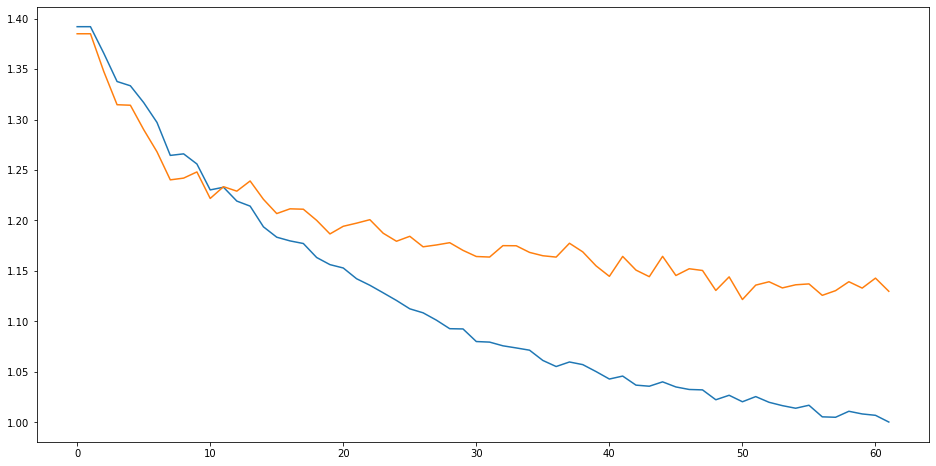

In [205]:
figsize = figure(figsize=(16,8))
ax1 = plt.subplot(1,1,1)
sn.lineplot(data=np.array(train_losses_small), ax=ax1)
sn.lineplot(x=range(len(valid_losses_small)), y=valid_losses_small, ax=ax1)


In [207]:
optimizer = torch.optim.Adam(DeepCoSI_Model_logits_small.parameters(), lr=0.0000002, weight_decay=0.)

In [208]:
for epoch in tqdm(range(63,120)):
    st = time.time()
    # train
    run_a_train_epoch(DeepCoSI_Model_logits_small, loss_fn, train_dataloader, optimizer)
    train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, train_dataloader)
    valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, validation_dataloader)
    test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits_small, test_dataloader)

    train_true = np.concatenate(np.array(train_true), 0)
    train_pred = np.concatenate(np.array(train_pred), 0)
    valid_true = np.concatenate(np.array(valid_true), 0)
    valid_pred = np.concatenate(np.array(valid_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    test_pred = np.concatenate(np.array(test_pred), 0)
    
    train_loss = loss_fn(torch.tensor(train_pred, dtype=torch.float),
                         torch.tensor(train_true, dtype=torch.float))
    valid_loss = loss_fn(torch.tensor(valid_pred, dtype=torch.float),
                         torch.tensor(valid_true, dtype=torch.float))    
    test_loss = loss_fn(torch.tensor(test_pred, dtype=torch.float),
                         torch.tensor(test_true, dtype=torch.float))
    
    #scheduler.step(test_loss)
    if test_loss.item() < best_valid_loss_small:
        best_valid_loss_deeper = test_loss.item()
        torch.save(DeepCoSI_Model_logits_small.state_dict(), f'best_deeper_models/fine_tuning_small_{epoch}_01_12.pth')
    
    train_pred_bin = []
    for x in train_pred[:,0]:
        if x >= 0.5:
            train_pred_bin.append([1.])
        else:
            train_pred_bin.append([0.])
            
    valid_pred_bin = []
    for x in valid_pred[:,0]:
        if x >= 0.:
            valid_pred_bin.append([1.])
        else:
            valid_pred_bin.append([0.])
            
    test_pred_bin = []
    for x in test_pred[:,0]:
        if x >= 0.:
            test_pred_bin.append([1.])
        else:
            test_pred_bin.append([0.])         
    
    train_auc = roc_auc_score(train_true, train_pred)
    valid_auc = roc_auc_score(valid_true, valid_pred)
    test_auc = roc_auc_score(test_true, test_pred)
    train_aucs_small.append(train_auc)
    valid_aucs_small.append(valid_auc)
    test_aucs_small.append(test_auc)
    
    train_accuracy = accuracy_score(train_true, train_pred_bin)
    train_accuracies_small.append(train_accuracy)
    valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
    valid_accuracies_small.append(valid_accuracy)
    test_accuracy = accuracy_score(test_true, test_pred_bin)
    test_accuracies_small.append(test_accuracy)
                           
    train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
    train_precisions_small.append(train_precision)
    train_recalls_small.append(train_recall)
    train_thresholds_small.append(train_threshold)
    train_auprc = auc(train_recall, train_precision)
    train_auprcs_small.append(train_auprc)
    
    valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
    valid_precisions_small.append(valid_precision)
    valid_recalls_small.append(valid_recall)
    valid_thresholds_small.append(valid_threshold)
    valid_auprc = auc(valid_recall, valid_precision)
    valid_auprcs_small.append(valid_auprc)
    
    test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
    test_precisions_small.append(test_precision)
    test_recalls_small.append(test_recall)
    test_thresholds_small.append(test_threshold)
    test_auprc = auc(test_recall, test_precision)
    test_auprcs_small.append(test_auprc)
    
    train_losses_small.append(train_loss.item())
    valid_losses_small.append(valid_loss.item())
    test_losses_small.append(test_loss.item())
    
    train_num_positive_small.append(np.array(train_pred_bin).sum())
    valid_num_positive_small.append(np.array(valid_pred_bin).sum())
    test_num_positive_small.append(np.array(test_pred_bin).sum())
    
    end = time.time()
    print(
        "epoch:%s \t train_loss:%.4f \t valid_loss:%.4f \t train_accuracy:%.4f \t valid_accuracy:%.4f \t train_auc:%.4f \t valid_auc:%.4f \t train_auprc:%.4f \t valid_auprc:%.4f \t train_num_positive:%.4f \t valid_num_positive:%.4f \t time:%.3f s" % (
            epoch, train_loss.item(), test_loss.item(), train_accuracy, test_accuracy, train_auc, test_auc, train_auprc, test_auprc, train_num_positive_small[-1], test_num_positive_small[-1],end - st))
    print(
        "epoch:%s \t test_loss:%.4f \t test_accuracy:%.4f \t test_auc:%.4f \t test_auprc:%.4f \t test_num_positive:%.4f \t time:%.3f s" % (
            epoch, valid_loss.item(), valid_accuracy, valid_auc, valid_auprc, valid_num_positive_small[-1], end - st))

  2%|▏         | 1/57 [04:38<4:19:58, 278.54s/it]

epoch:63 	 train_loss:0.9912 	 valid_loss:1.2404 	 train_accuracy:0.8010 	 valid_accuracy:0.6827 	 train_auc:0.7797 	 valid_auc:0.6601 	 train_auprc:0.3071 	 valid_auprc:0.1951 	 train_num_positive:856.0000 	 valid_num_positive:157.0000 	 time:278.538 s
epoch:63 	 test_loss:1.1176 	 test_accuracy:0.6538 	 test_auc:0.7116 	 test_auprc:0.3128 	 test_num_positive:167.0000 	 time:278.538 s


  4%|▎         | 2/57 [09:15<4:14:28, 277.60s/it]

epoch:64 	 train_loss:0.9893 	 valid_loss:1.2454 	 train_accuracy:0.8085 	 valid_accuracy:0.6908 	 train_auc:0.7801 	 valid_auc:0.6596 	 train_auprc:0.3073 	 valid_auprc:0.2012 	 train_num_positive:813.0000 	 valid_num_positive:153.0000 	 time:276.944 s
epoch:64 	 test_loss:1.1166 	 test_accuracy:0.6796 	 test_auc:0.7108 	 test_auprc:0.3014 	 test_num_positive:155.0000 	 time:276.944 s


  5%|▌         | 3/57 [13:53<4:10:00, 277.79s/it]

epoch:65 	 train_loss:0.9962 	 valid_loss:1.2599 	 train_accuracy:0.7995 	 valid_accuracy:0.6847 	 train_auc:0.7804 	 valid_auc:0.6543 	 train_auprc:0.3037 	 valid_auprc:0.1972 	 train_num_positive:878.0000 	 valid_num_positive:156.0000 	 time:278.017 s
epoch:65 	 test_loss:1.1307 	 test_accuracy:0.6473 	 test_auc:0.7095 	 test_auprc:0.3065 	 test_num_positive:170.0000 	 time:278.017 s


  7%|▋         | 4/57 [18:30<4:05:15, 277.65s/it]

epoch:66 	 train_loss:0.9942 	 valid_loss:1.2682 	 train_accuracy:0.8010 	 valid_accuracy:0.6807 	 train_auc:0.7804 	 valid_auc:0.6516 	 train_auprc:0.3055 	 valid_auprc:0.1958 	 train_num_positive:864.0000 	 valid_num_positive:160.0000 	 time:277.440 s
epoch:66 	 test_loss:1.1315 	 test_accuracy:0.6516 	 test_auc:0.7088 	 test_auprc:0.3046 	 test_num_positive:168.0000 	 time:277.440 s


  9%|▉         | 5/57 [23:09<4:00:58, 278.06s/it]

epoch:67 	 train_loss:0.9929 	 valid_loss:1.2551 	 train_accuracy:0.7969 	 valid_accuracy:0.6787 	 train_auc:0.7823 	 valid_auc:0.6571 	 train_auprc:0.3043 	 valid_auprc:0.1985 	 train_num_positive:885.0000 	 valid_num_positive:159.0000 	 time:278.767 s
epoch:67 	 test_loss:1.1284 	 test_accuracy:0.6602 	 test_auc:0.7131 	 test_auprc:0.3082 	 test_num_positive:166.0000 	 time:278.767 s


 11%|█         | 6/57 [27:48<3:56:37, 278.39s/it]

epoch:68 	 train_loss:0.9895 	 valid_loss:1.2542 	 train_accuracy:0.8077 	 valid_accuracy:0.6867 	 train_auc:0.7817 	 valid_auc:0.6575 	 train_auprc:0.3054 	 valid_auprc:0.1962 	 train_num_positive:826.0000 	 valid_num_positive:153.0000 	 time:279.025 s
epoch:68 	 test_loss:1.1140 	 test_accuracy:0.6667 	 test_auc:0.7143 	 test_auprc:0.3171 	 test_num_positive:161.0000 	 time:279.025 s


 12%|█▏        | 7/57 [32:28<3:52:25, 278.91s/it]

epoch:69 	 train_loss:0.9904 	 valid_loss:1.2655 	 train_accuracy:0.8024 	 valid_accuracy:0.6867 	 train_auc:0.7828 	 valid_auc:0.6553 	 train_auprc:0.3054 	 valid_auprc:0.1922 	 train_num_positive:856.0000 	 valid_num_positive:155.0000 	 time:279.996 s
epoch:69 	 test_loss:1.1218 	 test_accuracy:0.6602 	 test_auc:0.7146 	 test_auprc:0.3005 	 test_num_positive:164.0000 	 time:279.996 s


 14%|█▍        | 8/57 [37:05<3:47:15, 278.27s/it]

epoch:70 	 train_loss:0.9866 	 valid_loss:1.2515 	 train_accuracy:0.8060 	 valid_accuracy:0.6847 	 train_auc:0.7820 	 valid_auc:0.6541 	 train_auprc:0.3096 	 valid_auprc:0.1980 	 train_num_positive:837.0000 	 valid_num_positive:154.0000 	 time:276.893 s
epoch:70 	 test_loss:1.1133 	 test_accuracy:0.6753 	 test_auc:0.7147 	 test_auprc:0.3180 	 test_num_positive:157.0000 	 time:276.893 s


 16%|█▌        | 9/57 [41:41<3:42:06, 277.64s/it]

epoch:71 	 train_loss:0.9918 	 valid_loss:1.2515 	 train_accuracy:0.7985 	 valid_accuracy:0.6787 	 train_auc:0.7813 	 valid_auc:0.6544 	 train_auprc:0.3065 	 valid_auprc:0.2007 	 train_num_positive:876.0000 	 valid_num_positive:163.0000 	 time:276.245 s
epoch:71 	 test_loss:1.1315 	 test_accuracy:0.6473 	 test_auc:0.7056 	 test_auprc:0.3122 	 test_num_positive:170.0000 	 time:276.245 s


 18%|█▊        | 10/57 [46:17<3:37:00, 277.04s/it]

epoch:72 	 train_loss:0.9864 	 valid_loss:1.2544 	 train_accuracy:0.8116 	 valid_accuracy:0.6908 	 train_auc:0.7828 	 valid_auc:0.6549 	 train_auprc:0.3067 	 valid_auprc:0.1958 	 train_num_positive:804.0000 	 valid_num_positive:149.0000 	 time:275.704 s
epoch:72 	 test_loss:1.1245 	 test_accuracy:0.6667 	 test_auc:0.7088 	 test_auprc:0.2966 	 test_num_positive:161.0000 	 time:275.704 s


 19%|█▉        | 11/57 [50:53<3:32:05, 276.64s/it]

epoch:73 	 train_loss:0.9860 	 valid_loss:1.2532 	 train_accuracy:0.8082 	 valid_accuracy:0.6908 	 train_auc:0.7827 	 valid_auc:0.6574 	 train_auprc:0.3075 	 valid_auprc:0.1945 	 train_num_positive:838.0000 	 valid_num_positive:155.0000 	 time:275.716 s
epoch:73 	 test_loss:1.1241 	 test_accuracy:0.6516 	 test_auc:0.7100 	 test_auprc:0.3146 	 test_num_positive:168.0000 	 time:275.716 s


 21%|██        | 12/57 [55:29<3:27:27, 276.60s/it]

epoch:74 	 train_loss:0.9883 	 valid_loss:1.2631 	 train_accuracy:0.8056 	 valid_accuracy:0.6807 	 train_auc:0.7832 	 valid_auc:0.6555 	 train_auprc:0.3063 	 valid_auprc:0.1921 	 train_num_positive:841.0000 	 valid_num_positive:160.0000 	 time:276.517 s
epoch:74 	 test_loss:1.1232 	 test_accuracy:0.6602 	 test_auc:0.7123 	 test_auprc:0.3016 	 test_num_positive:164.0000 	 time:276.517 s


 23%|██▎       | 13/57 [1:00:05<3:22:44, 276.46s/it]

epoch:75 	 train_loss:0.9838 	 valid_loss:1.2646 	 train_accuracy:0.8174 	 valid_accuracy:0.6928 	 train_auc:0.7828 	 valid_auc:0.6477 	 train_auprc:0.3108 	 valid_auprc:0.1961 	 train_num_positive:786.0000 	 valid_num_positive:150.0000 	 time:276.149 s
epoch:75 	 test_loss:1.1185 	 test_accuracy:0.6774 	 test_auc:0.7101 	 test_auprc:0.3135 	 test_num_positive:156.0000 	 time:276.149 s


 25%|██▍       | 14/57 [1:04:41<3:18:01, 276.31s/it]

epoch:76 	 train_loss:0.9835 	 valid_loss:1.2492 	 train_accuracy:0.8034 	 valid_accuracy:0.6767 	 train_auc:0.7846 	 valid_auc:0.6575 	 train_auprc:0.3097 	 valid_auprc:0.1990 	 train_num_positive:858.0000 	 valid_num_positive:158.0000 	 time:275.960 s
epoch:76 	 test_loss:1.1180 	 test_accuracy:0.6538 	 test_auc:0.7142 	 test_auprc:0.3157 	 test_num_positive:167.0000 	 time:275.960 s


 26%|██▋       | 15/57 [1:09:18<3:13:23, 276.28s/it]

epoch:77 	 train_loss:0.9846 	 valid_loss:1.2575 	 train_accuracy:0.8051 	 valid_accuracy:0.6807 	 train_auc:0.7840 	 valid_auc:0.6573 	 train_auprc:0.3090 	 valid_auprc:0.1925 	 train_num_positive:839.0000 	 valid_num_positive:154.0000 	 time:276.190 s
epoch:77 	 test_loss:1.1208 	 test_accuracy:0.6624 	 test_auc:0.7144 	 test_auprc:0.2963 	 test_num_positive:163.0000 	 time:276.190 s


 28%|██▊       | 16/57 [1:13:53<3:08:41, 276.14s/it]

epoch:78 	 train_loss:0.9828 	 valid_loss:1.2520 	 train_accuracy:0.8027 	 valid_accuracy:0.6847 	 train_auc:0.7845 	 valid_auc:0.6575 	 train_auprc:0.3117 	 valid_auprc:0.1983 	 train_num_positive:853.0000 	 valid_num_positive:156.0000 	 time:275.808 s
epoch:78 	 test_loss:1.1192 	 test_accuracy:0.6667 	 test_auc:0.7119 	 test_auprc:0.3113 	 test_num_positive:161.0000 	 time:275.808 s


 30%|██▉       | 17/57 [1:18:29<3:04:04, 276.10s/it]

epoch:79 	 train_loss:0.9827 	 valid_loss:1.2558 	 train_accuracy:0.8070 	 valid_accuracy:0.6847 	 train_auc:0.7842 	 valid_auc:0.6530 	 train_auprc:0.3101 	 valid_auprc:0.1947 	 train_num_positive:837.0000 	 valid_num_positive:156.0000 	 time:276.023 s
epoch:79 	 test_loss:1.1224 	 test_accuracy:0.6667 	 test_auc:0.7108 	 test_auprc:0.3021 	 test_num_positive:161.0000 	 time:276.023 s


 32%|███▏      | 18/57 [1:23:06<2:59:29, 276.13s/it]

epoch:80 	 train_loss:0.9851 	 valid_loss:1.2645 	 train_accuracy:0.8000 	 valid_accuracy:0.6787 	 train_auc:0.7851 	 valid_auc:0.6526 	 train_auprc:0.3088 	 valid_auprc:0.1945 	 train_num_positive:876.0000 	 valid_num_positive:161.0000 	 time:276.201 s
epoch:80 	 test_loss:1.1306 	 test_accuracy:0.6495 	 test_auc:0.7092 	 test_auprc:0.2853 	 test_num_positive:171.0000 	 time:276.201 s


 33%|███▎      | 19/57 [1:27:43<2:55:01, 276.36s/it]

epoch:81 	 train_loss:0.9828 	 valid_loss:1.2453 	 train_accuracy:0.8041 	 valid_accuracy:0.6807 	 train_auc:0.7846 	 valid_auc:0.6592 	 train_auprc:0.3087 	 valid_auprc:0.1960 	 train_num_positive:857.0000 	 valid_num_positive:158.0000 	 time:276.886 s
epoch:81 	 test_loss:1.1215 	 test_accuracy:0.6602 	 test_auc:0.7126 	 test_auprc:0.3000 	 test_num_positive:166.0000 	 time:276.886 s


 35%|███▌      | 20/57 [1:32:19<2:50:26, 276.39s/it]

epoch:82 	 train_loss:0.9802 	 valid_loss:1.2339 	 train_accuracy:0.8051 	 valid_accuracy:0.6888 	 train_auc:0.7846 	 valid_auc:0.6587 	 train_auprc:0.3127 	 valid_auprc:0.1985 	 train_num_positive:839.0000 	 valid_num_positive:156.0000 	 time:276.449 s
epoch:82 	 test_loss:1.1113 	 test_accuracy:0.6602 	 test_auc:0.7109 	 test_auprc:0.3166 	 test_num_positive:164.0000 	 time:276.449 s


 37%|███▋      | 21/57 [1:36:56<2:45:54, 276.52s/it]

epoch:83 	 train_loss:0.9861 	 valid_loss:1.2626 	 train_accuracy:0.8027 	 valid_accuracy:0.6827 	 train_auc:0.7855 	 valid_auc:0.6564 	 train_auprc:0.3055 	 valid_auprc:0.1916 	 train_num_positive:861.0000 	 valid_num_positive:159.0000 	 time:276.827 s
epoch:83 	 test_loss:1.1191 	 test_accuracy:0.6516 	 test_auc:0.7155 	 test_auprc:0.3048 	 test_num_positive:168.0000 	 time:276.827 s


 39%|███▊      | 22/57 [1:41:32<2:41:18, 276.52s/it]

epoch:84 	 train_loss:0.9732 	 valid_loss:1.2457 	 train_accuracy:0.8121 	 valid_accuracy:0.6908 	 train_auc:0.7878 	 valid_auc:0.6571 	 train_auprc:0.3143 	 valid_auprc:0.1990 	 train_num_positive:810.0000 	 valid_num_positive:151.0000 	 time:276.514 s
epoch:84 	 test_loss:1.1162 	 test_accuracy:0.6624 	 test_auc:0.7127 	 test_auprc:0.3062 	 test_num_positive:163.0000 	 time:276.514 s


 40%|████      | 23/57 [1:46:09<2:36:44, 276.61s/it]

epoch:85 	 train_loss:0.9825 	 valid_loss:1.2522 	 train_accuracy:0.8010 	 valid_accuracy:0.6767 	 train_auc:0.7871 	 valid_auc:0.6588 	 train_auprc:0.3065 	 valid_auprc:0.1949 	 train_num_positive:870.0000 	 valid_num_positive:160.0000 	 time:276.832 s
epoch:85 	 test_loss:1.1219 	 test_accuracy:0.6538 	 test_auc:0.7169 	 test_auprc:0.2934 	 test_num_positive:169.0000 	 time:276.832 s


 42%|████▏     | 24/57 [1:50:47<2:32:22, 277.05s/it]

epoch:86 	 train_loss:0.9786 	 valid_loss:1.2455 	 train_accuracy:0.8051 	 valid_accuracy:0.6888 	 train_auc:0.7870 	 valid_auc:0.6585 	 train_auprc:0.3120 	 valid_auprc:0.1952 	 train_num_positive:849.0000 	 valid_num_positive:158.0000 	 time:278.067 s
epoch:86 	 test_loss:1.1186 	 test_accuracy:0.6667 	 test_auc:0.7128 	 test_auprc:0.3169 	 test_num_positive:161.0000 	 time:278.067 s


 44%|████▍     | 25/57 [1:55:25<2:27:55, 277.35s/it]

epoch:87 	 train_loss:0.9783 	 valid_loss:1.2496 	 train_accuracy:0.8087 	 valid_accuracy:0.6928 	 train_auc:0.7866 	 valid_auc:0.6586 	 train_auprc:0.3105 	 valid_auprc:0.1949 	 train_num_positive:828.0000 	 valid_num_positive:152.0000 	 time:278.055 s
epoch:87 	 test_loss:1.1111 	 test_accuracy:0.6538 	 test_auc:0.7155 	 test_auprc:0.2960 	 test_num_positive:169.0000 	 time:278.055 s


 46%|████▌     | 26/57 [2:00:03<2:23:18, 277.38s/it]

epoch:88 	 train_loss:0.9801 	 valid_loss:1.2572 	 train_accuracy:0.8041 	 valid_accuracy:0.6787 	 train_auc:0.7856 	 valid_auc:0.6520 	 train_auprc:0.3137 	 valid_auprc:0.1902 	 train_num_positive:843.0000 	 valid_num_positive:159.0000 	 time:277.440 s
epoch:88 	 test_loss:1.1120 	 test_accuracy:0.6602 	 test_auc:0.7139 	 test_auprc:0.3146 	 test_num_positive:164.0000 	 time:277.440 s


 47%|████▋     | 27/57 [2:04:38<2:18:23, 276.78s/it]

epoch:89 	 train_loss:0.9747 	 valid_loss:1.2468 	 train_accuracy:0.8092 	 valid_accuracy:0.6908 	 train_auc:0.7876 	 valid_auc:0.6576 	 train_auprc:0.3152 	 valid_auprc:0.1955 	 train_num_positive:828.0000 	 valid_num_positive:153.0000 	 time:275.372 s
epoch:89 	 test_loss:1.1171 	 test_accuracy:0.6667 	 test_auc:0.7118 	 test_auprc:0.3005 	 test_num_positive:163.0000 	 time:275.372 s


 49%|████▉     | 28/57 [2:09:12<2:13:20, 275.86s/it]

epoch:90 	 train_loss:0.9780 	 valid_loss:1.2594 	 train_accuracy:0.8041 	 valid_accuracy:0.6747 	 train_auc:0.7878 	 valid_auc:0.6534 	 train_auprc:0.3132 	 valid_auprc:0.1926 	 train_num_positive:857.0000 	 valid_num_positive:163.0000 	 time:273.726 s
epoch:90 	 test_loss:1.1186 	 test_accuracy:0.6538 	 test_auc:0.7137 	 test_auprc:0.3116 	 test_num_positive:167.0000 	 time:273.726 s


 51%|█████     | 29/57 [2:13:46<2:08:33, 275.48s/it]

epoch:91 	 train_loss:0.9723 	 valid_loss:1.2506 	 train_accuracy:0.8116 	 valid_accuracy:0.6928 	 train_auc:0.7888 	 valid_auc:0.6571 	 train_auprc:0.3137 	 valid_auprc:0.1954 	 train_num_positive:818.0000 	 valid_num_positive:152.0000 	 time:274.584 s
epoch:91 	 test_loss:1.1095 	 test_accuracy:0.6774 	 test_auc:0.7156 	 test_auprc:0.3180 	 test_num_positive:158.0000 	 time:274.584 s


 53%|█████▎    | 30/57 [2:18:23<2:04:07, 275.83s/it]

epoch:92 	 train_loss:0.9731 	 valid_loss:1.2466 	 train_accuracy:0.8085 	 valid_accuracy:0.6767 	 train_auc:0.7888 	 valid_auc:0.6572 	 train_auprc:0.3125 	 valid_auprc:0.1973 	 train_num_positive:833.0000 	 valid_num_positive:160.0000 	 time:276.661 s
epoch:92 	 test_loss:1.1169 	 test_accuracy:0.6602 	 test_auc:0.7119 	 test_auprc:0.3037 	 test_num_positive:166.0000 	 time:276.661 s


 54%|█████▍    | 31/57 [2:22:59<1:59:33, 275.90s/it]

epoch:93 	 train_loss:0.9728 	 valid_loss:1.2428 	 train_accuracy:0.8075 	 valid_accuracy:0.6827 	 train_auc:0.7891 	 valid_auc:0.6613 	 train_auprc:0.3156 	 valid_auprc:0.1941 	 train_num_positive:837.0000 	 valid_num_positive:157.0000 	 time:276.056 s
epoch:93 	 test_loss:1.1110 	 test_accuracy:0.6710 	 test_auc:0.7169 	 test_auprc:0.3190 	 test_num_positive:161.0000 	 time:276.056 s


 56%|█████▌    | 32/57 [2:27:35<1:54:58, 275.95s/it]

epoch:94 	 train_loss:0.9776 	 valid_loss:1.2542 	 train_accuracy:0.7985 	 valid_accuracy:0.6687 	 train_auc:0.7890 	 valid_auc:0.6589 	 train_auprc:0.3132 	 valid_auprc:0.1966 	 train_num_positive:884.0000 	 valid_num_positive:166.0000 	 time:276.046 s
epoch:94 	 test_loss:1.1260 	 test_accuracy:0.6452 	 test_auc:0.7129 	 test_auprc:0.2971 	 test_num_positive:173.0000 	 time:276.046 s


 58%|█████▊    | 33/57 [2:32:12<1:50:26, 276.10s/it]

epoch:95 	 train_loss:0.9709 	 valid_loss:1.2573 	 train_accuracy:0.8143 	 valid_accuracy:0.6928 	 train_auc:0.7897 	 valid_auc:0.6583 	 train_auprc:0.3124 	 valid_auprc:0.1938 	 train_num_positive:805.0000 	 valid_num_positive:152.0000 	 time:276.460 s
epoch:95 	 test_loss:1.1102 	 test_accuracy:0.6774 	 test_auc:0.7170 	 test_auprc:0.3101 	 test_num_positive:156.0000 	 time:276.460 s


 60%|█████▉    | 34/57 [2:36:48<1:45:54, 276.29s/it]

epoch:96 	 train_loss:0.9722 	 valid_loss:1.2611 	 train_accuracy:0.8109 	 valid_accuracy:0.6908 	 train_auc:0.7891 	 valid_auc:0.6542 	 train_auprc:0.3148 	 valid_auprc:0.1955 	 train_num_positive:823.0000 	 valid_num_positive:153.0000 	 time:276.715 s
epoch:96 	 test_loss:1.1066 	 test_accuracy:0.6710 	 test_auc:0.7173 	 test_auprc:0.3113 	 test_num_positive:161.0000 	 time:276.715 s


 61%|██████▏   | 35/57 [2:41:26<1:41:25, 276.62s/it]

epoch:97 	 train_loss:0.9735 	 valid_loss:1.2425 	 train_accuracy:0.8015 	 valid_accuracy:0.6827 	 train_auc:0.7896 	 valid_auc:0.6580 	 train_auprc:0.3153 	 valid_auprc:0.1921 	 train_num_positive:868.0000 	 valid_num_positive:159.0000 	 time:277.396 s
epoch:97 	 test_loss:1.1121 	 test_accuracy:0.6538 	 test_auc:0.7166 	 test_auprc:0.3181 	 test_num_positive:169.0000 	 time:277.396 s


 63%|██████▎   | 36/57 [2:46:02<1:36:47, 276.57s/it]

epoch:98 	 train_loss:0.9704 	 valid_loss:1.2472 	 train_accuracy:0.8058 	 valid_accuracy:0.6867 	 train_auc:0.7910 	 valid_auc:0.6572 	 train_auprc:0.3152 	 valid_auprc:0.1932 	 train_num_positive:844.0000 	 valid_num_positive:155.0000 	 time:276.457 s
epoch:98 	 test_loss:1.1138 	 test_accuracy:0.6710 	 test_auc:0.7170 	 test_auprc:0.3157 	 test_num_positive:161.0000 	 time:276.457 s


 65%|██████▍   | 37/57 [2:50:39<1:32:13, 276.65s/it]

epoch:99 	 train_loss:0.9756 	 valid_loss:1.2444 	 train_accuracy:0.8060 	 valid_accuracy:0.6847 	 train_auc:0.7902 	 valid_auc:0.6579 	 train_auprc:0.3124 	 valid_auprc:0.1948 	 train_num_positive:843.0000 	 valid_num_positive:158.0000 	 time:276.841 s
epoch:99 	 test_loss:1.1121 	 test_accuracy:0.6559 	 test_auc:0.7160 	 test_auprc:0.2963 	 test_num_positive:168.0000 	 time:276.841 s


 67%|██████▋   | 38/57 [2:55:16<1:27:35, 276.59s/it]

epoch:100 	 train_loss:0.9725 	 valid_loss:1.2597 	 train_accuracy:0.8077 	 valid_accuracy:0.6727 	 train_auc:0.7914 	 valid_auc:0.6523 	 train_auprc:0.3137 	 valid_auprc:0.1919 	 train_num_positive:842.0000 	 valid_num_positive:164.0000 	 time:276.443 s
epoch:100 	 test_loss:1.1199 	 test_accuracy:0.6581 	 test_auc:0.7139 	 test_auprc:0.2776 	 test_num_positive:167.0000 	 time:276.443 s


 68%|██████▊   | 39/57 [2:59:51<1:22:54, 276.38s/it]

epoch:101 	 train_loss:0.9716 	 valid_loss:1.2575 	 train_accuracy:0.8019 	 valid_accuracy:0.6727 	 train_auc:0.7917 	 valid_auc:0.6550 	 train_auprc:0.3138 	 valid_auprc:0.1923 	 train_num_positive:868.0000 	 valid_num_positive:162.0000 	 time:275.882 s
epoch:101 	 test_loss:1.1163 	 test_accuracy:0.6602 	 test_auc:0.7160 	 test_auprc:0.2742 	 test_num_positive:166.0000 	 time:275.882 s


 70%|███████   | 40/57 [3:04:29<1:18:24, 276.71s/it]

epoch:102 	 train_loss:0.9716 	 valid_loss:1.2650 	 train_accuracy:0.8031 	 valid_accuracy:0.6767 	 train_auc:0.7916 	 valid_auc:0.6492 	 train_auprc:0.3155 	 valid_auprc:0.1917 	 train_num_positive:861.0000 	 valid_num_positive:162.0000 	 time:277.478 s
epoch:102 	 test_loss:1.1248 	 test_accuracy:0.6495 	 test_auc:0.7099 	 test_auprc:0.2958 	 test_num_positive:169.0000 	 time:277.478 s


 72%|███████▏  | 41/57 [3:09:05<1:13:46, 276.66s/it]

epoch:103 	 train_loss:0.9666 	 valid_loss:1.2647 	 train_accuracy:0.8133 	 valid_accuracy:0.6888 	 train_auc:0.7923 	 valid_auc:0.6495 	 train_auprc:0.3156 	 valid_auprc:0.1921 	 train_num_positive:809.0000 	 valid_num_positive:154.0000 	 time:276.548 s
epoch:103 	 test_loss:1.1180 	 test_accuracy:0.6753 	 test_auc:0.7095 	 test_auprc:0.2915 	 test_num_positive:157.0000 	 time:276.548 s


 74%|███████▎  | 42/57 [3:13:42<1:09:11, 276.78s/it]

epoch:104 	 train_loss:0.9698 	 valid_loss:1.2595 	 train_accuracy:0.8077 	 valid_accuracy:0.6807 	 train_auc:0.7921 	 valid_auc:0.6557 	 train_auprc:0.3148 	 valid_auprc:0.1930 	 train_num_positive:844.0000 	 valid_num_positive:160.0000 	 time:277.042 s
epoch:104 	 test_loss:1.1240 	 test_accuracy:0.6624 	 test_auc:0.7098 	 test_auprc:0.2843 	 test_num_positive:163.0000 	 time:277.042 s


 75%|███████▌  | 43/57 [3:18:19<1:04:35, 276.84s/it]

epoch:105 	 train_loss:0.9644 	 valid_loss:1.2521 	 train_accuracy:0.8109 	 valid_accuracy:0.6827 	 train_auc:0.7928 	 valid_auc:0.6565 	 train_auprc:0.3183 	 valid_auprc:0.1933 	 train_num_positive:825.0000 	 valid_num_positive:157.0000 	 time:276.994 s
epoch:105 	 test_loss:1.1152 	 test_accuracy:0.6602 	 test_auc:0.7120 	 test_auprc:0.3085 	 test_num_positive:164.0000 	 time:276.994 s


 77%|███████▋  | 44/57 [3:22:57<1:00:00, 276.97s/it]

epoch:106 	 train_loss:0.9687 	 valid_loss:1.2542 	 train_accuracy:0.8036 	 valid_accuracy:0.6727 	 train_auc:0.7931 	 valid_auc:0.6561 	 train_auprc:0.3144 	 valid_auprc:0.1940 	 train_num_positive:865.0000 	 valid_num_positive:162.0000 	 time:277.265 s
epoch:106 	 test_loss:1.1224 	 test_accuracy:0.6516 	 test_auc:0.7126 	 test_auprc:0.2951 	 test_num_positive:170.0000 	 time:277.265 s


 79%|███████▉  | 45/57 [3:27:34<55:25, 277.16s/it]  

epoch:107 	 train_loss:0.9619 	 valid_loss:1.2405 	 train_accuracy:0.8128 	 valid_accuracy:0.6928 	 train_auc:0.7935 	 valid_auc:0.6576 	 train_auprc:0.3169 	 valid_auprc:0.1964 	 train_num_positive:811.0000 	 valid_num_positive:152.0000 	 time:277.611 s
epoch:107 	 test_loss:1.1110 	 test_accuracy:0.6731 	 test_auc:0.7126 	 test_auprc:0.3023 	 test_num_positive:160.0000 	 time:277.611 s


 81%|████████  | 46/57 [3:32:11<50:48, 277.14s/it]

epoch:108 	 train_loss:0.9648 	 valid_loss:1.2711 	 train_accuracy:0.8138 	 valid_accuracy:0.6827 	 train_auc:0.7942 	 valid_auc:0.6530 	 train_auprc:0.3149 	 valid_auprc:0.1904 	 train_num_positive:815.0000 	 valid_num_positive:157.0000 	 time:277.089 s
epoch:108 	 test_loss:1.1152 	 test_accuracy:0.6731 	 test_auc:0.7161 	 test_auprc:0.2723 	 test_num_positive:158.0000 	 time:277.089 s


 82%|████████▏ | 47/57 [3:36:49<46:11, 277.15s/it]

epoch:109 	 train_loss:0.9623 	 valid_loss:1.2417 	 train_accuracy:0.8128 	 valid_accuracy:0.6787 	 train_auc:0.7931 	 valid_auc:0.6558 	 train_auprc:0.3197 	 valid_auprc:0.1923 	 train_num_positive:811.0000 	 valid_num_positive:159.0000 	 time:277.166 s
epoch:109 	 test_loss:1.1075 	 test_accuracy:0.6710 	 test_auc:0.7114 	 test_auprc:0.3276 	 test_num_positive:161.0000 	 time:277.166 s


 84%|████████▍ | 48/57 [3:41:25<41:33, 277.05s/it]

epoch:110 	 train_loss:0.9627 	 valid_loss:1.2385 	 train_accuracy:0.8053 	 valid_accuracy:0.6867 	 train_auc:0.7942 	 valid_auc:0.6605 	 train_auprc:0.3207 	 valid_auprc:0.1945 	 train_num_positive:852.0000 	 valid_num_positive:157.0000 	 time:276.827 s
epoch:110 	 test_loss:1.1103 	 test_accuracy:0.6516 	 test_auc:0.7154 	 test_auprc:0.3179 	 test_num_positive:168.0000 	 time:276.827 s


 86%|████████▌ | 49/57 [3:46:02<36:55, 276.99s/it]

epoch:111 	 train_loss:0.9668 	 valid_loss:1.2465 	 train_accuracy:0.8053 	 valid_accuracy:0.6747 	 train_auc:0.7939 	 valid_auc:0.6601 	 train_auprc:0.3153 	 valid_auprc:0.1966 	 train_num_positive:858.0000 	 valid_num_positive:161.0000 	 time:276.858 s
epoch:111 	 test_loss:1.1204 	 test_accuracy:0.6667 	 test_auc:0.7149 	 test_auprc:0.2754 	 test_num_positive:163.0000 	 time:276.858 s


 88%|████████▊ | 50/57 [3:50:39<32:19, 277.01s/it]

epoch:112 	 train_loss:0.9598 	 valid_loss:1.2435 	 train_accuracy:0.8128 	 valid_accuracy:0.6847 	 train_auc:0.7949 	 valid_auc:0.6602 	 train_auprc:0.3191 	 valid_auprc:0.1955 	 train_num_positive:819.0000 	 valid_num_positive:156.0000 	 time:277.048 s
epoch:112 	 test_loss:1.1151 	 test_accuracy:0.6667 	 test_auc:0.7134 	 test_auprc:0.3161 	 test_num_positive:163.0000 	 time:277.048 s


 89%|████████▉ | 51/57 [3:55:16<27:41, 276.94s/it]

epoch:113 	 train_loss:0.9605 	 valid_loss:1.2417 	 train_accuracy:0.8080 	 valid_accuracy:0.6847 	 train_auc:0.7949 	 valid_auc:0.6589 	 train_auprc:0.3206 	 valid_auprc:0.1942 	 train_num_positive:841.0000 	 valid_num_positive:156.0000 	 time:276.779 s
epoch:113 	 test_loss:1.1113 	 test_accuracy:0.6645 	 test_auc:0.7139 	 test_auprc:0.3180 	 test_num_positive:162.0000 	 time:276.779 s


 91%|█████████ | 52/57 [3:59:52<23:02, 276.53s/it]

epoch:114 	 train_loss:0.9646 	 valid_loss:1.2346 	 train_accuracy:0.8027 	 valid_accuracy:0.6707 	 train_auc:0.7949 	 valid_auc:0.6627 	 train_auprc:0.3176 	 valid_auprc:0.1953 	 train_num_positive:867.0000 	 valid_num_positive:163.0000 	 time:275.579 s
epoch:114 	 test_loss:1.1181 	 test_accuracy:0.6452 	 test_auc:0.7156 	 test_auprc:0.3046 	 test_num_positive:173.0000 	 time:275.579 s


 93%|█████████▎| 53/57 [4:04:28<18:25, 276.39s/it]

epoch:115 	 train_loss:0.9628 	 valid_loss:1.2524 	 train_accuracy:0.8099 	 valid_accuracy:0.6747 	 train_auc:0.7953 	 valid_auc:0.6573 	 train_auprc:0.3180 	 valid_auprc:0.1917 	 train_num_positive:827.0000 	 valid_num_positive:161.0000 	 time:276.040 s
epoch:115 	 test_loss:1.1229 	 test_accuracy:0.6667 	 test_auc:0.7103 	 test_auprc:0.2777 	 test_num_positive:163.0000 	 time:276.040 s


 95%|█████████▍| 54/57 [4:09:04<13:48, 276.20s/it]

epoch:116 	 train_loss:0.9599 	 valid_loss:1.2425 	 train_accuracy:0.8075 	 valid_accuracy:0.6867 	 train_auc:0.7957 	 valid_auc:0.6591 	 train_auprc:0.3216 	 valid_auprc:0.1953 	 train_num_positive:849.0000 	 valid_num_positive:157.0000 	 time:275.768 s
epoch:116 	 test_loss:1.1125 	 test_accuracy:0.6559 	 test_auc:0.7139 	 test_auprc:0.3113 	 test_num_positive:166.0000 	 time:275.768 s


 96%|█████████▋| 55/57 [4:13:40<09:12, 276.41s/it]

epoch:117 	 train_loss:0.9589 	 valid_loss:1.2442 	 train_accuracy:0.8070 	 valid_accuracy:0.6747 	 train_auc:0.7962 	 valid_auc:0.6558 	 train_auprc:0.3218 	 valid_auprc:0.1949 	 train_num_positive:845.0000 	 valid_num_positive:161.0000 	 time:276.910 s
epoch:117 	 test_loss:1.1109 	 test_accuracy:0.6495 	 test_auc:0.7155 	 test_auprc:0.3139 	 test_num_positive:169.0000 	 time:276.910 s


 98%|█████████▊| 56/57 [4:18:16<04:36, 276.15s/it]

epoch:118 	 train_loss:0.9577 	 valid_loss:1.2316 	 train_accuracy:0.8080 	 valid_accuracy:0.6807 	 train_auc:0.7966 	 valid_auc:0.6619 	 train_auprc:0.3217 	 valid_auprc:0.1987 	 train_num_positive:851.0000 	 valid_num_positive:158.0000 	 time:275.545 s
epoch:118 	 test_loss:1.1078 	 test_accuracy:0.6538 	 test_auc:0.7151 	 test_auprc:0.3092 	 test_num_positive:169.0000 	 time:275.545 s


100%|██████████| 57/57 [4:22:53<00:00, 276.73s/it]

epoch:119 	 train_loss:0.9582 	 valid_loss:1.2403 	 train_accuracy:0.8102 	 valid_accuracy:0.6827 	 train_auc:0.7958 	 valid_auc:0.6594 	 train_auprc:0.3212 	 valid_auprc:0.1953 	 train_num_positive:824.0000 	 valid_num_positive:159.0000 	 time:276.989 s
epoch:119 	 test_loss:1.1099 	 test_accuracy:0.6581 	 test_auc:0.7130 	 test_auprc:0.3256 	 test_num_positive:167.0000 	 time:276.989 s


In [219]:
np.array(train_dataset.labels).sum()

431

<AxesSubplot:>

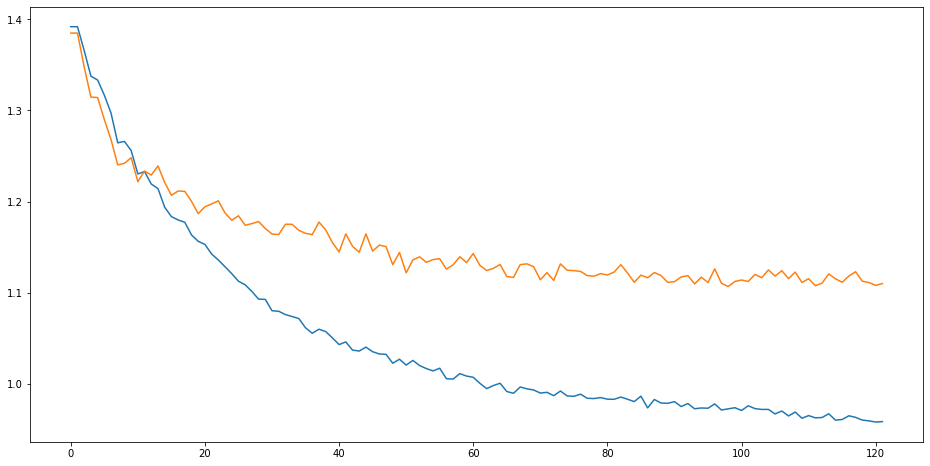

In [209]:
figsize = figure(figsize=(16,8))
ax2 = plt.subplot(1,1,1)
sn.lineplot(data=np.array(train_losses_small), ax=ax2)
sn.lineplot(x=range(len(valid_losses_small)), y=valid_losses_small, ax=ax2)

The model overfitted the training data but that also led to the lowest validation loss

In [211]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

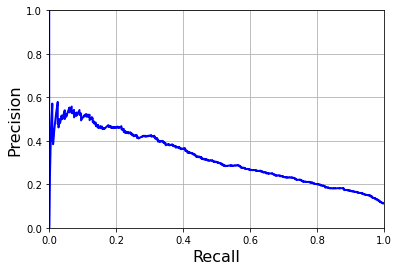

In [221]:
plot_precision_vs_recall(train_precisions_small[-2], train_recalls_small[-2])

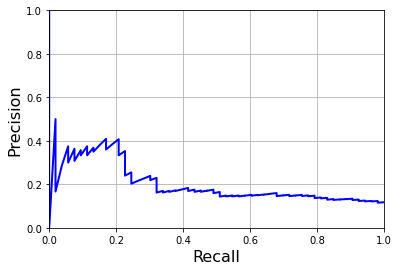

In [222]:
plot_precision_vs_recall(test_precisions_small[-2], test_recalls_small[-2])

In [ ]:
plt.plot(recalls, precisions, "b-", linewidth=2)

In [213]:
from sklearn.metrics import f1_score

In [216]:
f1_score(train_true, train_pred_bin)

0.37450199203187257

In [217]:
f1_score(test_true, test_pred_bin)

0.25471698113207547